In [27]:
%tensorflow_version 1.14
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow is already loaded. Please restart the runtime to change versions.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
1.15.2


In [28]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)



Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [29]:
# Training Parameters
learning_rate = 0.1
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0 # Dropout, probability to drop a unit

In [34]:
random.seed(1997)

In [30]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [32]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    # optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [ ]:
sigma = 0
datanum = 3000
A = np.random.randn(55000,28,28)
B = np.zeros([55000,18,18])
A[0:55000, 5:23, 5:23] = B
A_1 = np.random.randn(10000,28,28)
B_1 = np.zeros([10000,18,18])
A_1[0:10000, 5:23, 5:23] = B_1
Data_test = np.random.rand(20, 10)
Data_train = np.random.rand(20, 10)
for s in range(20):
  sigma = 0.05*s
  mnist_train = np.array(A.reshape((55000, 784)) + sigma*mnist.train.images, dtype="float32")
  mnist_test= np.array(A_1.reshape((10000, 784)) + sigma*mnist.test.images, dtype="float32")
  for t in range(10):
    datanum = 3000 + 500*t
    C = np.random.choice(55000, datanum)
    mnist_train_sub = mnist_train[C, 0:784]
    mnist_label_sub = mnist.train.labels[C]
    model = tf.estimator.Estimator(model_fn)
    # Define the input function for training
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': mnist_train_sub}, y= mnist_label_sub,
        batch_size=batch_size, num_epochs=None, shuffle=True)
    # Train the Model
    model.train(input_fn, steps=num_steps)
    input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist_train_sub}, y= mnist_label_sub,
    batch_size=batch_size, shuffle=False)
    # Use the Estimator 'evaluate' method
    Data_train[s][t] = model.evaluate(input_fn)['loss']

    input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist_test}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
    # Use the Estimator 'evaluate' method
    Data_test[s][t] = model.evaluate(input_fn)['loss']
    print(Data_test[s][t])
np.savetxt('data_test100.csv', Data_test)
np.savetxt('data_train100.csv', Data_train)
!cp data_test100.csv "gdrive/My Drive/"
!cp data_train100.csv "gdrive/My Drive/"


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqc9ugha5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc623872dd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqc9ugha5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc623872dd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpqc9ugha5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpqc9ugha5/model.ckpt.


INFO:tensorflow:loss = 2.3707764, step = 1


INFO:tensorflow:loss = 2.3707764, step = 1


INFO:tensorflow:global_step/sec: 8.74676


INFO:tensorflow:global_step/sec: 8.74676


INFO:tensorflow:loss = 2.2514257, step = 101 (11.444 sec)


INFO:tensorflow:loss = 2.2514257, step = 101 (11.444 sec)


INFO:tensorflow:global_step/sec: 8.69164


INFO:tensorflow:global_step/sec: 8.69164


INFO:tensorflow:loss = 2.174246, step = 201 (11.498 sec)


INFO:tensorflow:loss = 2.174246, step = 201 (11.498 sec)


INFO:tensorflow:global_step/sec: 7.02853


INFO:tensorflow:global_step/sec: 7.02853


INFO:tensorflow:loss = 1.9730616, step = 301 (14.232 sec)


INFO:tensorflow:loss = 1.9730616, step = 301 (14.232 sec)


INFO:tensorflow:global_step/sec: 8.45382


INFO:tensorflow:global_step/sec: 8.45382


INFO:tensorflow:loss = 1.680589, step = 401 (11.829 sec)


INFO:tensorflow:loss = 1.680589, step = 401 (11.829 sec)


INFO:tensorflow:global_step/sec: 8.45671


INFO:tensorflow:global_step/sec: 8.45671


INFO:tensorflow:loss = 1.3278055, step = 501 (11.824 sec)


INFO:tensorflow:loss = 1.3278055, step = 501 (11.824 sec)


INFO:tensorflow:global_step/sec: 8.48946


INFO:tensorflow:global_step/sec: 8.48946


INFO:tensorflow:loss = 0.9589377, step = 601 (11.781 sec)


INFO:tensorflow:loss = 0.9589377, step = 601 (11.781 sec)


INFO:tensorflow:global_step/sec: 8.49106


INFO:tensorflow:global_step/sec: 8.49106


INFO:tensorflow:loss = 0.66044694, step = 701 (11.776 sec)


INFO:tensorflow:loss = 0.66044694, step = 701 (11.776 sec)


INFO:tensorflow:global_step/sec: 8.48317


INFO:tensorflow:global_step/sec: 8.48317


INFO:tensorflow:loss = 0.09679959, step = 801 (11.787 sec)


INFO:tensorflow:loss = 0.09679959, step = 801 (11.787 sec)


INFO:tensorflow:global_step/sec: 8.47355


INFO:tensorflow:global_step/sec: 8.47355


INFO:tensorflow:loss = 0.022757247, step = 901 (11.804 sec)


INFO:tensorflow:loss = 0.022757247, step = 901 (11.804 sec)


INFO:tensorflow:global_step/sec: 8.46958


INFO:tensorflow:global_step/sec: 8.46958


INFO:tensorflow:loss = 0.014168413, step = 1001 (11.808 sec)


INFO:tensorflow:loss = 0.014168413, step = 1001 (11.808 sec)


INFO:tensorflow:global_step/sec: 7.49424


INFO:tensorflow:global_step/sec: 7.49424


INFO:tensorflow:loss = 0.010672187, step = 1101 (13.342 sec)


INFO:tensorflow:loss = 0.010672187, step = 1101 (13.342 sec)


INFO:tensorflow:global_step/sec: 8.50262


INFO:tensorflow:global_step/sec: 8.50262


INFO:tensorflow:loss = 0.008731986, step = 1201 (11.761 sec)


INFO:tensorflow:loss = 0.008731986, step = 1201 (11.761 sec)


INFO:tensorflow:global_step/sec: 8.53973


INFO:tensorflow:global_step/sec: 8.53973


INFO:tensorflow:loss = 0.0062642014, step = 1301 (11.710 sec)


INFO:tensorflow:loss = 0.0062642014, step = 1301 (11.710 sec)


INFO:tensorflow:global_step/sec: 8.49156


INFO:tensorflow:global_step/sec: 8.49156


INFO:tensorflow:loss = 0.005369434, step = 1401 (11.777 sec)


INFO:tensorflow:loss = 0.005369434, step = 1401 (11.777 sec)


INFO:tensorflow:global_step/sec: 8.58251


INFO:tensorflow:global_step/sec: 8.58251


INFO:tensorflow:loss = 0.005032097, step = 1501 (11.654 sec)


INFO:tensorflow:loss = 0.005032097, step = 1501 (11.654 sec)


INFO:tensorflow:global_step/sec: 8.58625


INFO:tensorflow:global_step/sec: 8.58625


INFO:tensorflow:loss = 0.004211621, step = 1601 (11.643 sec)


INFO:tensorflow:loss = 0.004211621, step = 1601 (11.643 sec)


INFO:tensorflow:global_step/sec: 8.52833


INFO:tensorflow:global_step/sec: 8.52833


INFO:tensorflow:loss = 0.003460238, step = 1701 (11.727 sec)


INFO:tensorflow:loss = 0.003460238, step = 1701 (11.727 sec)


INFO:tensorflow:global_step/sec: 8.48546


INFO:tensorflow:global_step/sec: 8.48546


INFO:tensorflow:loss = 0.0030054883, step = 1801 (11.785 sec)


INFO:tensorflow:loss = 0.0030054883, step = 1801 (11.785 sec)


INFO:tensorflow:global_step/sec: 8.47598


INFO:tensorflow:global_step/sec: 8.47598


INFO:tensorflow:loss = 0.0026173007, step = 1901 (11.793 sec)


INFO:tensorflow:loss = 0.0026173007, step = 1901 (11.793 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpqc9ugha5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpqc9ugha5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0024230555.


INFO:tensorflow:Loss for final step: 0.0024230555.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:20:02Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:20:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpqc9ugha5/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpqc9ugha5/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:20:03


INFO:tensorflow:Finished evaluation at 2022-08-02-14:20:03


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002443447


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002443447


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqc9ugha5/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqc9ugha5/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:20:03Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:20:03Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpqc9ugha5/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpqc9ugha5/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:20:06


INFO:tensorflow:Finished evaluation at 2022-08-02-14:20:06


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1025, global_step = 2000, loss = 6.858852


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1025, global_step = 2000, loss = 6.858852


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqc9ugha5/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqc9ugha5/model.ckpt-2000


6.858851909637451
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgm2njlq3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622bbfdd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgm2njlq3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622bbfdd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpgm2njlq3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpgm2njlq3/model.ckpt.


INFO:tensorflow:loss = 2.3400154, step = 1


INFO:tensorflow:loss = 2.3400154, step = 1


INFO:tensorflow:global_step/sec: 8.5978


INFO:tensorflow:global_step/sec: 8.5978


INFO:tensorflow:loss = 2.243495, step = 101 (11.641 sec)


INFO:tensorflow:loss = 2.243495, step = 101 (11.641 sec)


INFO:tensorflow:global_step/sec: 8.60596


INFO:tensorflow:global_step/sec: 8.60596


INFO:tensorflow:loss = 2.180301, step = 201 (11.619 sec)


INFO:tensorflow:loss = 2.180301, step = 201 (11.619 sec)


INFO:tensorflow:global_step/sec: 8.51995


INFO:tensorflow:global_step/sec: 8.51995


INFO:tensorflow:loss = 2.2248375, step = 301 (11.740 sec)


INFO:tensorflow:loss = 2.2248375, step = 301 (11.740 sec)


INFO:tensorflow:global_step/sec: 8.53369


INFO:tensorflow:global_step/sec: 8.53369


INFO:tensorflow:loss = 1.8785508, step = 401 (11.715 sec)


INFO:tensorflow:loss = 1.8785508, step = 401 (11.715 sec)


INFO:tensorflow:global_step/sec: 8.5838


INFO:tensorflow:global_step/sec: 8.5838


INFO:tensorflow:loss = 1.6482937, step = 501 (11.649 sec)


INFO:tensorflow:loss = 1.6482937, step = 501 (11.649 sec)


INFO:tensorflow:global_step/sec: 8.50427


INFO:tensorflow:global_step/sec: 8.50427


INFO:tensorflow:loss = 1.2399585, step = 601 (11.755 sec)


INFO:tensorflow:loss = 1.2399585, step = 601 (11.755 sec)


INFO:tensorflow:global_step/sec: 8.61701


INFO:tensorflow:global_step/sec: 8.61701


INFO:tensorflow:loss = 1.0879892, step = 701 (11.611 sec)


INFO:tensorflow:loss = 1.0879892, step = 701 (11.611 sec)


INFO:tensorflow:global_step/sec: 8.45393


INFO:tensorflow:global_step/sec: 8.45393


INFO:tensorflow:loss = 1.4275635, step = 801 (11.824 sec)


INFO:tensorflow:loss = 1.4275635, step = 801 (11.824 sec)


INFO:tensorflow:global_step/sec: 8.34438


INFO:tensorflow:global_step/sec: 8.34438


INFO:tensorflow:loss = 0.37827355, step = 901 (11.990 sec)


INFO:tensorflow:loss = 0.37827355, step = 901 (11.990 sec)


INFO:tensorflow:global_step/sec: 8.25014


INFO:tensorflow:global_step/sec: 8.25014


INFO:tensorflow:loss = 0.04243318, step = 1001 (12.117 sec)


INFO:tensorflow:loss = 0.04243318, step = 1001 (12.117 sec)


INFO:tensorflow:global_step/sec: 8.25633


INFO:tensorflow:global_step/sec: 8.25633


INFO:tensorflow:loss = 0.023136405, step = 1101 (12.115 sec)


INFO:tensorflow:loss = 0.023136405, step = 1101 (12.115 sec)


INFO:tensorflow:global_step/sec: 8.34935


INFO:tensorflow:global_step/sec: 8.34935


INFO:tensorflow:loss = 0.015054444, step = 1201 (11.975 sec)


INFO:tensorflow:loss = 0.015054444, step = 1201 (11.975 sec)


INFO:tensorflow:global_step/sec: 8.29491


INFO:tensorflow:global_step/sec: 8.29491


INFO:tensorflow:loss = 0.009003267, step = 1301 (12.060 sec)


INFO:tensorflow:loss = 0.009003267, step = 1301 (12.060 sec)


INFO:tensorflow:global_step/sec: 8.30173


INFO:tensorflow:global_step/sec: 8.30173


INFO:tensorflow:loss = 0.008811615, step = 1401 (12.039 sec)


INFO:tensorflow:loss = 0.008811615, step = 1401 (12.039 sec)


INFO:tensorflow:global_step/sec: 8.40539


INFO:tensorflow:global_step/sec: 8.40539


INFO:tensorflow:loss = 0.0071938764, step = 1501 (11.911 sec)


INFO:tensorflow:loss = 0.0071938764, step = 1501 (11.911 sec)


INFO:tensorflow:global_step/sec: 8.29459


INFO:tensorflow:global_step/sec: 8.29459


INFO:tensorflow:loss = 0.005778734, step = 1601 (12.051 sec)


INFO:tensorflow:loss = 0.005778734, step = 1601 (12.051 sec)


INFO:tensorflow:global_step/sec: 8.4552


INFO:tensorflow:global_step/sec: 8.4552


INFO:tensorflow:loss = 0.0052445694, step = 1701 (11.820 sec)


INFO:tensorflow:loss = 0.0052445694, step = 1701 (11.820 sec)


INFO:tensorflow:global_step/sec: 8.56476


INFO:tensorflow:global_step/sec: 8.56476


INFO:tensorflow:loss = 0.0044607082, step = 1801 (11.680 sec)


INFO:tensorflow:loss = 0.0044607082, step = 1801 (11.680 sec)


INFO:tensorflow:global_step/sec: 8.53996


INFO:tensorflow:global_step/sec: 8.53996


INFO:tensorflow:loss = 0.0035065576, step = 1901 (11.706 sec)


INFO:tensorflow:loss = 0.0035065576, step = 1901 (11.706 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpgm2njlq3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpgm2njlq3/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0034681028.


INFO:tensorflow:Loss for final step: 0.0034681028.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:24:05Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:24:05Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpgm2njlq3/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpgm2njlq3/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:24:06


INFO:tensorflow:Finished evaluation at 2022-08-02-14:24:06


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0032110717


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0032110717


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgm2njlq3/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgm2njlq3/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:24:07Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:24:07Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpgm2njlq3/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpgm2njlq3/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:24:10


INFO:tensorflow:Finished evaluation at 2022-08-02-14:24:10


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1004, global_step = 2000, loss = 7.321921


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1004, global_step = 2000, loss = 7.321921


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgm2njlq3/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgm2njlq3/model.ckpt-2000


7.321920871734619
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpf9j3kl2l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628d24950>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpf9j3kl2l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628d24950>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpf9j3kl2l/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpf9j3kl2l/model.ckpt.


INFO:tensorflow:loss = 2.3263335, step = 1


INFO:tensorflow:loss = 2.3263335, step = 1


INFO:tensorflow:global_step/sec: 8.14524


INFO:tensorflow:global_step/sec: 8.14524


INFO:tensorflow:loss = 2.2779393, step = 101 (12.285 sec)


INFO:tensorflow:loss = 2.2779393, step = 101 (12.285 sec)


INFO:tensorflow:global_step/sec: 8.31266


INFO:tensorflow:global_step/sec: 8.31266


INFO:tensorflow:loss = 2.2300334, step = 201 (12.028 sec)


INFO:tensorflow:loss = 2.2300334, step = 201 (12.028 sec)


INFO:tensorflow:global_step/sec: 8.58653


INFO:tensorflow:global_step/sec: 8.58653


INFO:tensorflow:loss = 2.171085, step = 301 (11.646 sec)


INFO:tensorflow:loss = 2.171085, step = 301 (11.646 sec)


INFO:tensorflow:global_step/sec: 8.58849


INFO:tensorflow:global_step/sec: 8.58849


INFO:tensorflow:loss = 1.9955193, step = 401 (11.646 sec)


INFO:tensorflow:loss = 1.9955193, step = 401 (11.646 sec)


INFO:tensorflow:global_step/sec: 8.58705


INFO:tensorflow:global_step/sec: 8.58705


INFO:tensorflow:loss = 1.904627, step = 501 (11.649 sec)


INFO:tensorflow:loss = 1.904627, step = 501 (11.649 sec)


INFO:tensorflow:global_step/sec: 8.58314


INFO:tensorflow:global_step/sec: 8.58314


INFO:tensorflow:loss = 1.4469116, step = 601 (11.649 sec)


INFO:tensorflow:loss = 1.4469116, step = 601 (11.649 sec)


INFO:tensorflow:global_step/sec: 8.56844


INFO:tensorflow:global_step/sec: 8.56844


INFO:tensorflow:loss = 1.5063343, step = 701 (11.667 sec)


INFO:tensorflow:loss = 1.5063343, step = 701 (11.667 sec)


INFO:tensorflow:global_step/sec: 8.47337


INFO:tensorflow:global_step/sec: 8.47337


INFO:tensorflow:loss = 1.1120064, step = 801 (11.806 sec)


INFO:tensorflow:loss = 1.1120064, step = 801 (11.806 sec)


INFO:tensorflow:global_step/sec: 8.6112


INFO:tensorflow:global_step/sec: 8.6112


INFO:tensorflow:loss = 0.5103806, step = 901 (11.610 sec)


INFO:tensorflow:loss = 0.5103806, step = 901 (11.610 sec)


INFO:tensorflow:global_step/sec: 8.5925


INFO:tensorflow:global_step/sec: 8.5925


INFO:tensorflow:loss = 0.39202836, step = 1001 (11.636 sec)


INFO:tensorflow:loss = 0.39202836, step = 1001 (11.636 sec)


INFO:tensorflow:global_step/sec: 8.51759


INFO:tensorflow:global_step/sec: 8.51759


INFO:tensorflow:loss = 0.041715927, step = 1101 (11.746 sec)


INFO:tensorflow:loss = 0.041715927, step = 1101 (11.746 sec)


INFO:tensorflow:global_step/sec: 8.55125


INFO:tensorflow:global_step/sec: 8.55125


INFO:tensorflow:loss = 0.021614097, step = 1201 (11.692 sec)


INFO:tensorflow:loss = 0.021614097, step = 1201 (11.692 sec)


INFO:tensorflow:global_step/sec: 8.54671


INFO:tensorflow:global_step/sec: 8.54671


INFO:tensorflow:loss = 0.012491219, step = 1301 (11.702 sec)


INFO:tensorflow:loss = 0.012491219, step = 1301 (11.702 sec)


INFO:tensorflow:global_step/sec: 8.52741


INFO:tensorflow:global_step/sec: 8.52741


INFO:tensorflow:loss = 0.008489448, step = 1401 (11.727 sec)


INFO:tensorflow:loss = 0.008489448, step = 1401 (11.727 sec)


INFO:tensorflow:global_step/sec: 8.49829


INFO:tensorflow:global_step/sec: 8.49829


INFO:tensorflow:loss = 0.006881129, step = 1501 (11.763 sec)


INFO:tensorflow:loss = 0.006881129, step = 1501 (11.763 sec)


INFO:tensorflow:global_step/sec: 8.49383


INFO:tensorflow:global_step/sec: 8.49383


INFO:tensorflow:loss = 0.006028248, step = 1601 (11.776 sec)


INFO:tensorflow:loss = 0.006028248, step = 1601 (11.776 sec)


INFO:tensorflow:global_step/sec: 8.47098


INFO:tensorflow:global_step/sec: 8.47098


INFO:tensorflow:loss = 0.004736295, step = 1701 (11.805 sec)


INFO:tensorflow:loss = 0.004736295, step = 1701 (11.805 sec)


INFO:tensorflow:global_step/sec: 8.58181


INFO:tensorflow:global_step/sec: 8.58181


INFO:tensorflow:loss = 0.0044966647, step = 1801 (11.657 sec)


INFO:tensorflow:loss = 0.0044966647, step = 1801 (11.657 sec)


INFO:tensorflow:global_step/sec: 8.56926


INFO:tensorflow:global_step/sec: 8.56926


INFO:tensorflow:loss = 0.0041099805, step = 1901 (11.667 sec)


INFO:tensorflow:loss = 0.0041099805, step = 1901 (11.667 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpf9j3kl2l/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpf9j3kl2l/model.ckpt.


INFO:tensorflow:Loss for final step: 0.00350349.


INFO:tensorflow:Loss for final step: 0.00350349.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:28:06Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:28:06Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpf9j3kl2l/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpf9j3kl2l/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:28:07


INFO:tensorflow:Finished evaluation at 2022-08-02-14:28:07


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0035375936


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0035375936


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpf9j3kl2l/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpf9j3kl2l/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:28:08Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:28:08Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpf9j3kl2l/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpf9j3kl2l/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:28:11


INFO:tensorflow:Finished evaluation at 2022-08-02-14:28:11


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.099, global_step = 2000, loss = 7.4216595


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.099, global_step = 2000, loss = 7.4216595


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpf9j3kl2l/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpf9j3kl2l/model.ckpt-2000


7.421659469604492
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgr7mhtyu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628e5a990>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgr7mhtyu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628e5a990>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpgr7mhtyu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpgr7mhtyu/model.ckpt.


INFO:tensorflow:loss = 2.316532, step = 1


INFO:tensorflow:loss = 2.316532, step = 1


INFO:tensorflow:global_step/sec: 8.48407


INFO:tensorflow:global_step/sec: 8.48407


INFO:tensorflow:loss = 2.2825208, step = 101 (11.797 sec)


INFO:tensorflow:loss = 2.2825208, step = 101 (11.797 sec)


INFO:tensorflow:global_step/sec: 7.87459


INFO:tensorflow:global_step/sec: 7.87459


INFO:tensorflow:loss = 2.2354293, step = 201 (12.694 sec)


INFO:tensorflow:loss = 2.2354293, step = 201 (12.694 sec)


INFO:tensorflow:global_step/sec: 8.20602


INFO:tensorflow:global_step/sec: 8.20602


INFO:tensorflow:loss = 2.1388628, step = 301 (12.186 sec)


INFO:tensorflow:loss = 2.1388628, step = 301 (12.186 sec)


INFO:tensorflow:global_step/sec: 8.19729


INFO:tensorflow:global_step/sec: 8.19729


INFO:tensorflow:loss = 2.0415978, step = 401 (12.206 sec)


INFO:tensorflow:loss = 2.0415978, step = 401 (12.206 sec)


INFO:tensorflow:global_step/sec: 8.24045


INFO:tensorflow:global_step/sec: 8.24045


INFO:tensorflow:loss = 1.8902864, step = 501 (12.136 sec)


INFO:tensorflow:loss = 1.8902864, step = 501 (12.136 sec)


INFO:tensorflow:global_step/sec: 8.26776


INFO:tensorflow:global_step/sec: 8.26776


INFO:tensorflow:loss = 1.8925781, step = 601 (12.091 sec)


INFO:tensorflow:loss = 1.8925781, step = 601 (12.091 sec)


INFO:tensorflow:global_step/sec: 8.42087


INFO:tensorflow:global_step/sec: 8.42087


INFO:tensorflow:loss = 1.4552279, step = 701 (11.873 sec)


INFO:tensorflow:loss = 1.4552279, step = 701 (11.873 sec)


INFO:tensorflow:global_step/sec: 8.38877


INFO:tensorflow:global_step/sec: 8.38877


INFO:tensorflow:loss = 0.9538058, step = 801 (11.926 sec)


INFO:tensorflow:loss = 0.9538058, step = 801 (11.926 sec)


INFO:tensorflow:global_step/sec: 8.40655


INFO:tensorflow:global_step/sec: 8.40655


INFO:tensorflow:loss = 0.96627367, step = 901 (11.894 sec)


INFO:tensorflow:loss = 0.96627367, step = 901 (11.894 sec)


INFO:tensorflow:global_step/sec: 7.48066


INFO:tensorflow:global_step/sec: 7.48066


INFO:tensorflow:loss = 0.43557382, step = 1001 (13.372 sec)


INFO:tensorflow:loss = 0.43557382, step = 1001 (13.372 sec)


INFO:tensorflow:global_step/sec: 7.49663


INFO:tensorflow:global_step/sec: 7.49663


INFO:tensorflow:loss = 0.31069568, step = 1101 (13.335 sec)


INFO:tensorflow:loss = 0.31069568, step = 1101 (13.335 sec)


INFO:tensorflow:global_step/sec: 6.71109


INFO:tensorflow:global_step/sec: 6.71109


INFO:tensorflow:loss = 0.03417743, step = 1201 (14.908 sec)


INFO:tensorflow:loss = 0.03417743, step = 1201 (14.908 sec)


INFO:tensorflow:global_step/sec: 6.55534


INFO:tensorflow:global_step/sec: 6.55534


INFO:tensorflow:loss = 0.018396992, step = 1301 (15.255 sec)


INFO:tensorflow:loss = 0.018396992, step = 1301 (15.255 sec)


INFO:tensorflow:global_step/sec: 6.57206


INFO:tensorflow:global_step/sec: 6.57206


INFO:tensorflow:loss = 0.012690654, step = 1401 (15.204 sec)


INFO:tensorflow:loss = 0.012690654, step = 1401 (15.204 sec)


INFO:tensorflow:global_step/sec: 7.10328


INFO:tensorflow:global_step/sec: 7.10328


INFO:tensorflow:loss = 0.009987199, step = 1501 (14.081 sec)


INFO:tensorflow:loss = 0.009987199, step = 1501 (14.081 sec)


INFO:tensorflow:global_step/sec: 6.5078


INFO:tensorflow:global_step/sec: 6.5078


INFO:tensorflow:loss = 0.006784087, step = 1601 (15.373 sec)


INFO:tensorflow:loss = 0.006784087, step = 1601 (15.373 sec)


INFO:tensorflow:global_step/sec: 6.66607


INFO:tensorflow:global_step/sec: 6.66607


INFO:tensorflow:loss = 0.0064316327, step = 1701 (14.999 sec)


INFO:tensorflow:loss = 0.0064316327, step = 1701 (14.999 sec)


INFO:tensorflow:global_step/sec: 6.52524


INFO:tensorflow:global_step/sec: 6.52524


INFO:tensorflow:loss = 0.0050991233, step = 1801 (15.322 sec)


INFO:tensorflow:loss = 0.0050991233, step = 1801 (15.322 sec)


INFO:tensorflow:global_step/sec: 6.4655


INFO:tensorflow:global_step/sec: 6.4655


INFO:tensorflow:loss = 0.0047711213, step = 1901 (15.469 sec)


INFO:tensorflow:loss = 0.0047711213, step = 1901 (15.469 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpgr7mhtyu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpgr7mhtyu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0043847784.


INFO:tensorflow:Loss for final step: 0.0043847784.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:32:45Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:32:45Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpgr7mhtyu/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpgr7mhtyu/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:32:47


INFO:tensorflow:Finished evaluation at 2022-08-02-14:32:47


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003954912


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003954912


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgr7mhtyu/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgr7mhtyu/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:32:47Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:32:47Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpgr7mhtyu/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpgr7mhtyu/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:32:50


INFO:tensorflow:Finished evaluation at 2022-08-02-14:32:50


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1021, global_step = 2000, loss = 7.501111


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1021, global_step = 2000, loss = 7.501111


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgr7mhtyu/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgr7mhtyu/model.ckpt-2000


7.501111030578613
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpotpwlzmq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6244e6510>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpotpwlzmq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6244e6510>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpotpwlzmq/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpotpwlzmq/model.ckpt.


INFO:tensorflow:loss = 2.302926, step = 1


INFO:tensorflow:loss = 2.302926, step = 1


INFO:tensorflow:global_step/sec: 6.85939


INFO:tensorflow:global_step/sec: 6.85939


INFO:tensorflow:loss = 2.2881815, step = 101 (14.590 sec)


INFO:tensorflow:loss = 2.2881815, step = 101 (14.590 sec)


INFO:tensorflow:global_step/sec: 6.46717


INFO:tensorflow:global_step/sec: 6.46717


INFO:tensorflow:loss = 2.251719, step = 201 (15.459 sec)


INFO:tensorflow:loss = 2.251719, step = 201 (15.459 sec)


INFO:tensorflow:global_step/sec: 5.96356


INFO:tensorflow:global_step/sec: 5.96356


INFO:tensorflow:loss = 2.1922927, step = 301 (16.768 sec)


INFO:tensorflow:loss = 2.1922927, step = 301 (16.768 sec)


INFO:tensorflow:global_step/sec: 5.98171


INFO:tensorflow:global_step/sec: 5.98171


INFO:tensorflow:loss = 2.111497, step = 401 (16.722 sec)


INFO:tensorflow:loss = 2.111497, step = 401 (16.722 sec)


INFO:tensorflow:global_step/sec: 6.29491


INFO:tensorflow:global_step/sec: 6.29491


INFO:tensorflow:loss = 1.902154, step = 501 (15.879 sec)


INFO:tensorflow:loss = 1.902154, step = 501 (15.879 sec)


INFO:tensorflow:global_step/sec: 6.25498


INFO:tensorflow:global_step/sec: 6.25498


INFO:tensorflow:loss = 1.8576905, step = 601 (15.996 sec)


INFO:tensorflow:loss = 1.8576905, step = 601 (15.996 sec)


INFO:tensorflow:global_step/sec: 6.18859


INFO:tensorflow:global_step/sec: 6.18859


INFO:tensorflow:loss = 2.0076518, step = 701 (16.160 sec)


INFO:tensorflow:loss = 2.0076518, step = 701 (16.160 sec)


INFO:tensorflow:global_step/sec: 6.80549


INFO:tensorflow:global_step/sec: 6.80549


INFO:tensorflow:loss = 1.3392537, step = 801 (14.689 sec)


INFO:tensorflow:loss = 1.3392537, step = 801 (14.689 sec)


INFO:tensorflow:global_step/sec: 6.31548


INFO:tensorflow:global_step/sec: 6.31548


INFO:tensorflow:loss = 1.525405, step = 901 (15.833 sec)


INFO:tensorflow:loss = 1.525405, step = 901 (15.833 sec)


INFO:tensorflow:global_step/sec: 6.70394


INFO:tensorflow:global_step/sec: 6.70394


INFO:tensorflow:loss = 0.88507974, step = 1001 (14.913 sec)


INFO:tensorflow:loss = 0.88507974, step = 1001 (14.913 sec)


INFO:tensorflow:global_step/sec: 8.52321


INFO:tensorflow:global_step/sec: 8.52321


INFO:tensorflow:loss = 0.5938729, step = 1101 (11.735 sec)


INFO:tensorflow:loss = 0.5938729, step = 1101 (11.735 sec)


INFO:tensorflow:global_step/sec: 8.36422


INFO:tensorflow:global_step/sec: 8.36422


INFO:tensorflow:loss = 1.4229648, step = 1201 (11.959 sec)


INFO:tensorflow:loss = 1.4229648, step = 1201 (11.959 sec)


INFO:tensorflow:global_step/sec: 8.22098


INFO:tensorflow:global_step/sec: 8.22098


INFO:tensorflow:loss = 0.19695759, step = 1301 (12.160 sec)


INFO:tensorflow:loss = 0.19695759, step = 1301 (12.160 sec)


INFO:tensorflow:global_step/sec: 8.42963


INFO:tensorflow:global_step/sec: 8.42963


INFO:tensorflow:loss = 0.035371237, step = 1401 (11.868 sec)


INFO:tensorflow:loss = 0.035371237, step = 1401 (11.868 sec)


INFO:tensorflow:global_step/sec: 8.62267


INFO:tensorflow:global_step/sec: 8.62267


INFO:tensorflow:loss = 0.013827905, step = 1501 (11.598 sec)


INFO:tensorflow:loss = 0.013827905, step = 1501 (11.598 sec)


INFO:tensorflow:global_step/sec: 8.57517


INFO:tensorflow:global_step/sec: 8.57517


INFO:tensorflow:loss = 0.013273079, step = 1601 (11.656 sec)


INFO:tensorflow:loss = 0.013273079, step = 1601 (11.656 sec)


INFO:tensorflow:global_step/sec: 8.5626


INFO:tensorflow:global_step/sec: 8.5626


INFO:tensorflow:loss = 0.009474297, step = 1701 (11.677 sec)


INFO:tensorflow:loss = 0.009474297, step = 1701 (11.677 sec)


INFO:tensorflow:global_step/sec: 8.5827


INFO:tensorflow:global_step/sec: 8.5827


INFO:tensorflow:loss = 0.007991964, step = 1801 (11.656 sec)


INFO:tensorflow:loss = 0.007991964, step = 1801 (11.656 sec)


INFO:tensorflow:global_step/sec: 8.61375


INFO:tensorflow:global_step/sec: 8.61375


INFO:tensorflow:loss = 0.0059149805, step = 1901 (11.607 sec)


INFO:tensorflow:loss = 0.0059149805, step = 1901 (11.607 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpotpwlzmq/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpotpwlzmq/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0049109156.


INFO:tensorflow:Loss for final step: 0.0049109156.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:37:27Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:37:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpotpwlzmq/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpotpwlzmq/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:37:28


INFO:tensorflow:Finished evaluation at 2022-08-02-14:37:28


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.004989164


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.004989164


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpotpwlzmq/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpotpwlzmq/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:37:29Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:37:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpotpwlzmq/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpotpwlzmq/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:37:32


INFO:tensorflow:Finished evaluation at 2022-08-02-14:37:32


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1023, global_step = 2000, loss = 7.620918


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1023, global_step = 2000, loss = 7.620918


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpotpwlzmq/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpotpwlzmq/model.ckpt-2000


7.620917797088623
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpcw6f3n43', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6228be590>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpcw6f3n43', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6228be590>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcw6f3n43/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcw6f3n43/model.ckpt.


INFO:tensorflow:loss = 2.3285818, step = 1


INFO:tensorflow:loss = 2.3285818, step = 1


INFO:tensorflow:global_step/sec: 7.92406


INFO:tensorflow:global_step/sec: 7.92406


INFO:tensorflow:loss = 2.2984781, step = 101 (12.626 sec)


INFO:tensorflow:loss = 2.2984781, step = 101 (12.626 sec)


INFO:tensorflow:global_step/sec: 7.98607


INFO:tensorflow:global_step/sec: 7.98607


INFO:tensorflow:loss = 2.266606, step = 201 (12.527 sec)


INFO:tensorflow:loss = 2.266606, step = 201 (12.527 sec)


INFO:tensorflow:global_step/sec: 8.04215


INFO:tensorflow:global_step/sec: 8.04215


INFO:tensorflow:loss = 2.198492, step = 301 (12.432 sec)


INFO:tensorflow:loss = 2.198492, step = 301 (12.432 sec)


INFO:tensorflow:global_step/sec: 7.75103


INFO:tensorflow:global_step/sec: 7.75103


INFO:tensorflow:loss = 2.106504, step = 401 (12.901 sec)


INFO:tensorflow:loss = 2.106504, step = 401 (12.901 sec)


INFO:tensorflow:global_step/sec: 7.64783


INFO:tensorflow:global_step/sec: 7.64783


INFO:tensorflow:loss = 2.0262256, step = 501 (13.075 sec)


INFO:tensorflow:loss = 2.0262256, step = 501 (13.075 sec)


INFO:tensorflow:global_step/sec: 7.80944


INFO:tensorflow:global_step/sec: 7.80944


INFO:tensorflow:loss = 1.8244728, step = 601 (12.809 sec)


INFO:tensorflow:loss = 1.8244728, step = 601 (12.809 sec)


INFO:tensorflow:global_step/sec: 7.76544


INFO:tensorflow:global_step/sec: 7.76544


INFO:tensorflow:loss = 1.7040144, step = 701 (12.878 sec)


INFO:tensorflow:loss = 1.7040144, step = 701 (12.878 sec)


INFO:tensorflow:global_step/sec: 7.70435


INFO:tensorflow:global_step/sec: 7.70435


INFO:tensorflow:loss = 1.8082527, step = 801 (12.982 sec)


INFO:tensorflow:loss = 1.8082527, step = 801 (12.982 sec)


INFO:tensorflow:global_step/sec: 7.84087


INFO:tensorflow:global_step/sec: 7.84087


INFO:tensorflow:loss = 1.2843106, step = 901 (12.752 sec)


INFO:tensorflow:loss = 1.2843106, step = 901 (12.752 sec)


INFO:tensorflow:global_step/sec: 7.74005


INFO:tensorflow:global_step/sec: 7.74005


INFO:tensorflow:loss = 1.3285418, step = 1001 (12.922 sec)


INFO:tensorflow:loss = 1.3285418, step = 1001 (12.922 sec)


INFO:tensorflow:global_step/sec: 8.29273


INFO:tensorflow:global_step/sec: 8.29273


INFO:tensorflow:loss = 1.2020494, step = 1101 (12.051 sec)


INFO:tensorflow:loss = 1.2020494, step = 1101 (12.051 sec)


INFO:tensorflow:global_step/sec: 8.5011


INFO:tensorflow:global_step/sec: 8.5011


INFO:tensorflow:loss = 0.86227906, step = 1201 (11.767 sec)


INFO:tensorflow:loss = 0.86227906, step = 1201 (11.767 sec)


INFO:tensorflow:global_step/sec: 8.51622


INFO:tensorflow:global_step/sec: 8.51622


INFO:tensorflow:loss = 0.46160036, step = 1301 (11.743 sec)


INFO:tensorflow:loss = 0.46160036, step = 1301 (11.743 sec)


INFO:tensorflow:global_step/sec: 8.55008


INFO:tensorflow:global_step/sec: 8.55008


INFO:tensorflow:loss = 0.31912428, step = 1401 (11.694 sec)


INFO:tensorflow:loss = 0.31912428, step = 1401 (11.694 sec)


INFO:tensorflow:global_step/sec: 8.54248


INFO:tensorflow:global_step/sec: 8.54248


INFO:tensorflow:loss = 0.07999818, step = 1501 (11.704 sec)


INFO:tensorflow:loss = 0.07999818, step = 1501 (11.704 sec)


INFO:tensorflow:global_step/sec: 8.52882


INFO:tensorflow:global_step/sec: 8.52882


INFO:tensorflow:loss = 0.020517744, step = 1601 (11.726 sec)


INFO:tensorflow:loss = 0.020517744, step = 1601 (11.726 sec)


INFO:tensorflow:global_step/sec: 8.59023


INFO:tensorflow:global_step/sec: 8.59023


INFO:tensorflow:loss = 0.013526374, step = 1701 (11.642 sec)


INFO:tensorflow:loss = 0.013526374, step = 1701 (11.642 sec)


INFO:tensorflow:global_step/sec: 8.38187


INFO:tensorflow:global_step/sec: 8.38187


INFO:tensorflow:loss = 0.009451986, step = 1801 (11.933 sec)


INFO:tensorflow:loss = 0.009451986, step = 1801 (11.933 sec)


INFO:tensorflow:global_step/sec: 8.38991


INFO:tensorflow:global_step/sec: 8.38991


INFO:tensorflow:loss = 0.0077476385, step = 1901 (11.916 sec)


INFO:tensorflow:loss = 0.0077476385, step = 1901 (11.916 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpcw6f3n43/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpcw6f3n43/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0072946595.


INFO:tensorflow:Loss for final step: 0.0072946595.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:41:39Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:41:39Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpcw6f3n43/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpcw6f3n43/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:41:41


INFO:tensorflow:Finished evaluation at 2022-08-02-14:41:41


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0064705736


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0064705736


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcw6f3n43/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcw6f3n43/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:41:41Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:41:41Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpcw6f3n43/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpcw6f3n43/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:41:44


INFO:tensorflow:Finished evaluation at 2022-08-02-14:41:44


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1013, global_step = 2000, loss = 7.7266707


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1013, global_step = 2000, loss = 7.7266707


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcw6f3n43/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcw6f3n43/model.ckpt-2000


7.726670742034912
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp072_hjqo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6226a95d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp072_hjqo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6226a95d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp072_hjqo/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp072_hjqo/model.ckpt.


INFO:tensorflow:loss = 2.2962632, step = 1


INFO:tensorflow:loss = 2.2962632, step = 1


INFO:tensorflow:global_step/sec: 8.46511


INFO:tensorflow:global_step/sec: 8.46511


INFO:tensorflow:loss = 2.2785034, step = 101 (11.825 sec)


INFO:tensorflow:loss = 2.2785034, step = 101 (11.825 sec)


INFO:tensorflow:global_step/sec: 8.46418


INFO:tensorflow:global_step/sec: 8.46418


INFO:tensorflow:loss = 2.26052, step = 201 (11.811 sec)


INFO:tensorflow:loss = 2.26052, step = 201 (11.811 sec)


INFO:tensorflow:global_step/sec: 7.0691


INFO:tensorflow:global_step/sec: 7.0691


INFO:tensorflow:loss = 2.186535, step = 301 (14.149 sec)


INFO:tensorflow:loss = 2.186535, step = 301 (14.149 sec)


INFO:tensorflow:global_step/sec: 8.36092


INFO:tensorflow:global_step/sec: 8.36092


INFO:tensorflow:loss = 2.1469855, step = 401 (11.964 sec)


INFO:tensorflow:loss = 2.1469855, step = 401 (11.964 sec)


INFO:tensorflow:global_step/sec: 8.19576


INFO:tensorflow:global_step/sec: 8.19576


INFO:tensorflow:loss = 2.093068, step = 501 (12.191 sec)


INFO:tensorflow:loss = 2.093068, step = 501 (12.191 sec)


INFO:tensorflow:global_step/sec: 8.15778


INFO:tensorflow:global_step/sec: 8.15778


INFO:tensorflow:loss = 1.9511042, step = 601 (12.259 sec)


INFO:tensorflow:loss = 1.9511042, step = 601 (12.259 sec)


INFO:tensorflow:global_step/sec: 8.24673


INFO:tensorflow:global_step/sec: 8.24673


INFO:tensorflow:loss = 1.832387, step = 701 (12.130 sec)


INFO:tensorflow:loss = 1.832387, step = 701 (12.130 sec)


INFO:tensorflow:global_step/sec: 8.19614


INFO:tensorflow:global_step/sec: 8.19614


INFO:tensorflow:loss = 1.6098762, step = 801 (12.204 sec)


INFO:tensorflow:loss = 1.6098762, step = 801 (12.204 sec)


INFO:tensorflow:global_step/sec: 8.32445


INFO:tensorflow:global_step/sec: 8.32445


INFO:tensorflow:loss = 1.7128377, step = 901 (12.005 sec)


INFO:tensorflow:loss = 1.7128377, step = 901 (12.005 sec)


INFO:tensorflow:global_step/sec: 8.34494


INFO:tensorflow:global_step/sec: 8.34494


INFO:tensorflow:loss = 1.4597943, step = 1001 (11.991 sec)


INFO:tensorflow:loss = 1.4597943, step = 1001 (11.991 sec)


INFO:tensorflow:global_step/sec: 8.32226


INFO:tensorflow:global_step/sec: 8.32226


INFO:tensorflow:loss = 1.1038508, step = 1101 (12.012 sec)


INFO:tensorflow:loss = 1.1038508, step = 1101 (12.012 sec)


INFO:tensorflow:global_step/sec: 8.3899


INFO:tensorflow:global_step/sec: 8.3899


INFO:tensorflow:loss = 0.91584903, step = 1201 (11.926 sec)


INFO:tensorflow:loss = 0.91584903, step = 1201 (11.926 sec)


INFO:tensorflow:global_step/sec: 8.38656


INFO:tensorflow:global_step/sec: 8.38656


INFO:tensorflow:loss = 0.53978246, step = 1301 (11.916 sec)


INFO:tensorflow:loss = 0.53978246, step = 1301 (11.916 sec)


INFO:tensorflow:global_step/sec: 8.42234


INFO:tensorflow:global_step/sec: 8.42234


INFO:tensorflow:loss = 0.6452004, step = 1401 (11.878 sec)


INFO:tensorflow:loss = 0.6452004, step = 1401 (11.878 sec)


INFO:tensorflow:global_step/sec: 7.23615


INFO:tensorflow:global_step/sec: 7.23615


INFO:tensorflow:loss = 0.39341992, step = 1501 (13.815 sec)


INFO:tensorflow:loss = 0.39341992, step = 1501 (13.815 sec)


INFO:tensorflow:global_step/sec: 8.41648


INFO:tensorflow:global_step/sec: 8.41648


INFO:tensorflow:loss = 0.31241798, step = 1601 (11.883 sec)


INFO:tensorflow:loss = 0.31241798, step = 1601 (11.883 sec)


INFO:tensorflow:global_step/sec: 8.46771


INFO:tensorflow:global_step/sec: 8.46771


INFO:tensorflow:loss = 0.041873943, step = 1701 (11.814 sec)


INFO:tensorflow:loss = 0.041873943, step = 1701 (11.814 sec)


INFO:tensorflow:global_step/sec: 8.53891


INFO:tensorflow:global_step/sec: 8.53891


INFO:tensorflow:loss = 0.016647933, step = 1801 (11.706 sec)


INFO:tensorflow:loss = 0.016647933, step = 1801 (11.706 sec)


INFO:tensorflow:global_step/sec: 8.53009


INFO:tensorflow:global_step/sec: 8.53009


INFO:tensorflow:loss = 0.01144092, step = 1901 (11.721 sec)


INFO:tensorflow:loss = 0.01144092, step = 1901 (11.721 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp072_hjqo/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp072_hjqo/model.ckpt.


INFO:tensorflow:Loss for final step: 0.008082427.


INFO:tensorflow:Loss for final step: 0.008082427.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:45:48Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:45:48Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp072_hjqo/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp072_hjqo/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:45:50


INFO:tensorflow:Finished evaluation at 2022-08-02-14:45:50


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.008385804


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.008385804


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp072_hjqo/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp072_hjqo/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:45:51Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:45:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp072_hjqo/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp072_hjqo/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:45:54


INFO:tensorflow:Finished evaluation at 2022-08-02-14:45:54


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1008, global_step = 2000, loss = 7.7302394


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1008, global_step = 2000, loss = 7.7302394


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp072_hjqo/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp072_hjqo/model.ckpt-2000


7.730239391326904
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpy5pg6v0f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6222d2f50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpy5pg6v0f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6222d2f50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpy5pg6v0f/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpy5pg6v0f/model.ckpt.


INFO:tensorflow:loss = 2.3321104, step = 1


INFO:tensorflow:loss = 2.3321104, step = 1


INFO:tensorflow:global_step/sec: 8.49998


INFO:tensorflow:global_step/sec: 8.49998


INFO:tensorflow:loss = 2.268519, step = 101 (11.770 sec)


INFO:tensorflow:loss = 2.268519, step = 101 (11.770 sec)


INFO:tensorflow:global_step/sec: 8.52644


INFO:tensorflow:global_step/sec: 8.52644


INFO:tensorflow:loss = 2.2725828, step = 201 (11.734 sec)


INFO:tensorflow:loss = 2.2725828, step = 201 (11.734 sec)


INFO:tensorflow:global_step/sec: 8.52442


INFO:tensorflow:global_step/sec: 8.52442


INFO:tensorflow:loss = 2.246571, step = 301 (11.724 sec)


INFO:tensorflow:loss = 2.246571, step = 301 (11.724 sec)


INFO:tensorflow:global_step/sec: 8.56144


INFO:tensorflow:global_step/sec: 8.56144


INFO:tensorflow:loss = 2.2057557, step = 401 (11.680 sec)


INFO:tensorflow:loss = 2.2057557, step = 401 (11.680 sec)


INFO:tensorflow:global_step/sec: 8.5038


INFO:tensorflow:global_step/sec: 8.5038


INFO:tensorflow:loss = 2.061462, step = 501 (11.762 sec)


INFO:tensorflow:loss = 2.061462, step = 501 (11.762 sec)


INFO:tensorflow:global_step/sec: 8.25127


INFO:tensorflow:global_step/sec: 8.25127


INFO:tensorflow:loss = 1.8762014, step = 601 (12.122 sec)


INFO:tensorflow:loss = 1.8762014, step = 601 (12.122 sec)


INFO:tensorflow:global_step/sec: 7.51394


INFO:tensorflow:global_step/sec: 7.51394


INFO:tensorflow:loss = 1.7390739, step = 701 (13.304 sec)


INFO:tensorflow:loss = 1.7390739, step = 701 (13.304 sec)


INFO:tensorflow:global_step/sec: 8.51607


INFO:tensorflow:global_step/sec: 8.51607


INFO:tensorflow:loss = 1.6585977, step = 801 (11.750 sec)


INFO:tensorflow:loss = 1.6585977, step = 801 (11.750 sec)


INFO:tensorflow:global_step/sec: 8.54774


INFO:tensorflow:global_step/sec: 8.54774


INFO:tensorflow:loss = 1.4577006, step = 901 (11.693 sec)


INFO:tensorflow:loss = 1.4577006, step = 901 (11.693 sec)


INFO:tensorflow:global_step/sec: 8.65322


INFO:tensorflow:global_step/sec: 8.65322


INFO:tensorflow:loss = 1.3971545, step = 1001 (11.559 sec)


INFO:tensorflow:loss = 1.3971545, step = 1001 (11.559 sec)


INFO:tensorflow:global_step/sec: 8.70668


INFO:tensorflow:global_step/sec: 8.70668


INFO:tensorflow:loss = 1.033168, step = 1101 (11.485 sec)


INFO:tensorflow:loss = 1.033168, step = 1101 (11.485 sec)


INFO:tensorflow:global_step/sec: 8.83412


INFO:tensorflow:global_step/sec: 8.83412


INFO:tensorflow:loss = 1.0331266, step = 1201 (11.319 sec)


INFO:tensorflow:loss = 1.0331266, step = 1201 (11.319 sec)


INFO:tensorflow:global_step/sec: 8.80278


INFO:tensorflow:global_step/sec: 8.80278


INFO:tensorflow:loss = 1.1178907, step = 1301 (11.358 sec)


INFO:tensorflow:loss = 1.1178907, step = 1301 (11.358 sec)


INFO:tensorflow:global_step/sec: 8.71593


INFO:tensorflow:global_step/sec: 8.71593


INFO:tensorflow:loss = 0.9995585, step = 1401 (11.479 sec)


INFO:tensorflow:loss = 0.9995585, step = 1401 (11.479 sec)


INFO:tensorflow:global_step/sec: 8.69105


INFO:tensorflow:global_step/sec: 8.69105


INFO:tensorflow:loss = 0.6327139, step = 1501 (11.501 sec)


INFO:tensorflow:loss = 0.6327139, step = 1501 (11.501 sec)


INFO:tensorflow:global_step/sec: 8.71328


INFO:tensorflow:global_step/sec: 8.71328


INFO:tensorflow:loss = 0.36720136, step = 1601 (11.483 sec)


INFO:tensorflow:loss = 0.36720136, step = 1601 (11.483 sec)


INFO:tensorflow:global_step/sec: 8.71214


INFO:tensorflow:global_step/sec: 8.71214


INFO:tensorflow:loss = 0.42966214, step = 1701 (11.471 sec)


INFO:tensorflow:loss = 0.42966214, step = 1701 (11.471 sec)


INFO:tensorflow:global_step/sec: 8.70046


INFO:tensorflow:global_step/sec: 8.70046


INFO:tensorflow:loss = 0.716923, step = 1801 (11.496 sec)


INFO:tensorflow:loss = 0.716923, step = 1801 (11.496 sec)


INFO:tensorflow:global_step/sec: 7.49089


INFO:tensorflow:global_step/sec: 7.49089


INFO:tensorflow:loss = 0.054901674, step = 1901 (13.354 sec)


INFO:tensorflow:loss = 0.054901674, step = 1901 (13.354 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpy5pg6v0f/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpy5pg6v0f/model.ckpt.


INFO:tensorflow:Loss for final step: 0.016517982.


INFO:tensorflow:Loss for final step: 0.016517982.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:49:50Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:49:50Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpy5pg6v0f/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpy5pg6v0f/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:49:52


INFO:tensorflow:Finished evaluation at 2022-08-02-14:49:52


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.012532958


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.012532958


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpy5pg6v0f/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpy5pg6v0f/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:49:53Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:49:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpy5pg6v0f/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpy5pg6v0f/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:49:56


INFO:tensorflow:Finished evaluation at 2022-08-02-14:49:56


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1031, global_step = 2000, loss = 7.645143


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1031, global_step = 2000, loss = 7.645143


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpy5pg6v0f/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpy5pg6v0f/model.ckpt-2000


7.645143032073975
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpf_mx4z85', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc624749c10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpf_mx4z85', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc624749c10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpf_mx4z85/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpf_mx4z85/model.ckpt.


INFO:tensorflow:loss = 2.3366408, step = 1


INFO:tensorflow:loss = 2.3366408, step = 1


INFO:tensorflow:global_step/sec: 8.6102


INFO:tensorflow:global_step/sec: 8.6102


INFO:tensorflow:loss = 2.2945008, step = 101 (11.625 sec)


INFO:tensorflow:loss = 2.2945008, step = 101 (11.625 sec)


INFO:tensorflow:global_step/sec: 8.63998


INFO:tensorflow:global_step/sec: 8.63998


INFO:tensorflow:loss = 2.2835598, step = 201 (11.572 sec)


INFO:tensorflow:loss = 2.2835598, step = 201 (11.572 sec)


INFO:tensorflow:global_step/sec: 8.57015


INFO:tensorflow:global_step/sec: 8.57015


INFO:tensorflow:loss = 2.280549, step = 301 (11.668 sec)


INFO:tensorflow:loss = 2.280549, step = 301 (11.668 sec)


INFO:tensorflow:global_step/sec: 8.64272


INFO:tensorflow:global_step/sec: 8.64272


INFO:tensorflow:loss = 2.183897, step = 401 (11.574 sec)


INFO:tensorflow:loss = 2.183897, step = 401 (11.574 sec)


INFO:tensorflow:global_step/sec: 8.62367


INFO:tensorflow:global_step/sec: 8.62367


INFO:tensorflow:loss = 2.1267614, step = 501 (11.596 sec)


INFO:tensorflow:loss = 2.1267614, step = 501 (11.596 sec)


INFO:tensorflow:global_step/sec: 8.49594


INFO:tensorflow:global_step/sec: 8.49594


INFO:tensorflow:loss = 2.0327332, step = 601 (11.766 sec)


INFO:tensorflow:loss = 2.0327332, step = 601 (11.766 sec)


INFO:tensorflow:global_step/sec: 8.42271


INFO:tensorflow:global_step/sec: 8.42271


INFO:tensorflow:loss = 2.164761, step = 701 (11.870 sec)


INFO:tensorflow:loss = 2.164761, step = 701 (11.870 sec)


INFO:tensorflow:global_step/sec: 8.60081


INFO:tensorflow:global_step/sec: 8.60081


INFO:tensorflow:loss = 1.7535119, step = 801 (11.638 sec)


INFO:tensorflow:loss = 1.7535119, step = 801 (11.638 sec)


INFO:tensorflow:global_step/sec: 8.68289


INFO:tensorflow:global_step/sec: 8.68289


INFO:tensorflow:loss = 1.8550503, step = 901 (11.510 sec)


INFO:tensorflow:loss = 1.8550503, step = 901 (11.510 sec)


INFO:tensorflow:global_step/sec: 7.34581


INFO:tensorflow:global_step/sec: 7.34581


INFO:tensorflow:loss = 1.6257447, step = 1001 (13.608 sec)


INFO:tensorflow:loss = 1.6257447, step = 1001 (13.608 sec)


INFO:tensorflow:global_step/sec: 8.53315


INFO:tensorflow:global_step/sec: 8.53315


INFO:tensorflow:loss = 1.2121339, step = 1101 (11.726 sec)


INFO:tensorflow:loss = 1.2121339, step = 1101 (11.726 sec)


INFO:tensorflow:global_step/sec: 8.84504


INFO:tensorflow:global_step/sec: 8.84504


INFO:tensorflow:loss = 1.425998, step = 1201 (11.313 sec)


INFO:tensorflow:loss = 1.425998, step = 1201 (11.313 sec)


INFO:tensorflow:global_step/sec: 8.76125


INFO:tensorflow:global_step/sec: 8.76125


INFO:tensorflow:loss = 1.140264, step = 1301 (11.410 sec)


INFO:tensorflow:loss = 1.140264, step = 1301 (11.410 sec)


INFO:tensorflow:global_step/sec: 8.90482


INFO:tensorflow:global_step/sec: 8.90482


INFO:tensorflow:loss = 1.2314687, step = 1401 (11.224 sec)


INFO:tensorflow:loss = 1.2314687, step = 1401 (11.224 sec)


INFO:tensorflow:global_step/sec: 8.78666


INFO:tensorflow:global_step/sec: 8.78666


INFO:tensorflow:loss = 0.96159536, step = 1501 (11.384 sec)


INFO:tensorflow:loss = 0.96159536, step = 1501 (11.384 sec)


INFO:tensorflow:global_step/sec: 8.73423


INFO:tensorflow:global_step/sec: 8.73423


INFO:tensorflow:loss = 0.82393336, step = 1601 (11.450 sec)


INFO:tensorflow:loss = 0.82393336, step = 1601 (11.450 sec)


INFO:tensorflow:global_step/sec: 8.74059


INFO:tensorflow:global_step/sec: 8.74059


INFO:tensorflow:loss = 0.6476573, step = 1701 (11.443 sec)


INFO:tensorflow:loss = 0.6476573, step = 1701 (11.443 sec)


INFO:tensorflow:global_step/sec: 8.65112


INFO:tensorflow:global_step/sec: 8.65112


INFO:tensorflow:loss = 0.5290549, step = 1801 (11.557 sec)


INFO:tensorflow:loss = 0.5290549, step = 1801 (11.557 sec)


INFO:tensorflow:global_step/sec: 8.72764


INFO:tensorflow:global_step/sec: 8.72764


INFO:tensorflow:loss = 0.27103874, step = 1901 (11.462 sec)


INFO:tensorflow:loss = 0.27103874, step = 1901 (11.462 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpf_mx4z85/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpf_mx4z85/model.ckpt.


INFO:tensorflow:Loss for final step: 0.44214725.


INFO:tensorflow:Loss for final step: 0.44214725.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:53:49Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:53:49Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpf_mx4z85/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpf_mx4z85/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:53:51


INFO:tensorflow:Finished evaluation at 2022-08-02-14:53:51


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8957143, global_step = 2000, loss = 0.31228575


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8957143, global_step = 2000, loss = 0.31228575


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpf_mx4z85/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpf_mx4z85/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:53:52Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:53:52Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpf_mx4z85/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpf_mx4z85/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:53:55


INFO:tensorflow:Finished evaluation at 2022-08-02-14:53:55


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.0983, global_step = 2000, loss = 6.32292


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.0983, global_step = 2000, loss = 6.32292


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpf_mx4z85/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpf_mx4z85/model.ckpt-2000


6.322919845581055
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbkbyt873', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622c11d10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbkbyt873', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622c11d10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbkbyt873/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbkbyt873/model.ckpt.


INFO:tensorflow:loss = 2.34616, step = 1


INFO:tensorflow:loss = 2.34616, step = 1


INFO:tensorflow:global_step/sec: 8.67373


INFO:tensorflow:global_step/sec: 8.67373


INFO:tensorflow:loss = 2.3071609, step = 101 (11.536 sec)


INFO:tensorflow:loss = 2.3071609, step = 101 (11.536 sec)


INFO:tensorflow:global_step/sec: 7.58917


INFO:tensorflow:global_step/sec: 7.58917


INFO:tensorflow:loss = 2.2667546, step = 201 (13.182 sec)


INFO:tensorflow:loss = 2.2667546, step = 201 (13.182 sec)


INFO:tensorflow:global_step/sec: 8.77621


INFO:tensorflow:global_step/sec: 8.77621


INFO:tensorflow:loss = 2.2478366, step = 301 (11.394 sec)


INFO:tensorflow:loss = 2.2478366, step = 301 (11.394 sec)


INFO:tensorflow:global_step/sec: 8.75969


INFO:tensorflow:global_step/sec: 8.75969


INFO:tensorflow:loss = 2.173862, step = 401 (11.412 sec)


INFO:tensorflow:loss = 2.173862, step = 401 (11.412 sec)


INFO:tensorflow:global_step/sec: 8.85043


INFO:tensorflow:global_step/sec: 8.85043


INFO:tensorflow:loss = 2.176134, step = 501 (11.304 sec)


INFO:tensorflow:loss = 2.176134, step = 501 (11.304 sec)


INFO:tensorflow:global_step/sec: 8.89619


INFO:tensorflow:global_step/sec: 8.89619


INFO:tensorflow:loss = 2.0437775, step = 601 (11.235 sec)


INFO:tensorflow:loss = 2.0437775, step = 601 (11.235 sec)


INFO:tensorflow:global_step/sec: 8.8231


INFO:tensorflow:global_step/sec: 8.8231


INFO:tensorflow:loss = 1.9167446, step = 701 (11.335 sec)


INFO:tensorflow:loss = 1.9167446, step = 701 (11.335 sec)


INFO:tensorflow:global_step/sec: 8.89364


INFO:tensorflow:global_step/sec: 8.89364


INFO:tensorflow:loss = 1.8515774, step = 801 (11.244 sec)


INFO:tensorflow:loss = 1.8515774, step = 801 (11.244 sec)


INFO:tensorflow:global_step/sec: 8.95007


INFO:tensorflow:global_step/sec: 8.95007


INFO:tensorflow:loss = 1.640935, step = 901 (11.174 sec)


INFO:tensorflow:loss = 1.640935, step = 901 (11.174 sec)


INFO:tensorflow:global_step/sec: 9.03249


INFO:tensorflow:global_step/sec: 9.03249


INFO:tensorflow:loss = 1.590946, step = 1001 (11.066 sec)


INFO:tensorflow:loss = 1.590946, step = 1001 (11.066 sec)


INFO:tensorflow:global_step/sec: 8.95949


INFO:tensorflow:global_step/sec: 8.95949


INFO:tensorflow:loss = 1.3042774, step = 1101 (11.162 sec)


INFO:tensorflow:loss = 1.3042774, step = 1101 (11.162 sec)


INFO:tensorflow:global_step/sec: 8.93857


INFO:tensorflow:global_step/sec: 8.93857


INFO:tensorflow:loss = 1.40224, step = 1201 (11.192 sec)


INFO:tensorflow:loss = 1.40224, step = 1201 (11.192 sec)


INFO:tensorflow:global_step/sec: 8.97645


INFO:tensorflow:global_step/sec: 8.97645


INFO:tensorflow:loss = 1.0744739, step = 1301 (11.135 sec)


INFO:tensorflow:loss = 1.0744739, step = 1301 (11.135 sec)


INFO:tensorflow:global_step/sec: 7.62136


INFO:tensorflow:global_step/sec: 7.62136


INFO:tensorflow:loss = 1.2934055, step = 1401 (13.128 sec)


INFO:tensorflow:loss = 1.2934055, step = 1401 (13.128 sec)


INFO:tensorflow:global_step/sec: 8.84003


INFO:tensorflow:global_step/sec: 8.84003


INFO:tensorflow:loss = 1.0225735, step = 1501 (11.306 sec)


INFO:tensorflow:loss = 1.0225735, step = 1501 (11.306 sec)


INFO:tensorflow:global_step/sec: 8.74971


INFO:tensorflow:global_step/sec: 8.74971


INFO:tensorflow:loss = 1.1329412, step = 1601 (11.434 sec)


INFO:tensorflow:loss = 1.1329412, step = 1601 (11.434 sec)


INFO:tensorflow:global_step/sec: 8.51598


INFO:tensorflow:global_step/sec: 8.51598


INFO:tensorflow:loss = 1.0327809, step = 1701 (11.737 sec)


INFO:tensorflow:loss = 1.0327809, step = 1701 (11.737 sec)


INFO:tensorflow:global_step/sec: 8.51563


INFO:tensorflow:global_step/sec: 8.51563


INFO:tensorflow:loss = 0.68121743, step = 1801 (11.742 sec)


INFO:tensorflow:loss = 0.68121743, step = 1801 (11.742 sec)


INFO:tensorflow:global_step/sec: 8.36263


INFO:tensorflow:global_step/sec: 8.36263


INFO:tensorflow:loss = 0.58204985, step = 1901 (11.962 sec)


INFO:tensorflow:loss = 0.58204985, step = 1901 (11.962 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpbkbyt873/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpbkbyt873/model.ckpt.


INFO:tensorflow:Loss for final step: 0.4998197.


INFO:tensorflow:Loss for final step: 0.4998197.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:57:47Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:57:47Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpbkbyt873/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpbkbyt873/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:57:50


INFO:tensorflow:Finished evaluation at 2022-08-02-14:57:50


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8562667, global_step = 2000, loss = 0.39953142


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8562667, global_step = 2000, loss = 0.39953142


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpbkbyt873/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpbkbyt873/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T14:57:50Z


INFO:tensorflow:Starting evaluation at 2022-08-02T14:57:50Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpbkbyt873/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpbkbyt873/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-14:57:53


INFO:tensorflow:Finished evaluation at 2022-08-02-14:57:53


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.0987, global_step = 2000, loss = 6.0940766


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.0987, global_step = 2000, loss = 6.0940766


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpbkbyt873/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpbkbyt873/model.ckpt-2000


6.094076633453369
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9wh7r0w6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc623852a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9wh7r0w6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc623852a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9wh7r0w6/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9wh7r0w6/model.ckpt.


INFO:tensorflow:loss = 2.3478818, step = 1


INFO:tensorflow:loss = 2.3478818, step = 1


INFO:tensorflow:global_step/sec: 8.5412


INFO:tensorflow:global_step/sec: 8.5412


INFO:tensorflow:loss = 2.256413, step = 101 (11.722 sec)


INFO:tensorflow:loss = 2.256413, step = 101 (11.722 sec)


INFO:tensorflow:global_step/sec: 8.40052


INFO:tensorflow:global_step/sec: 8.40052


INFO:tensorflow:loss = 2.144674, step = 201 (11.898 sec)


INFO:tensorflow:loss = 2.144674, step = 201 (11.898 sec)


INFO:tensorflow:global_step/sec: 8.4856


INFO:tensorflow:global_step/sec: 8.4856


INFO:tensorflow:loss = 1.8929139, step = 301 (11.792 sec)


INFO:tensorflow:loss = 1.8929139, step = 301 (11.792 sec)


INFO:tensorflow:global_step/sec: 7.73736


INFO:tensorflow:global_step/sec: 7.73736


INFO:tensorflow:loss = 1.6118373, step = 401 (12.916 sec)


INFO:tensorflow:loss = 1.6118373, step = 401 (12.916 sec)


INFO:tensorflow:global_step/sec: 6.77285


INFO:tensorflow:global_step/sec: 6.77285


INFO:tensorflow:loss = 0.37816894, step = 501 (14.766 sec)


INFO:tensorflow:loss = 0.37816894, step = 501 (14.766 sec)


INFO:tensorflow:global_step/sec: 7.78205


INFO:tensorflow:global_step/sec: 7.78205


INFO:tensorflow:loss = 0.19574448, step = 601 (12.851 sec)


INFO:tensorflow:loss = 0.19574448, step = 601 (12.851 sec)


INFO:tensorflow:global_step/sec: 7.78371


INFO:tensorflow:global_step/sec: 7.78371


INFO:tensorflow:loss = 0.04992181, step = 701 (12.845 sec)


INFO:tensorflow:loss = 0.04992181, step = 701 (12.845 sec)


INFO:tensorflow:global_step/sec: 8.44084


INFO:tensorflow:global_step/sec: 8.44084


INFO:tensorflow:loss = 0.017392665, step = 801 (11.858 sec)


INFO:tensorflow:loss = 0.017392665, step = 801 (11.858 sec)


INFO:tensorflow:global_step/sec: 8.24291


INFO:tensorflow:global_step/sec: 8.24291


INFO:tensorflow:loss = 0.012913697, step = 901 (12.119 sec)


INFO:tensorflow:loss = 0.012913697, step = 901 (12.119 sec)


INFO:tensorflow:global_step/sec: 8.43649


INFO:tensorflow:global_step/sec: 8.43649


INFO:tensorflow:loss = 0.0077695344, step = 1001 (11.858 sec)


INFO:tensorflow:loss = 0.0077695344, step = 1001 (11.858 sec)


INFO:tensorflow:global_step/sec: 8.38642


INFO:tensorflow:global_step/sec: 8.38642


INFO:tensorflow:loss = 0.0068277535, step = 1101 (11.921 sec)


INFO:tensorflow:loss = 0.0068277535, step = 1101 (11.921 sec)


INFO:tensorflow:global_step/sec: 8.39671


INFO:tensorflow:global_step/sec: 8.39671


INFO:tensorflow:loss = 0.005321452, step = 1201 (11.915 sec)


INFO:tensorflow:loss = 0.005321452, step = 1201 (11.915 sec)


INFO:tensorflow:global_step/sec: 8.54037


INFO:tensorflow:global_step/sec: 8.54037


INFO:tensorflow:loss = 0.005413197, step = 1301 (11.709 sec)


INFO:tensorflow:loss = 0.005413197, step = 1301 (11.709 sec)


INFO:tensorflow:global_step/sec: 8.62336


INFO:tensorflow:global_step/sec: 8.62336


INFO:tensorflow:loss = 0.0040341634, step = 1401 (11.596 sec)


INFO:tensorflow:loss = 0.0040341634, step = 1401 (11.596 sec)


INFO:tensorflow:global_step/sec: 8.59892


INFO:tensorflow:global_step/sec: 8.59892


INFO:tensorflow:loss = 0.0038959538, step = 1501 (11.623 sec)


INFO:tensorflow:loss = 0.0038959538, step = 1501 (11.623 sec)


INFO:tensorflow:global_step/sec: 8.52186


INFO:tensorflow:global_step/sec: 8.52186


INFO:tensorflow:loss = 0.003260281, step = 1601 (11.740 sec)


INFO:tensorflow:loss = 0.003260281, step = 1601 (11.740 sec)


INFO:tensorflow:global_step/sec: 7.28248


INFO:tensorflow:global_step/sec: 7.28248


INFO:tensorflow:loss = 0.0032677357, step = 1701 (13.730 sec)


INFO:tensorflow:loss = 0.0032677357, step = 1701 (13.730 sec)


INFO:tensorflow:global_step/sec: 8.54626


INFO:tensorflow:global_step/sec: 8.54626


INFO:tensorflow:loss = 0.0025302558, step = 1801 (11.701 sec)


INFO:tensorflow:loss = 0.0025302558, step = 1801 (11.701 sec)


INFO:tensorflow:global_step/sec: 9.19442


INFO:tensorflow:global_step/sec: 9.19442


INFO:tensorflow:loss = 0.0023019928, step = 1901 (10.877 sec)


INFO:tensorflow:loss = 0.0023019928, step = 1901 (10.877 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp9wh7r0w6/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp9wh7r0w6/model.ckpt.


INFO:tensorflow:Loss for final step: 0.002001491.


INFO:tensorflow:Loss for final step: 0.002001491.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:01:57Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:01:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp9wh7r0w6/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp9wh7r0w6/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:01:58


INFO:tensorflow:Finished evaluation at 2022-08-02-15:01:58


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0021730864


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0021730864


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp9wh7r0w6/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp9wh7r0w6/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:01:58Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:01:58Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp9wh7r0w6/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp9wh7r0w6/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:02:01


INFO:tensorflow:Finished evaluation at 2022-08-02-15:02:01


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.6299, global_step = 2000, loss = 1.4797878


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.6299, global_step = 2000, loss = 1.4797878


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp9wh7r0w6/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp9wh7r0w6/model.ckpt-2000


1.479787826538086
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_p1ad37z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622727210>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_p1ad37z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622727210>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp_p1ad37z/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp_p1ad37z/model.ckpt.


INFO:tensorflow:loss = 2.3143907, step = 1


INFO:tensorflow:loss = 2.3143907, step = 1


INFO:tensorflow:global_step/sec: 9.18753


INFO:tensorflow:global_step/sec: 9.18753


INFO:tensorflow:loss = 2.248095, step = 101 (10.890 sec)


INFO:tensorflow:loss = 2.248095, step = 101 (10.890 sec)


INFO:tensorflow:global_step/sec: 9.30072


INFO:tensorflow:global_step/sec: 9.30072


INFO:tensorflow:loss = 2.167262, step = 201 (10.750 sec)


INFO:tensorflow:loss = 2.167262, step = 201 (10.750 sec)


INFO:tensorflow:global_step/sec: 9.29628


INFO:tensorflow:global_step/sec: 9.29628


INFO:tensorflow:loss = 1.8348763, step = 301 (10.766 sec)


INFO:tensorflow:loss = 1.8348763, step = 301 (10.766 sec)


INFO:tensorflow:global_step/sec: 9.24836


INFO:tensorflow:global_step/sec: 9.24836


INFO:tensorflow:loss = 1.1617867, step = 401 (10.806 sec)


INFO:tensorflow:loss = 1.1617867, step = 401 (10.806 sec)


INFO:tensorflow:global_step/sec: 9.4026


INFO:tensorflow:global_step/sec: 9.4026


INFO:tensorflow:loss = 0.5549215, step = 501 (10.635 sec)


INFO:tensorflow:loss = 0.5549215, step = 501 (10.635 sec)


INFO:tensorflow:global_step/sec: 9.3012


INFO:tensorflow:global_step/sec: 9.3012


INFO:tensorflow:loss = 0.22738452, step = 601 (10.757 sec)


INFO:tensorflow:loss = 0.22738452, step = 601 (10.757 sec)


INFO:tensorflow:global_step/sec: 9.29359


INFO:tensorflow:global_step/sec: 9.29359


INFO:tensorflow:loss = 0.18605188, step = 701 (10.758 sec)


INFO:tensorflow:loss = 0.18605188, step = 701 (10.758 sec)


INFO:tensorflow:global_step/sec: 9.28538


INFO:tensorflow:global_step/sec: 9.28538


INFO:tensorflow:loss = 0.04641957, step = 801 (10.769 sec)


INFO:tensorflow:loss = 0.04641957, step = 801 (10.769 sec)


INFO:tensorflow:global_step/sec: 7.81725


INFO:tensorflow:global_step/sec: 7.81725


INFO:tensorflow:loss = 0.02106381, step = 901 (12.797 sec)


INFO:tensorflow:loss = 0.02106381, step = 901 (12.797 sec)


INFO:tensorflow:global_step/sec: 9.13937


INFO:tensorflow:global_step/sec: 9.13937


INFO:tensorflow:loss = 0.01730178, step = 1001 (10.935 sec)


INFO:tensorflow:loss = 0.01730178, step = 1001 (10.935 sec)


INFO:tensorflow:global_step/sec: 9.16182


INFO:tensorflow:global_step/sec: 9.16182


INFO:tensorflow:loss = 0.011628505, step = 1101 (10.914 sec)


INFO:tensorflow:loss = 0.011628505, step = 1101 (10.914 sec)


INFO:tensorflow:global_step/sec: 9.1574


INFO:tensorflow:global_step/sec: 9.1574


INFO:tensorflow:loss = 0.007081789, step = 1201 (10.929 sec)


INFO:tensorflow:loss = 0.007081789, step = 1201 (10.929 sec)


INFO:tensorflow:global_step/sec: 9.13838


INFO:tensorflow:global_step/sec: 9.13838


INFO:tensorflow:loss = 0.006377416, step = 1301 (10.939 sec)


INFO:tensorflow:loss = 0.006377416, step = 1301 (10.939 sec)


INFO:tensorflow:global_step/sec: 9.13485


INFO:tensorflow:global_step/sec: 9.13485


INFO:tensorflow:loss = 0.0063418816, step = 1401 (10.948 sec)


INFO:tensorflow:loss = 0.0063418816, step = 1401 (10.948 sec)


INFO:tensorflow:global_step/sec: 9.13727


INFO:tensorflow:global_step/sec: 9.13727


INFO:tensorflow:loss = 0.0044131903, step = 1501 (10.942 sec)


INFO:tensorflow:loss = 0.0044131903, step = 1501 (10.942 sec)


INFO:tensorflow:global_step/sec: 9.19669


INFO:tensorflow:global_step/sec: 9.19669


INFO:tensorflow:loss = 0.0045859725, step = 1601 (10.866 sec)


INFO:tensorflow:loss = 0.0045859725, step = 1601 (10.866 sec)


INFO:tensorflow:global_step/sec: 9.16387


INFO:tensorflow:global_step/sec: 9.16387


INFO:tensorflow:loss = 0.0034476984, step = 1701 (10.916 sec)


INFO:tensorflow:loss = 0.0034476984, step = 1701 (10.916 sec)


INFO:tensorflow:global_step/sec: 9.06429


INFO:tensorflow:global_step/sec: 9.06429


INFO:tensorflow:loss = 0.002950963, step = 1801 (11.038 sec)


INFO:tensorflow:loss = 0.002950963, step = 1801 (11.038 sec)


INFO:tensorflow:global_step/sec: 9.17966


INFO:tensorflow:global_step/sec: 9.17966


INFO:tensorflow:loss = 0.0030765575, step = 1901 (10.890 sec)


INFO:tensorflow:loss = 0.0030765575, step = 1901 (10.890 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp_p1ad37z/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp_p1ad37z/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0026990485.


INFO:tensorflow:Loss for final step: 0.0026990485.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:05:41Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:05:41Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp_p1ad37z/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp_p1ad37z/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:05:43


INFO:tensorflow:Finished evaluation at 2022-08-02-15:05:43


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002628281


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002628281


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp_p1ad37z/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp_p1ad37z/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:05:43Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:05:43Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp_p1ad37z/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp_p1ad37z/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:05:46


INFO:tensorflow:Finished evaluation at 2022-08-02-15:05:46


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7053, global_step = 2000, loss = 1.2415042


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7053, global_step = 2000, loss = 1.2415042


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp_p1ad37z/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp_p1ad37z/model.ckpt-2000


1.241504192352295
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpw2mzgzz9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628e16890>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpw2mzgzz9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628e16890>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpw2mzgzz9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpw2mzgzz9/model.ckpt.


INFO:tensorflow:loss = 2.3370762, step = 1


INFO:tensorflow:loss = 2.3370762, step = 1


INFO:tensorflow:global_step/sec: 7.87475


INFO:tensorflow:global_step/sec: 7.87475


INFO:tensorflow:loss = 2.284778, step = 101 (12.704 sec)


INFO:tensorflow:loss = 2.284778, step = 101 (12.704 sec)


INFO:tensorflow:global_step/sec: 9.16244


INFO:tensorflow:global_step/sec: 9.16244


INFO:tensorflow:loss = 2.2194688, step = 201 (10.918 sec)


INFO:tensorflow:loss = 2.2194688, step = 201 (10.918 sec)


INFO:tensorflow:global_step/sec: 9.02878


INFO:tensorflow:global_step/sec: 9.02878


INFO:tensorflow:loss = 2.0634027, step = 301 (11.076 sec)


INFO:tensorflow:loss = 2.0634027, step = 301 (11.076 sec)


INFO:tensorflow:global_step/sec: 8.7702


INFO:tensorflow:global_step/sec: 8.7702


INFO:tensorflow:loss = 1.4991661, step = 401 (11.401 sec)


INFO:tensorflow:loss = 1.4991661, step = 401 (11.401 sec)


INFO:tensorflow:global_step/sec: 8.55675


INFO:tensorflow:global_step/sec: 8.55675


INFO:tensorflow:loss = 0.6940833, step = 501 (11.682 sec)


INFO:tensorflow:loss = 0.6940833, step = 501 (11.682 sec)


INFO:tensorflow:global_step/sec: 8.54599


INFO:tensorflow:global_step/sec: 8.54599


INFO:tensorflow:loss = 0.4307231, step = 601 (11.709 sec)


INFO:tensorflow:loss = 0.4307231, step = 601 (11.709 sec)


INFO:tensorflow:global_step/sec: 8.45189


INFO:tensorflow:global_step/sec: 8.45189


INFO:tensorflow:loss = 0.19425036, step = 701 (11.833 sec)


INFO:tensorflow:loss = 0.19425036, step = 701 (11.833 sec)


INFO:tensorflow:global_step/sec: 8.62981


INFO:tensorflow:global_step/sec: 8.62981


INFO:tensorflow:loss = 0.1059759, step = 801 (11.586 sec)


INFO:tensorflow:loss = 0.1059759, step = 801 (11.586 sec)


INFO:tensorflow:global_step/sec: 8.62385


INFO:tensorflow:global_step/sec: 8.62385


INFO:tensorflow:loss = 0.03771954, step = 901 (11.589 sec)


INFO:tensorflow:loss = 0.03771954, step = 901 (11.589 sec)


INFO:tensorflow:global_step/sec: 8.61597


INFO:tensorflow:global_step/sec: 8.61597


INFO:tensorflow:loss = 0.021613326, step = 1001 (11.616 sec)


INFO:tensorflow:loss = 0.021613326, step = 1001 (11.616 sec)


INFO:tensorflow:global_step/sec: 8.68713


INFO:tensorflow:global_step/sec: 8.68713


INFO:tensorflow:loss = 0.01274908, step = 1101 (11.514 sec)


INFO:tensorflow:loss = 0.01274908, step = 1101 (11.514 sec)


INFO:tensorflow:global_step/sec: 8.91739


INFO:tensorflow:global_step/sec: 8.91739


INFO:tensorflow:loss = 0.009140618, step = 1201 (11.203 sec)


INFO:tensorflow:loss = 0.009140618, step = 1201 (11.203 sec)


INFO:tensorflow:global_step/sec: 7.8025


INFO:tensorflow:global_step/sec: 7.8025


INFO:tensorflow:loss = 0.0094404435, step = 1301 (12.819 sec)


INFO:tensorflow:loss = 0.0094404435, step = 1301 (12.819 sec)


INFO:tensorflow:global_step/sec: 8.56212


INFO:tensorflow:global_step/sec: 8.56212


INFO:tensorflow:loss = 0.006560472, step = 1401 (11.674 sec)


INFO:tensorflow:loss = 0.006560472, step = 1401 (11.674 sec)


INFO:tensorflow:global_step/sec: 8.94633


INFO:tensorflow:global_step/sec: 8.94633


INFO:tensorflow:loss = 0.005824973, step = 1501 (11.179 sec)


INFO:tensorflow:loss = 0.005824973, step = 1501 (11.179 sec)


INFO:tensorflow:global_step/sec: 9.06088


INFO:tensorflow:global_step/sec: 9.06088


INFO:tensorflow:loss = 0.0045273057, step = 1601 (11.038 sec)


INFO:tensorflow:loss = 0.0045273057, step = 1601 (11.038 sec)


INFO:tensorflow:global_step/sec: 8.99671


INFO:tensorflow:global_step/sec: 8.99671


INFO:tensorflow:loss = 0.004124705, step = 1701 (11.118 sec)


INFO:tensorflow:loss = 0.004124705, step = 1701 (11.118 sec)


INFO:tensorflow:global_step/sec: 9.11121


INFO:tensorflow:global_step/sec: 9.11121


INFO:tensorflow:loss = 0.0042246357, step = 1801 (10.976 sec)


INFO:tensorflow:loss = 0.0042246357, step = 1801 (10.976 sec)


INFO:tensorflow:global_step/sec: 9.12826


INFO:tensorflow:global_step/sec: 9.12826


INFO:tensorflow:loss = 0.0034453478, step = 1901 (10.953 sec)


INFO:tensorflow:loss = 0.0034453478, step = 1901 (10.953 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpw2mzgzz9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpw2mzgzz9/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0030947514.


INFO:tensorflow:Loss for final step: 0.0030947514.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:09:36Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:09:36Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpw2mzgzz9/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpw2mzgzz9/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:09:37


INFO:tensorflow:Finished evaluation at 2022-08-02-15:09:37


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003006335


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003006335


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpw2mzgzz9/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpw2mzgzz9/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:09:38Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:09:38Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpw2mzgzz9/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpw2mzgzz9/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:09:41


INFO:tensorflow:Finished evaluation at 2022-08-02-15:09:41


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7073, global_step = 2000, loss = 1.2212919


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7073, global_step = 2000, loss = 1.2212919


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpw2mzgzz9/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpw2mzgzz9/model.ckpt-2000


1.2212918996810913
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpttt_mbwv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc623ebb3d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpttt_mbwv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc623ebb3d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpttt_mbwv/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpttt_mbwv/model.ckpt.


INFO:tensorflow:loss = 2.31752, step = 1


INFO:tensorflow:loss = 2.31752, step = 1


INFO:tensorflow:global_step/sec: 9.22472


INFO:tensorflow:global_step/sec: 9.22472


INFO:tensorflow:loss = 2.2772808, step = 101 (10.847 sec)


INFO:tensorflow:loss = 2.2772808, step = 101 (10.847 sec)


INFO:tensorflow:global_step/sec: 9.17489


INFO:tensorflow:global_step/sec: 9.17489


INFO:tensorflow:loss = 2.197011, step = 201 (10.899 sec)


INFO:tensorflow:loss = 2.197011, step = 201 (10.899 sec)


INFO:tensorflow:global_step/sec: 9.10725


INFO:tensorflow:global_step/sec: 9.10725


INFO:tensorflow:loss = 2.1347756, step = 301 (10.981 sec)


INFO:tensorflow:loss = 2.1347756, step = 301 (10.981 sec)


INFO:tensorflow:global_step/sec: 9.01079


INFO:tensorflow:global_step/sec: 9.01079


INFO:tensorflow:loss = 1.1988587, step = 401 (11.107 sec)


INFO:tensorflow:loss = 1.1988587, step = 401 (11.107 sec)


INFO:tensorflow:global_step/sec: 8.39034


INFO:tensorflow:global_step/sec: 8.39034


INFO:tensorflow:loss = 0.64113307, step = 501 (11.911 sec)


INFO:tensorflow:loss = 0.64113307, step = 501 (11.911 sec)


INFO:tensorflow:global_step/sec: 8.55927


INFO:tensorflow:global_step/sec: 8.55927


INFO:tensorflow:loss = 0.41984904, step = 601 (11.681 sec)


INFO:tensorflow:loss = 0.41984904, step = 601 (11.681 sec)


INFO:tensorflow:global_step/sec: 9.08864


INFO:tensorflow:global_step/sec: 9.08864


INFO:tensorflow:loss = 0.262515, step = 701 (11.018 sec)


INFO:tensorflow:loss = 0.262515, step = 701 (11.018 sec)


INFO:tensorflow:global_step/sec: 9.31237


INFO:tensorflow:global_step/sec: 9.31237


INFO:tensorflow:loss = 0.14293218, step = 801 (10.728 sec)


INFO:tensorflow:loss = 0.14293218, step = 801 (10.728 sec)


INFO:tensorflow:global_step/sec: 9.25895


INFO:tensorflow:global_step/sec: 9.25895


INFO:tensorflow:loss = 0.05901297, step = 901 (10.797 sec)


INFO:tensorflow:loss = 0.05901297, step = 901 (10.797 sec)


INFO:tensorflow:global_step/sec: 9.15766


INFO:tensorflow:global_step/sec: 9.15766


INFO:tensorflow:loss = 0.033261694, step = 1001 (10.919 sec)


INFO:tensorflow:loss = 0.033261694, step = 1001 (10.919 sec)


INFO:tensorflow:global_step/sec: 9.29923


INFO:tensorflow:global_step/sec: 9.29923


INFO:tensorflow:loss = 0.020866942, step = 1101 (10.757 sec)


INFO:tensorflow:loss = 0.020866942, step = 1101 (10.757 sec)


INFO:tensorflow:global_step/sec: 9.13289


INFO:tensorflow:global_step/sec: 9.13289


INFO:tensorflow:loss = 0.013976891, step = 1201 (10.950 sec)


INFO:tensorflow:loss = 0.013976891, step = 1201 (10.950 sec)


INFO:tensorflow:global_step/sec: 8.88864


INFO:tensorflow:global_step/sec: 8.88864


INFO:tensorflow:loss = 0.010140714, step = 1301 (11.244 sec)


INFO:tensorflow:loss = 0.010140714, step = 1301 (11.244 sec)


INFO:tensorflow:global_step/sec: 7.96588


INFO:tensorflow:global_step/sec: 7.96588


INFO:tensorflow:loss = 0.008810583, step = 1401 (12.556 sec)


INFO:tensorflow:loss = 0.008810583, step = 1401 (12.556 sec)


INFO:tensorflow:global_step/sec: 8.49588


INFO:tensorflow:global_step/sec: 8.49588


INFO:tensorflow:loss = 0.004958028, step = 1501 (11.770 sec)


INFO:tensorflow:loss = 0.004958028, step = 1501 (11.770 sec)


INFO:tensorflow:global_step/sec: 8.8626


INFO:tensorflow:global_step/sec: 8.8626


INFO:tensorflow:loss = 0.006392454, step = 1601 (11.284 sec)


INFO:tensorflow:loss = 0.006392454, step = 1601 (11.284 sec)


INFO:tensorflow:global_step/sec: 8.78887


INFO:tensorflow:global_step/sec: 8.78887


INFO:tensorflow:loss = 0.005461051, step = 1701 (11.377 sec)


INFO:tensorflow:loss = 0.005461051, step = 1701 (11.377 sec)


INFO:tensorflow:global_step/sec: 7.67794


INFO:tensorflow:global_step/sec: 7.67794


INFO:tensorflow:loss = 0.004406213, step = 1801 (13.027 sec)


INFO:tensorflow:loss = 0.004406213, step = 1801 (13.027 sec)


INFO:tensorflow:global_step/sec: 8.65495


INFO:tensorflow:global_step/sec: 8.65495


INFO:tensorflow:loss = 0.004775566, step = 1901 (11.556 sec)


INFO:tensorflow:loss = 0.004775566, step = 1901 (11.556 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpttt_mbwv/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpttt_mbwv/model.ckpt.


INFO:tensorflow:Loss for final step: 0.003594932.


INFO:tensorflow:Loss for final step: 0.003594932.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:13:29Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:13:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpttt_mbwv/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpttt_mbwv/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:13:30


INFO:tensorflow:Finished evaluation at 2022-08-02-15:13:30


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003499278


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003499278


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpttt_mbwv/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpttt_mbwv/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:13:31Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:13:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpttt_mbwv/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpttt_mbwv/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:13:34


INFO:tensorflow:Finished evaluation at 2022-08-02-15:13:34


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7517, global_step = 2000, loss = 1.1126558


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7517, global_step = 2000, loss = 1.1126558


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpttt_mbwv/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpttt_mbwv/model.ckpt-2000


1.112655758857727
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz2w25m_h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6222cda50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz2w25m_h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6222cda50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpz2w25m_h/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpz2w25m_h/model.ckpt.


INFO:tensorflow:loss = 2.317604, step = 1


INFO:tensorflow:loss = 2.317604, step = 1


INFO:tensorflow:global_step/sec: 8.65315


INFO:tensorflow:global_step/sec: 8.65315


INFO:tensorflow:loss = 2.2892036, step = 101 (11.569 sec)


INFO:tensorflow:loss = 2.2892036, step = 101 (11.569 sec)


INFO:tensorflow:global_step/sec: 8.68918


INFO:tensorflow:global_step/sec: 8.68918


INFO:tensorflow:loss = 2.2430236, step = 201 (11.512 sec)


INFO:tensorflow:loss = 2.2430236, step = 201 (11.512 sec)


INFO:tensorflow:global_step/sec: 8.98407


INFO:tensorflow:global_step/sec: 8.98407


INFO:tensorflow:loss = 2.198678, step = 301 (11.126 sec)


INFO:tensorflow:loss = 2.198678, step = 301 (11.126 sec)


INFO:tensorflow:global_step/sec: 8.81188


INFO:tensorflow:global_step/sec: 8.81188


INFO:tensorflow:loss = 1.8708135, step = 401 (11.341 sec)


INFO:tensorflow:loss = 1.8708135, step = 401 (11.341 sec)


INFO:tensorflow:global_step/sec: 8.62427


INFO:tensorflow:global_step/sec: 8.62427


INFO:tensorflow:loss = 0.76384556, step = 501 (11.605 sec)


INFO:tensorflow:loss = 0.76384556, step = 501 (11.605 sec)


INFO:tensorflow:global_step/sec: 8.85696


INFO:tensorflow:global_step/sec: 8.85696


INFO:tensorflow:loss = 0.4225356, step = 601 (11.288 sec)


INFO:tensorflow:loss = 0.4225356, step = 601 (11.288 sec)


INFO:tensorflow:global_step/sec: 8.5444


INFO:tensorflow:global_step/sec: 8.5444


INFO:tensorflow:loss = 0.45260823, step = 701 (11.704 sec)


INFO:tensorflow:loss = 0.45260823, step = 701 (11.704 sec)


INFO:tensorflow:global_step/sec: 8.74672


INFO:tensorflow:global_step/sec: 8.74672


INFO:tensorflow:loss = 0.21481305, step = 801 (11.429 sec)


INFO:tensorflow:loss = 0.21481305, step = 801 (11.429 sec)


INFO:tensorflow:global_step/sec: 7.47282


INFO:tensorflow:global_step/sec: 7.47282


INFO:tensorflow:loss = 0.24537453, step = 901 (13.383 sec)


INFO:tensorflow:loss = 0.24537453, step = 901 (13.383 sec)


INFO:tensorflow:global_step/sec: 8.42868


INFO:tensorflow:global_step/sec: 8.42868


INFO:tensorflow:loss = 0.1064464, step = 1001 (11.862 sec)


INFO:tensorflow:loss = 0.1064464, step = 1001 (11.862 sec)


INFO:tensorflow:global_step/sec: 8.60805


INFO:tensorflow:global_step/sec: 8.60805


INFO:tensorflow:loss = 0.042692017, step = 1101 (11.616 sec)


INFO:tensorflow:loss = 0.042692017, step = 1101 (11.616 sec)


INFO:tensorflow:global_step/sec: 8.6098


INFO:tensorflow:global_step/sec: 8.6098


INFO:tensorflow:loss = 0.017288443, step = 1201 (11.615 sec)


INFO:tensorflow:loss = 0.017288443, step = 1201 (11.615 sec)


INFO:tensorflow:global_step/sec: 8.46356


INFO:tensorflow:global_step/sec: 8.46356


INFO:tensorflow:loss = 0.01289496, step = 1301 (11.819 sec)


INFO:tensorflow:loss = 0.01289496, step = 1301 (11.819 sec)


INFO:tensorflow:global_step/sec: 8.41754


INFO:tensorflow:global_step/sec: 8.41754


INFO:tensorflow:loss = 0.009682343, step = 1401 (11.880 sec)


INFO:tensorflow:loss = 0.009682343, step = 1401 (11.880 sec)


INFO:tensorflow:global_step/sec: 8.59883


INFO:tensorflow:global_step/sec: 8.59883


INFO:tensorflow:loss = 0.008993303, step = 1501 (11.625 sec)


INFO:tensorflow:loss = 0.008993303, step = 1501 (11.625 sec)


INFO:tensorflow:global_step/sec: 8.56214


INFO:tensorflow:global_step/sec: 8.56214


INFO:tensorflow:loss = 0.0075042746, step = 1601 (11.684 sec)


INFO:tensorflow:loss = 0.0075042746, step = 1601 (11.684 sec)


INFO:tensorflow:global_step/sec: 8.74194


INFO:tensorflow:global_step/sec: 8.74194


INFO:tensorflow:loss = 0.0059281546, step = 1701 (11.437 sec)


INFO:tensorflow:loss = 0.0059281546, step = 1701 (11.437 sec)


INFO:tensorflow:global_step/sec: 8.9097


INFO:tensorflow:global_step/sec: 8.9097


INFO:tensorflow:loss = 0.0053945617, step = 1801 (11.225 sec)


INFO:tensorflow:loss = 0.0053945617, step = 1801 (11.225 sec)


INFO:tensorflow:global_step/sec: 8.94344


INFO:tensorflow:global_step/sec: 8.94344


INFO:tensorflow:loss = 0.0041823927, step = 1901 (11.177 sec)


INFO:tensorflow:loss = 0.0041823927, step = 1901 (11.177 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpz2w25m_h/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpz2w25m_h/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0037990734.


INFO:tensorflow:Loss for final step: 0.0037990734.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:17:27Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:17:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpz2w25m_h/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpz2w25m_h/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:17:29


INFO:tensorflow:Finished evaluation at 2022-08-02-15:17:29


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0039679925


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0039679925


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpz2w25m_h/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpz2w25m_h/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:17:29Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:17:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpz2w25m_h/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpz2w25m_h/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:17:32


INFO:tensorflow:Finished evaluation at 2022-08-02-15:17:32


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7533, global_step = 2000, loss = 1.0634257


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7533, global_step = 2000, loss = 1.0634257


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpz2w25m_h/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpz2w25m_h/model.ckpt-2000


1.0634256601333618
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu_0k3_fg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6222a5110>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu_0k3_fg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6222a5110>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpu_0k3_fg/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpu_0k3_fg/model.ckpt.


INFO:tensorflow:loss = 2.3403826, step = 1


INFO:tensorflow:loss = 2.3403826, step = 1


INFO:tensorflow:global_step/sec: 7.52086


INFO:tensorflow:global_step/sec: 7.52086


INFO:tensorflow:loss = 2.265936, step = 101 (13.305 sec)


INFO:tensorflow:loss = 2.265936, step = 101 (13.305 sec)


INFO:tensorflow:global_step/sec: 8.99876


INFO:tensorflow:global_step/sec: 8.99876


INFO:tensorflow:loss = 2.2294004, step = 201 (11.114 sec)


INFO:tensorflow:loss = 2.2294004, step = 201 (11.114 sec)


INFO:tensorflow:global_step/sec: 8.80634


INFO:tensorflow:global_step/sec: 8.80634


INFO:tensorflow:loss = 2.121638, step = 301 (11.356 sec)


INFO:tensorflow:loss = 2.121638, step = 301 (11.356 sec)


INFO:tensorflow:global_step/sec: 8.70661


INFO:tensorflow:global_step/sec: 8.70661


INFO:tensorflow:loss = 2.0184226, step = 401 (11.480 sec)


INFO:tensorflow:loss = 2.0184226, step = 401 (11.480 sec)


INFO:tensorflow:global_step/sec: 8.46935


INFO:tensorflow:global_step/sec: 8.46935


INFO:tensorflow:loss = 0.9066894, step = 501 (11.808 sec)


INFO:tensorflow:loss = 0.9066894, step = 501 (11.808 sec)


INFO:tensorflow:global_step/sec: 8.46748


INFO:tensorflow:global_step/sec: 8.46748


INFO:tensorflow:loss = 0.71537834, step = 601 (11.814 sec)


INFO:tensorflow:loss = 0.71537834, step = 601 (11.814 sec)


INFO:tensorflow:global_step/sec: 9.07463


INFO:tensorflow:global_step/sec: 9.07463


INFO:tensorflow:loss = 0.30575532, step = 701 (11.013 sec)


INFO:tensorflow:loss = 0.30575532, step = 701 (11.013 sec)


INFO:tensorflow:global_step/sec: 9.23694


INFO:tensorflow:global_step/sec: 9.23694


INFO:tensorflow:loss = 0.41356906, step = 801 (10.833 sec)


INFO:tensorflow:loss = 0.41356906, step = 801 (10.833 sec)


INFO:tensorflow:global_step/sec: 9.12832


INFO:tensorflow:global_step/sec: 9.12832


INFO:tensorflow:loss = 0.12291405, step = 901 (10.949 sec)


INFO:tensorflow:loss = 0.12291405, step = 901 (10.949 sec)


INFO:tensorflow:global_step/sec: 8.85821


INFO:tensorflow:global_step/sec: 8.85821


INFO:tensorflow:loss = 0.09067993, step = 1001 (11.291 sec)


INFO:tensorflow:loss = 0.09067993, step = 1001 (11.291 sec)


INFO:tensorflow:global_step/sec: 8.8664


INFO:tensorflow:global_step/sec: 8.8664


INFO:tensorflow:loss = 0.06452882, step = 1101 (11.277 sec)


INFO:tensorflow:loss = 0.06452882, step = 1101 (11.277 sec)


INFO:tensorflow:global_step/sec: 8.88331


INFO:tensorflow:global_step/sec: 8.88331


INFO:tensorflow:loss = 0.02200983, step = 1201 (11.262 sec)


INFO:tensorflow:loss = 0.02200983, step = 1201 (11.262 sec)


INFO:tensorflow:global_step/sec: 7.57318


INFO:tensorflow:global_step/sec: 7.57318


INFO:tensorflow:loss = 0.020728342, step = 1301 (13.211 sec)


INFO:tensorflow:loss = 0.020728342, step = 1301 (13.211 sec)


INFO:tensorflow:global_step/sec: 8.66098


INFO:tensorflow:global_step/sec: 8.66098


INFO:tensorflow:loss = 0.0125493305, step = 1401 (11.535 sec)


INFO:tensorflow:loss = 0.0125493305, step = 1401 (11.535 sec)


INFO:tensorflow:global_step/sec: 8.90876


INFO:tensorflow:global_step/sec: 8.90876


INFO:tensorflow:loss = 0.008530362, step = 1501 (11.226 sec)


INFO:tensorflow:loss = 0.008530362, step = 1501 (11.226 sec)


INFO:tensorflow:global_step/sec: 8.92388


INFO:tensorflow:global_step/sec: 8.92388


INFO:tensorflow:loss = 0.009835039, step = 1601 (11.204 sec)


INFO:tensorflow:loss = 0.009835039, step = 1601 (11.204 sec)


INFO:tensorflow:global_step/sec: 8.9708


INFO:tensorflow:global_step/sec: 8.9708


INFO:tensorflow:loss = 0.006983742, step = 1701 (11.146 sec)


INFO:tensorflow:loss = 0.006983742, step = 1701 (11.146 sec)


INFO:tensorflow:global_step/sec: 8.96875


INFO:tensorflow:global_step/sec: 8.96875


INFO:tensorflow:loss = 0.006917144, step = 1801 (11.149 sec)


INFO:tensorflow:loss = 0.006917144, step = 1801 (11.149 sec)


INFO:tensorflow:global_step/sec: 8.93462


INFO:tensorflow:global_step/sec: 8.93462


INFO:tensorflow:loss = 0.0050157923, step = 1901 (11.194 sec)


INFO:tensorflow:loss = 0.0050157923, step = 1901 (11.194 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpu_0k3_fg/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpu_0k3_fg/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0042733457.


INFO:tensorflow:Loss for final step: 0.0042733457.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:21:22Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:21:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpu_0k3_fg/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpu_0k3_fg/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:21:24


INFO:tensorflow:Finished evaluation at 2022-08-02-15:21:24


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.004453665


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.004453665


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpu_0k3_fg/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpu_0k3_fg/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:21:24Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:21:24Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpu_0k3_fg/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpu_0k3_fg/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:21:27


INFO:tensorflow:Finished evaluation at 2022-08-02-15:21:27


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7636, global_step = 2000, loss = 1.0333984


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7636, global_step = 2000, loss = 1.0333984


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpu_0k3_fg/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpu_0k3_fg/model.ckpt-2000


1.0333983898162842
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpj1oc84j1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622673510>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpj1oc84j1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622673510>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpj1oc84j1/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpj1oc84j1/model.ckpt.


INFO:tensorflow:loss = 2.2839317, step = 1


INFO:tensorflow:loss = 2.2839317, step = 1


INFO:tensorflow:global_step/sec: 9.07216


INFO:tensorflow:global_step/sec: 9.07216


INFO:tensorflow:loss = 2.2849545, step = 101 (11.027 sec)


INFO:tensorflow:loss = 2.2849545, step = 101 (11.027 sec)


INFO:tensorflow:global_step/sec: 8.98998


INFO:tensorflow:global_step/sec: 8.98998


INFO:tensorflow:loss = 2.238243, step = 201 (11.128 sec)


INFO:tensorflow:loss = 2.238243, step = 201 (11.128 sec)


INFO:tensorflow:global_step/sec: 9.00477


INFO:tensorflow:global_step/sec: 9.00477


INFO:tensorflow:loss = 2.1262586, step = 301 (11.108 sec)


INFO:tensorflow:loss = 2.1262586, step = 301 (11.108 sec)


INFO:tensorflow:global_step/sec: 9.03933


INFO:tensorflow:global_step/sec: 9.03933


INFO:tensorflow:loss = 1.7049357, step = 401 (11.061 sec)


INFO:tensorflow:loss = 1.7049357, step = 401 (11.061 sec)


INFO:tensorflow:global_step/sec: 7.71043


INFO:tensorflow:global_step/sec: 7.71043


INFO:tensorflow:loss = 0.86871445, step = 501 (12.970 sec)


INFO:tensorflow:loss = 0.86871445, step = 501 (12.970 sec)


INFO:tensorflow:global_step/sec: 9.05692


INFO:tensorflow:global_step/sec: 9.05692


INFO:tensorflow:loss = 0.5868263, step = 601 (11.038 sec)


INFO:tensorflow:loss = 0.5868263, step = 601 (11.038 sec)


INFO:tensorflow:global_step/sec: 9.17352


INFO:tensorflow:global_step/sec: 9.17352


INFO:tensorflow:loss = 0.5573057, step = 701 (10.906 sec)


INFO:tensorflow:loss = 0.5573057, step = 701 (10.906 sec)


INFO:tensorflow:global_step/sec: 9.17985


INFO:tensorflow:global_step/sec: 9.17985


INFO:tensorflow:loss = 0.26748526, step = 801 (10.889 sec)


INFO:tensorflow:loss = 0.26748526, step = 801 (10.889 sec)


INFO:tensorflow:global_step/sec: 9.12501


INFO:tensorflow:global_step/sec: 9.12501


INFO:tensorflow:loss = 0.18419394, step = 901 (10.960 sec)


INFO:tensorflow:loss = 0.18419394, step = 901 (10.960 sec)


INFO:tensorflow:global_step/sec: 9.18905


INFO:tensorflow:global_step/sec: 9.18905


INFO:tensorflow:loss = 0.1387373, step = 1001 (10.889 sec)


INFO:tensorflow:loss = 0.1387373, step = 1001 (10.889 sec)


INFO:tensorflow:global_step/sec: 9.00785


INFO:tensorflow:global_step/sec: 9.00785


INFO:tensorflow:loss = 0.052762054, step = 1101 (11.095 sec)


INFO:tensorflow:loss = 0.052762054, step = 1101 (11.095 sec)


INFO:tensorflow:global_step/sec: 8.80443


INFO:tensorflow:global_step/sec: 8.80443


INFO:tensorflow:loss = 0.03782606, step = 1201 (11.360 sec)


INFO:tensorflow:loss = 0.03782606, step = 1201 (11.360 sec)


INFO:tensorflow:global_step/sec: 8.60163


INFO:tensorflow:global_step/sec: 8.60163


INFO:tensorflow:loss = 0.032638412, step = 1301 (11.619 sec)


INFO:tensorflow:loss = 0.032638412, step = 1301 (11.619 sec)


INFO:tensorflow:global_step/sec: 8.51717


INFO:tensorflow:global_step/sec: 8.51717


INFO:tensorflow:loss = 0.016204368, step = 1401 (11.745 sec)


INFO:tensorflow:loss = 0.016204368, step = 1401 (11.745 sec)


INFO:tensorflow:global_step/sec: 8.53375


INFO:tensorflow:global_step/sec: 8.53375


INFO:tensorflow:loss = 0.013529727, step = 1501 (11.722 sec)


INFO:tensorflow:loss = 0.013529727, step = 1501 (11.722 sec)


INFO:tensorflow:global_step/sec: 8.50908


INFO:tensorflow:global_step/sec: 8.50908


INFO:tensorflow:loss = 0.009844594, step = 1601 (11.748 sec)


INFO:tensorflow:loss = 0.009844594, step = 1601 (11.748 sec)


INFO:tensorflow:global_step/sec: 7.31366


INFO:tensorflow:global_step/sec: 7.31366


INFO:tensorflow:loss = 0.00912052, step = 1701 (13.670 sec)


INFO:tensorflow:loss = 0.00912052, step = 1701 (13.670 sec)


INFO:tensorflow:global_step/sec: 8.66472


INFO:tensorflow:global_step/sec: 8.66472


INFO:tensorflow:loss = 0.0076733353, step = 1801 (11.543 sec)


INFO:tensorflow:loss = 0.0076733353, step = 1801 (11.543 sec)


INFO:tensorflow:global_step/sec: 8.49832


INFO:tensorflow:global_step/sec: 8.49832


INFO:tensorflow:loss = 0.006998613, step = 1901 (11.768 sec)


INFO:tensorflow:loss = 0.006998613, step = 1901 (11.768 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpj1oc84j1/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpj1oc84j1/model.ckpt.


INFO:tensorflow:Loss for final step: 0.005571516.


INFO:tensorflow:Loss for final step: 0.005571516.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:25:19Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:25:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpj1oc84j1/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpj1oc84j1/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:25:20


INFO:tensorflow:Finished evaluation at 2022-08-02-15:25:20


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0049096


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0049096


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpj1oc84j1/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpj1oc84j1/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:25:21Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:25:21Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpj1oc84j1/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpj1oc84j1/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:25:24


INFO:tensorflow:Finished evaluation at 2022-08-02-15:25:24


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7705, global_step = 2000, loss = 0.99667126


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7705, global_step = 2000, loss = 0.99667126


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpj1oc84j1/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpj1oc84j1/model.ckpt-2000


0.9966712594032288
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpb9oblq0z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6225fcf50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpb9oblq0z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6225fcf50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpb9oblq0z/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpb9oblq0z/model.ckpt.


INFO:tensorflow:loss = 2.309868, step = 1


INFO:tensorflow:loss = 2.309868, step = 1


INFO:tensorflow:global_step/sec: 8.52459


INFO:tensorflow:global_step/sec: 8.52459


INFO:tensorflow:loss = 2.2807965, step = 101 (11.738 sec)


INFO:tensorflow:loss = 2.2807965, step = 101 (11.738 sec)


INFO:tensorflow:global_step/sec: 8.66068


INFO:tensorflow:global_step/sec: 8.66068


INFO:tensorflow:loss = 2.236935, step = 201 (11.545 sec)


INFO:tensorflow:loss = 2.236935, step = 201 (11.545 sec)


INFO:tensorflow:global_step/sec: 8.59035


INFO:tensorflow:global_step/sec: 8.59035


INFO:tensorflow:loss = 2.2254958, step = 301 (11.648 sec)


INFO:tensorflow:loss = 2.2254958, step = 301 (11.648 sec)


INFO:tensorflow:global_step/sec: 8.55334


INFO:tensorflow:global_step/sec: 8.55334


INFO:tensorflow:loss = 1.4218018, step = 401 (11.692 sec)


INFO:tensorflow:loss = 1.4218018, step = 401 (11.692 sec)


INFO:tensorflow:global_step/sec: 8.55907


INFO:tensorflow:global_step/sec: 8.55907


INFO:tensorflow:loss = 0.6506878, step = 501 (11.678 sec)


INFO:tensorflow:loss = 0.6506878, step = 501 (11.678 sec)


INFO:tensorflow:global_step/sec: 8.60308


INFO:tensorflow:global_step/sec: 8.60308


INFO:tensorflow:loss = 0.47388715, step = 601 (11.627 sec)


INFO:tensorflow:loss = 0.47388715, step = 601 (11.627 sec)


INFO:tensorflow:global_step/sec: 8.62318


INFO:tensorflow:global_step/sec: 8.62318


INFO:tensorflow:loss = 0.32577866, step = 701 (11.599 sec)


INFO:tensorflow:loss = 0.32577866, step = 701 (11.599 sec)


INFO:tensorflow:global_step/sec: 7.99805


INFO:tensorflow:global_step/sec: 7.99805


INFO:tensorflow:loss = 0.4132009, step = 801 (12.504 sec)


INFO:tensorflow:loss = 0.4132009, step = 801 (12.504 sec)


INFO:tensorflow:global_step/sec: 7.79215


INFO:tensorflow:global_step/sec: 7.79215


INFO:tensorflow:loss = 0.3959573, step = 901 (12.827 sec)


INFO:tensorflow:loss = 0.3959573, step = 901 (12.827 sec)


INFO:tensorflow:global_step/sec: 8.53518


INFO:tensorflow:global_step/sec: 8.53518


INFO:tensorflow:loss = 0.22299492, step = 1001 (11.720 sec)


INFO:tensorflow:loss = 0.22299492, step = 1001 (11.720 sec)


INFO:tensorflow:global_step/sec: 8.5239


INFO:tensorflow:global_step/sec: 8.5239


INFO:tensorflow:loss = 0.082061045, step = 1101 (11.734 sec)


INFO:tensorflow:loss = 0.082061045, step = 1101 (11.734 sec)


INFO:tensorflow:global_step/sec: 8.56301


INFO:tensorflow:global_step/sec: 8.56301


INFO:tensorflow:loss = 0.096976556, step = 1201 (11.670 sec)


INFO:tensorflow:loss = 0.096976556, step = 1201 (11.670 sec)


INFO:tensorflow:global_step/sec: 8.61307


INFO:tensorflow:global_step/sec: 8.61307


INFO:tensorflow:loss = 0.09076509, step = 1301 (11.617 sec)


INFO:tensorflow:loss = 0.09076509, step = 1301 (11.617 sec)


INFO:tensorflow:global_step/sec: 8.64481


INFO:tensorflow:global_step/sec: 8.64481


INFO:tensorflow:loss = 0.027326325, step = 1401 (11.564 sec)


INFO:tensorflow:loss = 0.027326325, step = 1401 (11.564 sec)


INFO:tensorflow:global_step/sec: 8.6612


INFO:tensorflow:global_step/sec: 8.6612


INFO:tensorflow:loss = 0.0143316295, step = 1501 (11.544 sec)


INFO:tensorflow:loss = 0.0143316295, step = 1501 (11.544 sec)


INFO:tensorflow:global_step/sec: 8.72479


INFO:tensorflow:global_step/sec: 8.72479


INFO:tensorflow:loss = 0.011089423, step = 1601 (11.466 sec)


INFO:tensorflow:loss = 0.011089423, step = 1601 (11.466 sec)


INFO:tensorflow:global_step/sec: 8.75315


INFO:tensorflow:global_step/sec: 8.75315


INFO:tensorflow:loss = 0.007963927, step = 1701 (11.424 sec)


INFO:tensorflow:loss = 0.007963927, step = 1701 (11.424 sec)


INFO:tensorflow:global_step/sec: 8.49337


INFO:tensorflow:global_step/sec: 8.49337


INFO:tensorflow:loss = 0.008453395, step = 1801 (11.775 sec)


INFO:tensorflow:loss = 0.008453395, step = 1801 (11.775 sec)


INFO:tensorflow:global_step/sec: 8.48451


INFO:tensorflow:global_step/sec: 8.48451


INFO:tensorflow:loss = 0.010069807, step = 1901 (11.791 sec)


INFO:tensorflow:loss = 0.010069807, step = 1901 (11.791 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpb9oblq0z/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpb9oblq0z/model.ckpt.


INFO:tensorflow:Loss for final step: 0.006548977.


INFO:tensorflow:Loss for final step: 0.006548977.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:29:22Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:29:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpb9oblq0z/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpb9oblq0z/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:29:24


INFO:tensorflow:Finished evaluation at 2022-08-02-15:29:24


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.005942297


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.005942297


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpb9oblq0z/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpb9oblq0z/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:29:24Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:29:24Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpb9oblq0z/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpb9oblq0z/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:29:27


INFO:tensorflow:Finished evaluation at 2022-08-02-15:29:27


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8084, global_step = 2000, loss = 0.82717645


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8084, global_step = 2000, loss = 0.82717645


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpb9oblq0z/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpb9oblq0z/model.ckpt-2000


0.8271764516830444
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpoyh2m22b', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622ccc5d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpoyh2m22b', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622ccc5d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpoyh2m22b/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpoyh2m22b/model.ckpt.


INFO:tensorflow:loss = 2.3035622, step = 1


INFO:tensorflow:loss = 2.3035622, step = 1


INFO:tensorflow:global_step/sec: 8.63294


INFO:tensorflow:global_step/sec: 8.63294


INFO:tensorflow:loss = 2.2841322, step = 101 (11.594 sec)


INFO:tensorflow:loss = 2.2841322, step = 101 (11.594 sec)


INFO:tensorflow:global_step/sec: 8.62322


INFO:tensorflow:global_step/sec: 8.62322


INFO:tensorflow:loss = 2.235022, step = 201 (11.595 sec)


INFO:tensorflow:loss = 2.235022, step = 201 (11.595 sec)


INFO:tensorflow:global_step/sec: 8.55613


INFO:tensorflow:global_step/sec: 8.55613


INFO:tensorflow:loss = 2.189964, step = 301 (11.688 sec)


INFO:tensorflow:loss = 2.189964, step = 301 (11.688 sec)


INFO:tensorflow:global_step/sec: 8.50752


INFO:tensorflow:global_step/sec: 8.50752


INFO:tensorflow:loss = 1.4172089, step = 401 (11.755 sec)


INFO:tensorflow:loss = 1.4172089, step = 401 (11.755 sec)


INFO:tensorflow:global_step/sec: 8.50695


INFO:tensorflow:global_step/sec: 8.50695


INFO:tensorflow:loss = 0.91967267, step = 501 (11.753 sec)


INFO:tensorflow:loss = 0.91967267, step = 501 (11.753 sec)


INFO:tensorflow:global_step/sec: 8.3852


INFO:tensorflow:global_step/sec: 8.3852


INFO:tensorflow:loss = 0.46596995, step = 601 (11.929 sec)


INFO:tensorflow:loss = 0.46596995, step = 601 (11.929 sec)


INFO:tensorflow:global_step/sec: 8.39667


INFO:tensorflow:global_step/sec: 8.39667


INFO:tensorflow:loss = 0.53074884, step = 701 (11.910 sec)


INFO:tensorflow:loss = 0.53074884, step = 701 (11.910 sec)


INFO:tensorflow:global_step/sec: 8.43671


INFO:tensorflow:global_step/sec: 8.43671


INFO:tensorflow:loss = 0.31571376, step = 801 (11.849 sec)


INFO:tensorflow:loss = 0.31571376, step = 801 (11.849 sec)


INFO:tensorflow:global_step/sec: 8.26471


INFO:tensorflow:global_step/sec: 8.26471


INFO:tensorflow:loss = 0.2626344, step = 901 (12.101 sec)


INFO:tensorflow:loss = 0.2626344, step = 901 (12.101 sec)


INFO:tensorflow:global_step/sec: 8.40261


INFO:tensorflow:global_step/sec: 8.40261


INFO:tensorflow:loss = 0.23994875, step = 1001 (11.904 sec)


INFO:tensorflow:loss = 0.23994875, step = 1001 (11.904 sec)


INFO:tensorflow:global_step/sec: 7.18906


INFO:tensorflow:global_step/sec: 7.18906


INFO:tensorflow:loss = 0.1097168, step = 1101 (13.913 sec)


INFO:tensorflow:loss = 0.1097168, step = 1101 (13.913 sec)


INFO:tensorflow:global_step/sec: 8.39078


INFO:tensorflow:global_step/sec: 8.39078


INFO:tensorflow:loss = 0.15719734, step = 1201 (11.911 sec)


INFO:tensorflow:loss = 0.15719734, step = 1201 (11.911 sec)


INFO:tensorflow:global_step/sec: 8.36022


INFO:tensorflow:global_step/sec: 8.36022


INFO:tensorflow:loss = 0.062383533, step = 1301 (11.964 sec)


INFO:tensorflow:loss = 0.062383533, step = 1301 (11.964 sec)


INFO:tensorflow:global_step/sec: 8.39812


INFO:tensorflow:global_step/sec: 8.39812


INFO:tensorflow:loss = 0.052593544, step = 1401 (11.904 sec)


INFO:tensorflow:loss = 0.052593544, step = 1401 (11.904 sec)


INFO:tensorflow:global_step/sec: 8.41096


INFO:tensorflow:global_step/sec: 8.41096


INFO:tensorflow:loss = 0.020535467, step = 1501 (11.891 sec)


INFO:tensorflow:loss = 0.020535467, step = 1501 (11.891 sec)


INFO:tensorflow:global_step/sec: 8.44925


INFO:tensorflow:global_step/sec: 8.44925


INFO:tensorflow:loss = 0.011936981, step = 1601 (11.831 sec)


INFO:tensorflow:loss = 0.011936981, step = 1601 (11.831 sec)


INFO:tensorflow:global_step/sec: 8.40914


INFO:tensorflow:global_step/sec: 8.40914


INFO:tensorflow:loss = 0.0122469505, step = 1701 (11.895 sec)


INFO:tensorflow:loss = 0.0122469505, step = 1701 (11.895 sec)


INFO:tensorflow:global_step/sec: 8.31932


INFO:tensorflow:global_step/sec: 8.31932


INFO:tensorflow:loss = 0.010796374, step = 1801 (12.021 sec)


INFO:tensorflow:loss = 0.010796374, step = 1801 (12.021 sec)


INFO:tensorflow:global_step/sec: 8.45862


INFO:tensorflow:global_step/sec: 8.45862


INFO:tensorflow:loss = 0.006624474, step = 1901 (11.822 sec)


INFO:tensorflow:loss = 0.006624474, step = 1901 (11.822 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpoyh2m22b/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpoyh2m22b/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0064479318.


INFO:tensorflow:Loss for final step: 0.0064479318.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:33:28Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:33:28Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpoyh2m22b/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpoyh2m22b/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:33:30


INFO:tensorflow:Finished evaluation at 2022-08-02-15:33:30


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0064823297


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0064823297


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpoyh2m22b/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpoyh2m22b/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:33:30Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:33:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpoyh2m22b/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpoyh2m22b/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:33:33


INFO:tensorflow:Finished evaluation at 2022-08-02-15:33:33


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7966, global_step = 2000, loss = 0.85570246


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7966, global_step = 2000, loss = 0.85570246


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpoyh2m22b/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpoyh2m22b/model.ckpt-2000


0.8557024598121643
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpigqj1czp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62467e950>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpigqj1czp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62467e950>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpigqj1czp/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpigqj1czp/model.ckpt.


INFO:tensorflow:loss = 2.3176193, step = 1


INFO:tensorflow:loss = 2.3176193, step = 1


INFO:tensorflow:global_step/sec: 8.37439


INFO:tensorflow:global_step/sec: 8.37439


INFO:tensorflow:loss = 2.2953193, step = 101 (11.949 sec)


INFO:tensorflow:loss = 2.2953193, step = 101 (11.949 sec)


INFO:tensorflow:global_step/sec: 7.27901


INFO:tensorflow:global_step/sec: 7.27901


INFO:tensorflow:loss = 2.2388248, step = 201 (13.741 sec)


INFO:tensorflow:loss = 2.2388248, step = 201 (13.741 sec)


INFO:tensorflow:global_step/sec: 8.64078


INFO:tensorflow:global_step/sec: 8.64078


INFO:tensorflow:loss = 2.109382, step = 301 (11.571 sec)


INFO:tensorflow:loss = 2.109382, step = 301 (11.571 sec)


INFO:tensorflow:global_step/sec: 8.73506


INFO:tensorflow:global_step/sec: 8.73506


INFO:tensorflow:loss = 1.1046125, step = 401 (11.445 sec)


INFO:tensorflow:loss = 1.1046125, step = 401 (11.445 sec)


INFO:tensorflow:global_step/sec: 8.53213


INFO:tensorflow:global_step/sec: 8.53213


INFO:tensorflow:loss = 0.7687286, step = 501 (11.722 sec)


INFO:tensorflow:loss = 0.7687286, step = 501 (11.722 sec)


INFO:tensorflow:global_step/sec: 8.4796


INFO:tensorflow:global_step/sec: 8.4796


INFO:tensorflow:loss = 0.5742423, step = 601 (11.795 sec)


INFO:tensorflow:loss = 0.5742423, step = 601 (11.795 sec)


INFO:tensorflow:global_step/sec: 8.50979


INFO:tensorflow:global_step/sec: 8.50979


INFO:tensorflow:loss = 0.49590266, step = 701 (11.754 sec)


INFO:tensorflow:loss = 0.49590266, step = 701 (11.754 sec)


INFO:tensorflow:global_step/sec: 8.35927


INFO:tensorflow:global_step/sec: 8.35927


INFO:tensorflow:loss = 0.39611477, step = 801 (11.959 sec)


INFO:tensorflow:loss = 0.39611477, step = 801 (11.959 sec)


INFO:tensorflow:global_step/sec: 8.31102


INFO:tensorflow:global_step/sec: 8.31102


INFO:tensorflow:loss = 0.2877937, step = 901 (12.032 sec)


INFO:tensorflow:loss = 0.2877937, step = 901 (12.032 sec)


INFO:tensorflow:global_step/sec: 8.35018


INFO:tensorflow:global_step/sec: 8.35018


INFO:tensorflow:loss = 0.24059097, step = 1001 (11.973 sec)


INFO:tensorflow:loss = 0.24059097, step = 1001 (11.973 sec)


INFO:tensorflow:global_step/sec: 8.33601


INFO:tensorflow:global_step/sec: 8.33601


INFO:tensorflow:loss = 0.25953203, step = 1101 (12.003 sec)


INFO:tensorflow:loss = 0.25953203, step = 1101 (12.003 sec)


INFO:tensorflow:global_step/sec: 8.27433


INFO:tensorflow:global_step/sec: 8.27433


INFO:tensorflow:loss = 0.16605625, step = 1201 (12.082 sec)


INFO:tensorflow:loss = 0.16605625, step = 1201 (12.082 sec)


INFO:tensorflow:global_step/sec: 8.28963


INFO:tensorflow:global_step/sec: 8.28963


INFO:tensorflow:loss = 0.07025093, step = 1301 (12.068 sec)


INFO:tensorflow:loss = 0.07025093, step = 1301 (12.068 sec)


INFO:tensorflow:global_step/sec: 7.14225


INFO:tensorflow:global_step/sec: 7.14225


INFO:tensorflow:loss = 0.07812899, step = 1401 (13.995 sec)


INFO:tensorflow:loss = 0.07812899, step = 1401 (13.995 sec)


INFO:tensorflow:global_step/sec: 8.25856


INFO:tensorflow:global_step/sec: 8.25856


INFO:tensorflow:loss = 0.03445127, step = 1501 (12.112 sec)


INFO:tensorflow:loss = 0.03445127, step = 1501 (12.112 sec)


INFO:tensorflow:global_step/sec: 8.187


INFO:tensorflow:global_step/sec: 8.187


INFO:tensorflow:loss = 0.02032607, step = 1601 (12.210 sec)


INFO:tensorflow:loss = 0.02032607, step = 1601 (12.210 sec)


INFO:tensorflow:global_step/sec: 8.1431


INFO:tensorflow:global_step/sec: 8.1431


INFO:tensorflow:loss = 0.011956582, step = 1701 (12.284 sec)


INFO:tensorflow:loss = 0.011956582, step = 1701 (12.284 sec)


INFO:tensorflow:global_step/sec: 8.26047


INFO:tensorflow:global_step/sec: 8.26047


INFO:tensorflow:loss = 0.010390769, step = 1801 (12.106 sec)


INFO:tensorflow:loss = 0.010390769, step = 1801 (12.106 sec)


INFO:tensorflow:global_step/sec: 8.39813


INFO:tensorflow:global_step/sec: 8.39813


INFO:tensorflow:loss = 0.007958064, step = 1901 (11.904 sec)


INFO:tensorflow:loss = 0.007958064, step = 1901 (11.904 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpigqj1czp/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpigqj1czp/model.ckpt.


INFO:tensorflow:Loss for final step: 0.009271718.


INFO:tensorflow:Loss for final step: 0.009271718.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:37:37Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:37:37Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpigqj1czp/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpigqj1czp/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:37:39


INFO:tensorflow:Finished evaluation at 2022-08-02-15:37:39


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00800647


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00800647


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpigqj1czp/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpigqj1czp/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:37:40Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:37:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpigqj1czp/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpigqj1czp/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:37:42


INFO:tensorflow:Finished evaluation at 2022-08-02-15:37:42


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8106, global_step = 2000, loss = 0.8600928


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8106, global_step = 2000, loss = 0.8600928


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpigqj1czp/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpigqj1czp/model.ckpt-2000


0.86009281873703
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppqe8jbla', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6228c3590>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppqe8jbla', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6228c3590>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmppqe8jbla/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmppqe8jbla/model.ckpt.


INFO:tensorflow:loss = 2.356657, step = 1


INFO:tensorflow:loss = 2.356657, step = 1


INFO:tensorflow:global_step/sec: 8.59719


INFO:tensorflow:global_step/sec: 8.59719


INFO:tensorflow:loss = 2.1987169, step = 101 (11.656 sec)


INFO:tensorflow:loss = 2.1987169, step = 101 (11.656 sec)


INFO:tensorflow:global_step/sec: 8.56657


INFO:tensorflow:global_step/sec: 8.56657


INFO:tensorflow:loss = 1.0567409, step = 201 (11.655 sec)


INFO:tensorflow:loss = 1.0567409, step = 201 (11.655 sec)


INFO:tensorflow:global_step/sec: 8.61947


INFO:tensorflow:global_step/sec: 8.61947


INFO:tensorflow:loss = 0.56811166, step = 301 (11.608 sec)


INFO:tensorflow:loss = 0.56811166, step = 301 (11.608 sec)


INFO:tensorflow:global_step/sec: 8.47517


INFO:tensorflow:global_step/sec: 8.47517


INFO:tensorflow:loss = 0.4377114, step = 401 (11.793 sec)


INFO:tensorflow:loss = 0.4377114, step = 401 (11.793 sec)


INFO:tensorflow:global_step/sec: 7.304


INFO:tensorflow:global_step/sec: 7.304


INFO:tensorflow:loss = 0.10594314, step = 501 (13.698 sec)


INFO:tensorflow:loss = 0.10594314, step = 501 (13.698 sec)


INFO:tensorflow:global_step/sec: 8.60779


INFO:tensorflow:global_step/sec: 8.60779


INFO:tensorflow:loss = 0.07582836, step = 601 (11.608 sec)


INFO:tensorflow:loss = 0.07582836, step = 601 (11.608 sec)


INFO:tensorflow:global_step/sec: 8.56508


INFO:tensorflow:global_step/sec: 8.56508


INFO:tensorflow:loss = 0.033040866, step = 701 (11.681 sec)


INFO:tensorflow:loss = 0.033040866, step = 701 (11.681 sec)


INFO:tensorflow:global_step/sec: 8.73376


INFO:tensorflow:global_step/sec: 8.73376


INFO:tensorflow:loss = 0.019782145, step = 801 (11.445 sec)


INFO:tensorflow:loss = 0.019782145, step = 801 (11.445 sec)


INFO:tensorflow:global_step/sec: 8.82467


INFO:tensorflow:global_step/sec: 8.82467


INFO:tensorflow:loss = 0.012489926, step = 901 (11.334 sec)


INFO:tensorflow:loss = 0.012489926, step = 901 (11.334 sec)


INFO:tensorflow:global_step/sec: 8.7386


INFO:tensorflow:global_step/sec: 8.7386


INFO:tensorflow:loss = 0.010507252, step = 1001 (11.450 sec)


INFO:tensorflow:loss = 0.010507252, step = 1001 (11.450 sec)


INFO:tensorflow:global_step/sec: 8.81844


INFO:tensorflow:global_step/sec: 8.81844


INFO:tensorflow:loss = 0.005598393, step = 1101 (11.331 sec)


INFO:tensorflow:loss = 0.005598393, step = 1101 (11.331 sec)


INFO:tensorflow:global_step/sec: 8.83836


INFO:tensorflow:global_step/sec: 8.83836


INFO:tensorflow:loss = 0.00581768, step = 1201 (11.317 sec)


INFO:tensorflow:loss = 0.00581768, step = 1201 (11.317 sec)


INFO:tensorflow:global_step/sec: 8.77521


INFO:tensorflow:global_step/sec: 8.77521


INFO:tensorflow:loss = 0.0056757573, step = 1301 (11.400 sec)


INFO:tensorflow:loss = 0.0056757573, step = 1301 (11.400 sec)


INFO:tensorflow:global_step/sec: 8.8539


INFO:tensorflow:global_step/sec: 8.8539


INFO:tensorflow:loss = 0.0035903878, step = 1401 (11.294 sec)


INFO:tensorflow:loss = 0.0035903878, step = 1401 (11.294 sec)


INFO:tensorflow:global_step/sec: 8.64487


INFO:tensorflow:global_step/sec: 8.64487


INFO:tensorflow:loss = 0.0033366862, step = 1501 (11.564 sec)


INFO:tensorflow:loss = 0.0033366862, step = 1501 (11.564 sec)


INFO:tensorflow:global_step/sec: 8.75326


INFO:tensorflow:global_step/sec: 8.75326


INFO:tensorflow:loss = 0.0029360345, step = 1601 (11.425 sec)


INFO:tensorflow:loss = 0.0029360345, step = 1601 (11.425 sec)


INFO:tensorflow:global_step/sec: 7.54033


INFO:tensorflow:global_step/sec: 7.54033


INFO:tensorflow:loss = 0.002638778, step = 1701 (13.262 sec)


INFO:tensorflow:loss = 0.002638778, step = 1701 (13.262 sec)


INFO:tensorflow:global_step/sec: 8.70345


INFO:tensorflow:global_step/sec: 8.70345


INFO:tensorflow:loss = 0.0026522777, step = 1801 (11.487 sec)


INFO:tensorflow:loss = 0.0026522777, step = 1801 (11.487 sec)


INFO:tensorflow:global_step/sec: 8.69945


INFO:tensorflow:global_step/sec: 8.69945


INFO:tensorflow:loss = 0.0023133825, step = 1901 (11.493 sec)


INFO:tensorflow:loss = 0.0023133825, step = 1901 (11.493 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmppqe8jbla/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmppqe8jbla/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0023601344.


INFO:tensorflow:Loss for final step: 0.0023601344.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:41:39Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:41:39Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmppqe8jbla/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmppqe8jbla/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:41:40


INFO:tensorflow:Finished evaluation at 2022-08-02-15:41:40


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00198686


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00198686


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppqe8jbla/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppqe8jbla/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:41:40Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:41:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmppqe8jbla/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmppqe8jbla/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:41:43


INFO:tensorflow:Finished evaluation at 2022-08-02-15:41:43


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8272, global_step = 2000, loss = 0.7616605


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8272, global_step = 2000, loss = 0.7616605


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppqe8jbla/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppqe8jbla/model.ckpt-2000


0.7616605162620544
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp5xu2m0pe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622a0cc10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp5xu2m0pe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622a0cc10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp5xu2m0pe/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp5xu2m0pe/model.ckpt.


INFO:tensorflow:loss = 2.3105412, step = 1


INFO:tensorflow:loss = 2.3105412, step = 1


INFO:tensorflow:global_step/sec: 8.82034


INFO:tensorflow:global_step/sec: 8.82034


INFO:tensorflow:loss = 2.2489352, step = 101 (11.346 sec)


INFO:tensorflow:loss = 2.2489352, step = 101 (11.346 sec)


INFO:tensorflow:global_step/sec: 8.84439


INFO:tensorflow:global_step/sec: 8.84439


INFO:tensorflow:loss = 1.3342792, step = 201 (11.307 sec)


INFO:tensorflow:loss = 1.3342792, step = 201 (11.307 sec)


INFO:tensorflow:global_step/sec: 8.77687


INFO:tensorflow:global_step/sec: 8.77687


INFO:tensorflow:loss = 0.68518305, step = 301 (11.393 sec)


INFO:tensorflow:loss = 0.68518305, step = 301 (11.393 sec)


INFO:tensorflow:global_step/sec: 9.00414


INFO:tensorflow:global_step/sec: 9.00414


INFO:tensorflow:loss = 0.38435572, step = 401 (11.108 sec)


INFO:tensorflow:loss = 0.38435572, step = 401 (11.108 sec)


INFO:tensorflow:global_step/sec: 9.02117


INFO:tensorflow:global_step/sec: 9.02117


INFO:tensorflow:loss = 0.20338018, step = 501 (11.083 sec)


INFO:tensorflow:loss = 0.20338018, step = 501 (11.083 sec)


INFO:tensorflow:global_step/sec: 8.99619


INFO:tensorflow:global_step/sec: 8.99619


INFO:tensorflow:loss = 0.13179432, step = 601 (11.116 sec)


INFO:tensorflow:loss = 0.13179432, step = 601 (11.116 sec)


INFO:tensorflow:global_step/sec: 8.70528


INFO:tensorflow:global_step/sec: 8.70528


INFO:tensorflow:loss = 0.04118647, step = 701 (11.492 sec)


INFO:tensorflow:loss = 0.04118647, step = 701 (11.492 sec)


INFO:tensorflow:global_step/sec: 5.44807


INFO:tensorflow:global_step/sec: 5.44807


INFO:tensorflow:loss = 0.040206846, step = 801 (18.353 sec)


INFO:tensorflow:loss = 0.040206846, step = 801 (18.353 sec)


INFO:tensorflow:global_step/sec: 8.66717


INFO:tensorflow:global_step/sec: 8.66717


INFO:tensorflow:loss = 0.017065153, step = 901 (11.530 sec)


INFO:tensorflow:loss = 0.017065153, step = 901 (11.530 sec)


INFO:tensorflow:global_step/sec: 8.61409


INFO:tensorflow:global_step/sec: 8.61409


INFO:tensorflow:loss = 0.01085821, step = 1001 (11.611 sec)


INFO:tensorflow:loss = 0.01085821, step = 1001 (11.611 sec)


INFO:tensorflow:global_step/sec: 8.57818


INFO:tensorflow:global_step/sec: 8.57818


INFO:tensorflow:loss = 0.008204586, step = 1101 (11.662 sec)


INFO:tensorflow:loss = 0.008204586, step = 1101 (11.662 sec)


INFO:tensorflow:global_step/sec: 8.67152


INFO:tensorflow:global_step/sec: 8.67152


INFO:tensorflow:loss = 0.008031774, step = 1201 (11.531 sec)


INFO:tensorflow:loss = 0.008031774, step = 1201 (11.531 sec)


INFO:tensorflow:global_step/sec: 8.7645


INFO:tensorflow:global_step/sec: 8.7645


INFO:tensorflow:loss = 0.0057440745, step = 1301 (11.408 sec)


INFO:tensorflow:loss = 0.0057440745, step = 1301 (11.408 sec)


INFO:tensorflow:global_step/sec: 8.9286


INFO:tensorflow:global_step/sec: 8.9286


INFO:tensorflow:loss = 0.005897651, step = 1401 (11.203 sec)


INFO:tensorflow:loss = 0.005897651, step = 1401 (11.203 sec)


INFO:tensorflow:global_step/sec: 8.74041


INFO:tensorflow:global_step/sec: 8.74041


INFO:tensorflow:loss = 0.0044882093, step = 1501 (11.433 sec)


INFO:tensorflow:loss = 0.0044882093, step = 1501 (11.433 sec)


INFO:tensorflow:global_step/sec: 9.28832


INFO:tensorflow:global_step/sec: 9.28832


INFO:tensorflow:loss = 0.0036284607, step = 1601 (10.772 sec)


INFO:tensorflow:loss = 0.0036284607, step = 1601 (10.772 sec)


INFO:tensorflow:global_step/sec: 8.90185


INFO:tensorflow:global_step/sec: 8.90185


INFO:tensorflow:loss = 0.0034887874, step = 1701 (11.232 sec)


INFO:tensorflow:loss = 0.0034887874, step = 1701 (11.232 sec)


INFO:tensorflow:global_step/sec: 9.19481


INFO:tensorflow:global_step/sec: 9.19481


INFO:tensorflow:loss = 0.002811801, step = 1801 (10.874 sec)


INFO:tensorflow:loss = 0.002811801, step = 1801 (10.874 sec)


INFO:tensorflow:global_step/sec: 8.91138


INFO:tensorflow:global_step/sec: 8.91138


INFO:tensorflow:loss = 0.0024403115, step = 1901 (11.225 sec)


INFO:tensorflow:loss = 0.0024403115, step = 1901 (11.225 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp5xu2m0pe/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp5xu2m0pe/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0023622385.


INFO:tensorflow:Loss for final step: 0.0023622385.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:45:39Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:45:39Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp5xu2m0pe/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp5xu2m0pe/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:45:40


INFO:tensorflow:Finished evaluation at 2022-08-02-15:45:40


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0023440006


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0023440006


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp5xu2m0pe/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp5xu2m0pe/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:45:40Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:45:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp5xu2m0pe/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp5xu2m0pe/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:45:43


INFO:tensorflow:Finished evaluation at 2022-08-02-15:45:43


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8271, global_step = 2000, loss = 0.7616098


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8271, global_step = 2000, loss = 0.7616098


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp5xu2m0pe/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp5xu2m0pe/model.ckpt-2000


0.7616097927093506
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpepzz4qr7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6293b3290>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpepzz4qr7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6293b3290>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpepzz4qr7/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpepzz4qr7/model.ckpt.


INFO:tensorflow:loss = 2.3129876, step = 1


INFO:tensorflow:loss = 2.3129876, step = 1


INFO:tensorflow:global_step/sec: 9.19258


INFO:tensorflow:global_step/sec: 9.19258


INFO:tensorflow:loss = 2.246128, step = 101 (10.886 sec)


INFO:tensorflow:loss = 2.246128, step = 101 (10.886 sec)


INFO:tensorflow:global_step/sec: 8.97927


INFO:tensorflow:global_step/sec: 8.97927


INFO:tensorflow:loss = 1.6706935, step = 201 (11.142 sec)


INFO:tensorflow:loss = 1.6706935, step = 201 (11.142 sec)


INFO:tensorflow:global_step/sec: 8.99776


INFO:tensorflow:global_step/sec: 8.99776


INFO:tensorflow:loss = 0.68737364, step = 301 (11.116 sec)


INFO:tensorflow:loss = 0.68737364, step = 301 (11.116 sec)


INFO:tensorflow:global_step/sec: 9.05061


INFO:tensorflow:global_step/sec: 9.05061


INFO:tensorflow:loss = 0.54332614, step = 401 (11.045 sec)


INFO:tensorflow:loss = 0.54332614, step = 401 (11.045 sec)


INFO:tensorflow:global_step/sec: 9.04573


INFO:tensorflow:global_step/sec: 9.04573


INFO:tensorflow:loss = 0.23043542, step = 501 (11.062 sec)


INFO:tensorflow:loss = 0.23043542, step = 501 (11.062 sec)


INFO:tensorflow:global_step/sec: 9.1408


INFO:tensorflow:global_step/sec: 9.1408


INFO:tensorflow:loss = 0.15070784, step = 601 (10.928 sec)


INFO:tensorflow:loss = 0.15070784, step = 601 (10.928 sec)


INFO:tensorflow:global_step/sec: 9.15877


INFO:tensorflow:global_step/sec: 9.15877


INFO:tensorflow:loss = 0.15234534, step = 701 (10.919 sec)


INFO:tensorflow:loss = 0.15234534, step = 701 (10.919 sec)


INFO:tensorflow:global_step/sec: 9.13


INFO:tensorflow:global_step/sec: 9.13


INFO:tensorflow:loss = 0.051607087, step = 801 (10.956 sec)


INFO:tensorflow:loss = 0.051607087, step = 801 (10.956 sec)


INFO:tensorflow:global_step/sec: 9.24046


INFO:tensorflow:global_step/sec: 9.24046


INFO:tensorflow:loss = 0.023854312, step = 901 (10.822 sec)


INFO:tensorflow:loss = 0.023854312, step = 901 (10.822 sec)


INFO:tensorflow:global_step/sec: 9.19287


INFO:tensorflow:global_step/sec: 9.19287


INFO:tensorflow:loss = 0.014376705, step = 1001 (10.877 sec)


INFO:tensorflow:loss = 0.014376705, step = 1001 (10.877 sec)


INFO:tensorflow:global_step/sec: 9.21529


INFO:tensorflow:global_step/sec: 9.21529


INFO:tensorflow:loss = 0.0104653295, step = 1101 (10.854 sec)


INFO:tensorflow:loss = 0.0104653295, step = 1101 (10.854 sec)


INFO:tensorflow:global_step/sec: 7.77872


INFO:tensorflow:global_step/sec: 7.77872


INFO:tensorflow:loss = 0.010278471, step = 1201 (12.851 sec)


INFO:tensorflow:loss = 0.010278471, step = 1201 (12.851 sec)


INFO:tensorflow:global_step/sec: 9.08838


INFO:tensorflow:global_step/sec: 9.08838


INFO:tensorflow:loss = 0.00841473, step = 1301 (11.007 sec)


INFO:tensorflow:loss = 0.00841473, step = 1301 (11.007 sec)


INFO:tensorflow:global_step/sec: 9.28648


INFO:tensorflow:global_step/sec: 9.28648


INFO:tensorflow:loss = 0.005460664, step = 1401 (10.767 sec)


INFO:tensorflow:loss = 0.005460664, step = 1401 (10.767 sec)


INFO:tensorflow:global_step/sec: 9.16714


INFO:tensorflow:global_step/sec: 9.16714


INFO:tensorflow:loss = 0.0050310856, step = 1501 (10.913 sec)


INFO:tensorflow:loss = 0.0050310856, step = 1501 (10.913 sec)


INFO:tensorflow:global_step/sec: 9.08523


INFO:tensorflow:global_step/sec: 9.08523


INFO:tensorflow:loss = 0.0039609633, step = 1601 (11.007 sec)


INFO:tensorflow:loss = 0.0039609633, step = 1601 (11.007 sec)


INFO:tensorflow:global_step/sec: 8.82329


INFO:tensorflow:global_step/sec: 8.82329


INFO:tensorflow:loss = 0.0039867456, step = 1701 (11.331 sec)


INFO:tensorflow:loss = 0.0039867456, step = 1701 (11.331 sec)


INFO:tensorflow:global_step/sec: 8.6437


INFO:tensorflow:global_step/sec: 8.6437


INFO:tensorflow:loss = 0.0026622, step = 1801 (11.572 sec)


INFO:tensorflow:loss = 0.0026622, step = 1801 (11.572 sec)


INFO:tensorflow:global_step/sec: 8.77051


INFO:tensorflow:global_step/sec: 8.77051


INFO:tensorflow:loss = 0.0029819703, step = 1901 (11.398 sec)


INFO:tensorflow:loss = 0.0029819703, step = 1901 (11.398 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpepzz4qr7/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpepzz4qr7/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0028388496.


INFO:tensorflow:Loss for final step: 0.0028388496.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:49:27Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:49:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpepzz4qr7/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpepzz4qr7/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:49:28


INFO:tensorflow:Finished evaluation at 2022-08-02-15:49:28


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002669764


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002669764


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpepzz4qr7/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpepzz4qr7/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:49:29Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:49:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpepzz4qr7/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpepzz4qr7/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:49:31


INFO:tensorflow:Finished evaluation at 2022-08-02-15:49:31


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8436, global_step = 2000, loss = 0.6836809


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8436, global_step = 2000, loss = 0.6836809


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpepzz4qr7/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpepzz4qr7/model.ckpt-2000


0.6836808919906616
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl1bpdz_x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628c7c690>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl1bpdz_x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628c7c690>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpl1bpdz_x/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpl1bpdz_x/model.ckpt.


INFO:tensorflow:loss = 2.3780744, step = 1


INFO:tensorflow:loss = 2.3780744, step = 1


INFO:tensorflow:global_step/sec: 8.61317


INFO:tensorflow:global_step/sec: 8.61317


INFO:tensorflow:loss = 2.2626624, step = 101 (11.622 sec)


INFO:tensorflow:loss = 2.2626624, step = 101 (11.622 sec)


INFO:tensorflow:global_step/sec: 8.52222


INFO:tensorflow:global_step/sec: 8.52222


INFO:tensorflow:loss = 1.8060035, step = 201 (11.732 sec)


INFO:tensorflow:loss = 1.8060035, step = 201 (11.732 sec)


INFO:tensorflow:global_step/sec: 7.18425


INFO:tensorflow:global_step/sec: 7.18425


INFO:tensorflow:loss = 0.6882943, step = 301 (13.922 sec)


INFO:tensorflow:loss = 0.6882943, step = 301 (13.922 sec)


INFO:tensorflow:global_step/sec: 8.25965


INFO:tensorflow:global_step/sec: 8.25965


INFO:tensorflow:loss = 0.49126565, step = 401 (12.105 sec)


INFO:tensorflow:loss = 0.49126565, step = 401 (12.105 sec)


INFO:tensorflow:global_step/sec: 8.56061


INFO:tensorflow:global_step/sec: 8.56061


INFO:tensorflow:loss = 0.40860686, step = 501 (11.684 sec)


INFO:tensorflow:loss = 0.40860686, step = 501 (11.684 sec)


INFO:tensorflow:global_step/sec: 8.57497


INFO:tensorflow:global_step/sec: 8.57497


INFO:tensorflow:loss = 0.21298264, step = 601 (11.662 sec)


INFO:tensorflow:loss = 0.21298264, step = 601 (11.662 sec)


INFO:tensorflow:global_step/sec: 8.40737


INFO:tensorflow:global_step/sec: 8.40737


INFO:tensorflow:loss = 0.1606633, step = 701 (11.890 sec)


INFO:tensorflow:loss = 0.1606633, step = 701 (11.890 sec)


INFO:tensorflow:global_step/sec: 8.78157


INFO:tensorflow:global_step/sec: 8.78157


INFO:tensorflow:loss = 0.12226963, step = 801 (11.386 sec)


INFO:tensorflow:loss = 0.12226963, step = 801 (11.386 sec)


INFO:tensorflow:global_step/sec: 8.92827


INFO:tensorflow:global_step/sec: 8.92827


INFO:tensorflow:loss = 0.040837035, step = 901 (11.200 sec)


INFO:tensorflow:loss = 0.040837035, step = 901 (11.200 sec)


INFO:tensorflow:global_step/sec: 9.23478


INFO:tensorflow:global_step/sec: 9.23478


INFO:tensorflow:loss = 0.025581056, step = 1001 (10.831 sec)


INFO:tensorflow:loss = 0.025581056, step = 1001 (10.831 sec)


INFO:tensorflow:global_step/sec: 8.91812


INFO:tensorflow:global_step/sec: 8.91812


INFO:tensorflow:loss = 0.015224218, step = 1101 (11.212 sec)


INFO:tensorflow:loss = 0.015224218, step = 1101 (11.212 sec)


INFO:tensorflow:global_step/sec: 8.72851


INFO:tensorflow:global_step/sec: 8.72851


INFO:tensorflow:loss = 0.011703046, step = 1201 (11.456 sec)


INFO:tensorflow:loss = 0.011703046, step = 1201 (11.456 sec)


INFO:tensorflow:global_step/sec: 8.59402


INFO:tensorflow:global_step/sec: 8.59402


INFO:tensorflow:loss = 0.009631928, step = 1301 (11.638 sec)


INFO:tensorflow:loss = 0.009631928, step = 1301 (11.638 sec)


INFO:tensorflow:global_step/sec: 8.89133


INFO:tensorflow:global_step/sec: 8.89133


INFO:tensorflow:loss = 0.008886386, step = 1401 (11.249 sec)


INFO:tensorflow:loss = 0.008886386, step = 1401 (11.249 sec)


INFO:tensorflow:global_step/sec: 7.51294


INFO:tensorflow:global_step/sec: 7.51294


INFO:tensorflow:loss = 0.0043815654, step = 1501 (13.306 sec)


INFO:tensorflow:loss = 0.0043815654, step = 1501 (13.306 sec)


INFO:tensorflow:global_step/sec: 8.41145


INFO:tensorflow:global_step/sec: 8.41145


INFO:tensorflow:loss = 0.0041647246, step = 1601 (11.893 sec)


INFO:tensorflow:loss = 0.0041647246, step = 1601 (11.893 sec)


INFO:tensorflow:global_step/sec: 8.60547


INFO:tensorflow:global_step/sec: 8.60547


INFO:tensorflow:loss = 0.00556134, step = 1701 (11.618 sec)


INFO:tensorflow:loss = 0.00556134, step = 1701 (11.618 sec)


INFO:tensorflow:global_step/sec: 8.33087


INFO:tensorflow:global_step/sec: 8.33087


INFO:tensorflow:loss = 0.0045573236, step = 1801 (11.999 sec)


INFO:tensorflow:loss = 0.0045573236, step = 1801 (11.999 sec)


INFO:tensorflow:global_step/sec: 8.55739


INFO:tensorflow:global_step/sec: 8.55739


INFO:tensorflow:loss = 0.003909512, step = 1901 (11.690 sec)


INFO:tensorflow:loss = 0.003909512, step = 1901 (11.690 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpl1bpdz_x/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpl1bpdz_x/model.ckpt.


INFO:tensorflow:Loss for final step: 0.002483611.


INFO:tensorflow:Loss for final step: 0.002483611.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:53:29Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:53:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpl1bpdz_x/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpl1bpdz_x/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:53:30


INFO:tensorflow:Finished evaluation at 2022-08-02-15:53:30


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0029816339


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0029816339


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpl1bpdz_x/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpl1bpdz_x/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:53:31Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:53:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpl1bpdz_x/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpl1bpdz_x/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:53:34


INFO:tensorflow:Finished evaluation at 2022-08-02-15:53:34


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.844, global_step = 2000, loss = 0.6976899


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.844, global_step = 2000, loss = 0.6976899


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpl1bpdz_x/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpl1bpdz_x/model.ckpt-2000


0.6976898908615112
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxzg29hii', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62225f090>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxzg29hii', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62225f090>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxzg29hii/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxzg29hii/model.ckpt.


INFO:tensorflow:loss = 2.3134212, step = 1


INFO:tensorflow:loss = 2.3134212, step = 1


INFO:tensorflow:global_step/sec: 8.72217


INFO:tensorflow:global_step/sec: 8.72217


INFO:tensorflow:loss = 2.2442274, step = 101 (11.483 sec)


INFO:tensorflow:loss = 2.2442274, step = 101 (11.483 sec)


INFO:tensorflow:global_step/sec: 8.4244


INFO:tensorflow:global_step/sec: 8.4244


INFO:tensorflow:loss = 1.2082793, step = 201 (11.864 sec)


INFO:tensorflow:loss = 1.2082793, step = 201 (11.864 sec)


INFO:tensorflow:global_step/sec: 8.36439


INFO:tensorflow:global_step/sec: 8.36439


INFO:tensorflow:loss = 0.6063835, step = 301 (11.952 sec)


INFO:tensorflow:loss = 0.6063835, step = 301 (11.952 sec)


INFO:tensorflow:global_step/sec: 8.46329


INFO:tensorflow:global_step/sec: 8.46329


INFO:tensorflow:loss = 0.49729005, step = 401 (11.816 sec)


INFO:tensorflow:loss = 0.49729005, step = 401 (11.816 sec)


INFO:tensorflow:global_step/sec: 8.62047


INFO:tensorflow:global_step/sec: 8.62047


INFO:tensorflow:loss = 0.39634377, step = 501 (11.597 sec)


INFO:tensorflow:loss = 0.39634377, step = 501 (11.597 sec)


INFO:tensorflow:global_step/sec: 7.54279


INFO:tensorflow:global_step/sec: 7.54279


INFO:tensorflow:loss = 0.30755502, step = 601 (13.259 sec)


INFO:tensorflow:loss = 0.30755502, step = 601 (13.259 sec)


INFO:tensorflow:global_step/sec: 8.83314


INFO:tensorflow:global_step/sec: 8.83314


INFO:tensorflow:loss = 0.14577286, step = 701 (11.318 sec)


INFO:tensorflow:loss = 0.14577286, step = 701 (11.318 sec)


INFO:tensorflow:global_step/sec: 8.89206


INFO:tensorflow:global_step/sec: 8.89206


INFO:tensorflow:loss = 0.09160405, step = 801 (11.247 sec)


INFO:tensorflow:loss = 0.09160405, step = 801 (11.247 sec)


INFO:tensorflow:global_step/sec: 8.67131


INFO:tensorflow:global_step/sec: 8.67131


INFO:tensorflow:loss = 0.055699408, step = 901 (11.540 sec)


INFO:tensorflow:loss = 0.055699408, step = 901 (11.540 sec)


INFO:tensorflow:global_step/sec: 8.6817


INFO:tensorflow:global_step/sec: 8.6817


INFO:tensorflow:loss = 0.03715057, step = 1001 (11.521 sec)


INFO:tensorflow:loss = 0.03715057, step = 1001 (11.521 sec)


INFO:tensorflow:global_step/sec: 8.69507


INFO:tensorflow:global_step/sec: 8.69507


INFO:tensorflow:loss = 0.019818269, step = 1101 (11.500 sec)


INFO:tensorflow:loss = 0.019818269, step = 1101 (11.500 sec)


INFO:tensorflow:global_step/sec: 8.55867


INFO:tensorflow:global_step/sec: 8.55867


INFO:tensorflow:loss = 0.01399458, step = 1201 (11.677 sec)


INFO:tensorflow:loss = 0.01399458, step = 1201 (11.677 sec)


INFO:tensorflow:global_step/sec: 8.71153


INFO:tensorflow:global_step/sec: 8.71153


INFO:tensorflow:loss = 0.012626787, step = 1301 (11.482 sec)


INFO:tensorflow:loss = 0.012626787, step = 1301 (11.482 sec)


INFO:tensorflow:global_step/sec: 8.73757


INFO:tensorflow:global_step/sec: 8.73757


INFO:tensorflow:loss = 0.00903423, step = 1401 (11.450 sec)


INFO:tensorflow:loss = 0.00903423, step = 1401 (11.450 sec)


INFO:tensorflow:global_step/sec: 8.71807


INFO:tensorflow:global_step/sec: 8.71807


INFO:tensorflow:loss = 0.007554061, step = 1501 (11.466 sec)


INFO:tensorflow:loss = 0.007554061, step = 1501 (11.466 sec)


INFO:tensorflow:global_step/sec: 8.8283


INFO:tensorflow:global_step/sec: 8.8283


INFO:tensorflow:loss = 0.007718986, step = 1601 (11.322 sec)


INFO:tensorflow:loss = 0.007718986, step = 1601 (11.322 sec)


INFO:tensorflow:global_step/sec: 8.66631


INFO:tensorflow:global_step/sec: 8.66631


INFO:tensorflow:loss = 0.006297752, step = 1701 (11.548 sec)


INFO:tensorflow:loss = 0.006297752, step = 1701 (11.548 sec)


INFO:tensorflow:global_step/sec: 8.60224


INFO:tensorflow:global_step/sec: 8.60224


INFO:tensorflow:loss = 0.0047895587, step = 1801 (11.617 sec)


INFO:tensorflow:loss = 0.0047895587, step = 1801 (11.617 sec)


INFO:tensorflow:global_step/sec: 7.55624


INFO:tensorflow:global_step/sec: 7.55624


INFO:tensorflow:loss = 0.0036937376, step = 1901 (13.234 sec)


INFO:tensorflow:loss = 0.0036937376, step = 1901 (13.234 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpxzg29hii/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpxzg29hii/model.ckpt.


INFO:tensorflow:Loss for final step: 0.003107633.


INFO:tensorflow:Loss for final step: 0.003107633.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:57:29Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:57:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpxzg29hii/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpxzg29hii/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:57:31


INFO:tensorflow:Finished evaluation at 2022-08-02-15:57:31


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0034752632


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0034752632


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpxzg29hii/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpxzg29hii/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T15:57:31Z


INFO:tensorflow:Starting evaluation at 2022-08-02T15:57:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpxzg29hii/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpxzg29hii/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-15:57:34


INFO:tensorflow:Finished evaluation at 2022-08-02-15:57:34


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8563, global_step = 2000, loss = 0.65869904


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8563, global_step = 2000, loss = 0.65869904


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpxzg29hii/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpxzg29hii/model.ckpt-2000


0.6586990356445312
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppbnf4p6m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622588550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppbnf4p6m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622588550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmppbnf4p6m/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmppbnf4p6m/model.ckpt.


INFO:tensorflow:loss = 2.323182, step = 1


INFO:tensorflow:loss = 2.323182, step = 1


INFO:tensorflow:global_step/sec: 8.7676


INFO:tensorflow:global_step/sec: 8.7676


INFO:tensorflow:loss = 2.229691, step = 101 (11.417 sec)


INFO:tensorflow:loss = 2.229691, step = 101 (11.417 sec)


INFO:tensorflow:global_step/sec: 8.8707


INFO:tensorflow:global_step/sec: 8.8707


INFO:tensorflow:loss = 1.365065, step = 201 (11.271 sec)


INFO:tensorflow:loss = 1.365065, step = 201 (11.271 sec)


INFO:tensorflow:global_step/sec: 9.00198


INFO:tensorflow:global_step/sec: 9.00198


INFO:tensorflow:loss = 0.682991, step = 301 (11.112 sec)


INFO:tensorflow:loss = 0.682991, step = 301 (11.112 sec)


INFO:tensorflow:global_step/sec: 9.08823


INFO:tensorflow:global_step/sec: 9.08823


INFO:tensorflow:loss = 0.4552884, step = 401 (11.006 sec)


INFO:tensorflow:loss = 0.4552884, step = 401 (11.006 sec)


INFO:tensorflow:global_step/sec: 9.26108


INFO:tensorflow:global_step/sec: 9.26108


INFO:tensorflow:loss = 0.43821502, step = 501 (10.795 sec)


INFO:tensorflow:loss = 0.43821502, step = 501 (10.795 sec)


INFO:tensorflow:global_step/sec: 9.59269


INFO:tensorflow:global_step/sec: 9.59269


INFO:tensorflow:loss = 0.19336486, step = 601 (10.418 sec)


INFO:tensorflow:loss = 0.19336486, step = 601 (10.418 sec)


INFO:tensorflow:global_step/sec: 9.33243


INFO:tensorflow:global_step/sec: 9.33243


INFO:tensorflow:loss = 0.26818532, step = 701 (10.720 sec)


INFO:tensorflow:loss = 0.26818532, step = 701 (10.720 sec)


INFO:tensorflow:global_step/sec: 8.925


INFO:tensorflow:global_step/sec: 8.925


INFO:tensorflow:loss = 0.14822057, step = 801 (11.200 sec)


INFO:tensorflow:loss = 0.14822057, step = 801 (11.200 sec)


INFO:tensorflow:global_step/sec: 8.61032


INFO:tensorflow:global_step/sec: 8.61032


INFO:tensorflow:loss = 0.098942064, step = 901 (11.623 sec)


INFO:tensorflow:loss = 0.098942064, step = 901 (11.623 sec)


INFO:tensorflow:global_step/sec: 6.9542


INFO:tensorflow:global_step/sec: 6.9542


INFO:tensorflow:loss = 0.026337512, step = 1001 (14.375 sec)


INFO:tensorflow:loss = 0.026337512, step = 1001 (14.375 sec)


INFO:tensorflow:global_step/sec: 6.94414


INFO:tensorflow:global_step/sec: 6.94414


INFO:tensorflow:loss = 0.02271335, step = 1101 (14.396 sec)


INFO:tensorflow:loss = 0.02271335, step = 1101 (14.396 sec)


INFO:tensorflow:global_step/sec: 7.42877


INFO:tensorflow:global_step/sec: 7.42877


INFO:tensorflow:loss = 0.013817542, step = 1201 (13.469 sec)


INFO:tensorflow:loss = 0.013817542, step = 1201 (13.469 sec)


INFO:tensorflow:global_step/sec: 6.47882


INFO:tensorflow:global_step/sec: 6.47882


INFO:tensorflow:loss = 0.011059893, step = 1301 (15.436 sec)


INFO:tensorflow:loss = 0.011059893, step = 1301 (15.436 sec)


INFO:tensorflow:global_step/sec: 5.79616


INFO:tensorflow:global_step/sec: 5.79616


INFO:tensorflow:loss = 0.010446038, step = 1401 (17.253 sec)


INFO:tensorflow:loss = 0.010446038, step = 1401 (17.253 sec)


INFO:tensorflow:global_step/sec: 7.12802


INFO:tensorflow:global_step/sec: 7.12802


INFO:tensorflow:loss = 0.0065245675, step = 1501 (14.027 sec)


INFO:tensorflow:loss = 0.0065245675, step = 1501 (14.027 sec)


INFO:tensorflow:global_step/sec: 7.88147


INFO:tensorflow:global_step/sec: 7.88147


INFO:tensorflow:loss = 0.00625614, step = 1601 (12.688 sec)


INFO:tensorflow:loss = 0.00625614, step = 1601 (12.688 sec)


INFO:tensorflow:global_step/sec: 7.21494


INFO:tensorflow:global_step/sec: 7.21494


INFO:tensorflow:loss = 0.0035045817, step = 1701 (13.865 sec)


INFO:tensorflow:loss = 0.0035045817, step = 1701 (13.865 sec)


INFO:tensorflow:global_step/sec: 7.11816


INFO:tensorflow:global_step/sec: 7.11816


INFO:tensorflow:loss = 0.005383934, step = 1801 (14.045 sec)


INFO:tensorflow:loss = 0.005383934, step = 1801 (14.045 sec)


INFO:tensorflow:global_step/sec: 7.25561


INFO:tensorflow:global_step/sec: 7.25561


INFO:tensorflow:loss = 0.0051699965, step = 1901 (13.792 sec)


INFO:tensorflow:loss = 0.0051699965, step = 1901 (13.792 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmppbnf4p6m/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmppbnf4p6m/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0045877313.


INFO:tensorflow:Loss for final step: 0.0045877313.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:01:54Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:01:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmppbnf4p6m/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmppbnf4p6m/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:01:56


INFO:tensorflow:Finished evaluation at 2022-08-02-16:01:56


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00374796


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00374796


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppbnf4p6m/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppbnf4p6m/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:01:57Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:01:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmppbnf4p6m/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmppbnf4p6m/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:02:01


INFO:tensorflow:Finished evaluation at 2022-08-02-16:02:01


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8621, global_step = 2000, loss = 0.60776657


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8621, global_step = 2000, loss = 0.60776657


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppbnf4p6m/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppbnf4p6m/model.ckpt-2000


0.6077665686607361
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqaew5hpw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622588750>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqaew5hpw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622588750>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpqaew5hpw/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpqaew5hpw/model.ckpt.


INFO:tensorflow:loss = 2.3200545, step = 1


INFO:tensorflow:loss = 2.3200545, step = 1


INFO:tensorflow:global_step/sec: 7.76586


INFO:tensorflow:global_step/sec: 7.76586


INFO:tensorflow:loss = 2.220951, step = 101 (12.892 sec)


INFO:tensorflow:loss = 2.220951, step = 101 (12.892 sec)


INFO:tensorflow:global_step/sec: 7.46961


INFO:tensorflow:global_step/sec: 7.46961


INFO:tensorflow:loss = 1.8589898, step = 201 (13.383 sec)


INFO:tensorflow:loss = 1.8589898, step = 201 (13.383 sec)


INFO:tensorflow:global_step/sec: 8.19354


INFO:tensorflow:global_step/sec: 8.19354


INFO:tensorflow:loss = 0.6069326, step = 301 (12.206 sec)


INFO:tensorflow:loss = 0.6069326, step = 301 (12.206 sec)


INFO:tensorflow:global_step/sec: 8.18979


INFO:tensorflow:global_step/sec: 8.18979


INFO:tensorflow:loss = 0.500353, step = 401 (12.213 sec)


INFO:tensorflow:loss = 0.500353, step = 401 (12.213 sec)


INFO:tensorflow:global_step/sec: 7.30088


INFO:tensorflow:global_step/sec: 7.30088


INFO:tensorflow:loss = 0.3101229, step = 501 (13.691 sec)


INFO:tensorflow:loss = 0.3101229, step = 501 (13.691 sec)


INFO:tensorflow:global_step/sec: 8.04901


INFO:tensorflow:global_step/sec: 8.04901


INFO:tensorflow:loss = 0.36059743, step = 601 (12.429 sec)


INFO:tensorflow:loss = 0.36059743, step = 601 (12.429 sec)


INFO:tensorflow:global_step/sec: 8.01333


INFO:tensorflow:global_step/sec: 8.01333


INFO:tensorflow:loss = 0.24867156, step = 701 (12.476 sec)


INFO:tensorflow:loss = 0.24867156, step = 701 (12.476 sec)


INFO:tensorflow:global_step/sec: 8.30552


INFO:tensorflow:global_step/sec: 8.30552


INFO:tensorflow:loss = 0.1519408, step = 801 (12.041 sec)


INFO:tensorflow:loss = 0.1519408, step = 801 (12.041 sec)


INFO:tensorflow:global_step/sec: 8.47246


INFO:tensorflow:global_step/sec: 8.47246


INFO:tensorflow:loss = 0.08883412, step = 901 (11.801 sec)


INFO:tensorflow:loss = 0.08883412, step = 901 (11.801 sec)


INFO:tensorflow:global_step/sec: 7.13327


INFO:tensorflow:global_step/sec: 7.13327


INFO:tensorflow:loss = 0.062061984, step = 1001 (14.021 sec)


INFO:tensorflow:loss = 0.062061984, step = 1001 (14.021 sec)


INFO:tensorflow:global_step/sec: 8.24007


INFO:tensorflow:global_step/sec: 8.24007


INFO:tensorflow:loss = 0.06313419, step = 1101 (12.136 sec)


INFO:tensorflow:loss = 0.06313419, step = 1101 (12.136 sec)


INFO:tensorflow:global_step/sec: 8.32131


INFO:tensorflow:global_step/sec: 8.32131


INFO:tensorflow:loss = 0.02412432, step = 1201 (12.023 sec)


INFO:tensorflow:loss = 0.02412432, step = 1201 (12.023 sec)


INFO:tensorflow:global_step/sec: 8.41912


INFO:tensorflow:global_step/sec: 8.41912


INFO:tensorflow:loss = 0.017072082, step = 1301 (11.869 sec)


INFO:tensorflow:loss = 0.017072082, step = 1301 (11.869 sec)


INFO:tensorflow:global_step/sec: 8.59806


INFO:tensorflow:global_step/sec: 8.59806


INFO:tensorflow:loss = 0.017057262, step = 1401 (11.629 sec)


INFO:tensorflow:loss = 0.017057262, step = 1401 (11.629 sec)


INFO:tensorflow:global_step/sec: 8.5284


INFO:tensorflow:global_step/sec: 8.5284


INFO:tensorflow:loss = 0.009697656, step = 1501 (11.727 sec)


INFO:tensorflow:loss = 0.009697656, step = 1501 (11.727 sec)


INFO:tensorflow:global_step/sec: 8.59399


INFO:tensorflow:global_step/sec: 8.59399


INFO:tensorflow:loss = 0.005962478, step = 1601 (11.633 sec)


INFO:tensorflow:loss = 0.005962478, step = 1601 (11.633 sec)


INFO:tensorflow:global_step/sec: 8.62889


INFO:tensorflow:global_step/sec: 8.62889


INFO:tensorflow:loss = 0.0074490714, step = 1701 (11.595 sec)


INFO:tensorflow:loss = 0.0074490714, step = 1701 (11.595 sec)


INFO:tensorflow:global_step/sec: 8.3633


INFO:tensorflow:global_step/sec: 8.3633


INFO:tensorflow:loss = 0.004731248, step = 1801 (11.951 sec)


INFO:tensorflow:loss = 0.004731248, step = 1801 (11.951 sec)


INFO:tensorflow:global_step/sec: 8.51304


INFO:tensorflow:global_step/sec: 8.51304


INFO:tensorflow:loss = 0.0049322275, step = 1901 (11.747 sec)


INFO:tensorflow:loss = 0.0049322275, step = 1901 (11.747 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpqaew5hpw/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpqaew5hpw/model.ckpt.


INFO:tensorflow:Loss for final step: 0.004871631.


INFO:tensorflow:Loss for final step: 0.004871631.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:06:07Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:06:07Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpqaew5hpw/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpqaew5hpw/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:06:09


INFO:tensorflow:Finished evaluation at 2022-08-02-16:06:09


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00393055


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00393055


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqaew5hpw/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqaew5hpw/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:06:10Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:06:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpqaew5hpw/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpqaew5hpw/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:06:12


INFO:tensorflow:Finished evaluation at 2022-08-02-16:06:12


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8679, global_step = 2000, loss = 0.58415145


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8679, global_step = 2000, loss = 0.58415145


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqaew5hpw/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqaew5hpw/model.ckpt-2000


0.5841514468193054
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpts9s0jwa', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62471ab10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpts9s0jwa', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62471ab10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpts9s0jwa/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpts9s0jwa/model.ckpt.


INFO:tensorflow:loss = 2.312657, step = 1


INFO:tensorflow:loss = 2.312657, step = 1


INFO:tensorflow:global_step/sec: 7.96905


INFO:tensorflow:global_step/sec: 7.96905


INFO:tensorflow:loss = 2.2360902, step = 101 (12.564 sec)


INFO:tensorflow:loss = 2.2360902, step = 101 (12.564 sec)


INFO:tensorflow:global_step/sec: 9.34282


INFO:tensorflow:global_step/sec: 9.34282


INFO:tensorflow:loss = 1.3439469, step = 201 (10.699 sec)


INFO:tensorflow:loss = 1.3439469, step = 201 (10.699 sec)


INFO:tensorflow:global_step/sec: 9.30913


INFO:tensorflow:global_step/sec: 9.30913


INFO:tensorflow:loss = 0.6818228, step = 301 (10.741 sec)


INFO:tensorflow:loss = 0.6818228, step = 301 (10.741 sec)


INFO:tensorflow:global_step/sec: 9.40566


INFO:tensorflow:global_step/sec: 9.40566


INFO:tensorflow:loss = 0.44627053, step = 401 (10.629 sec)


INFO:tensorflow:loss = 0.44627053, step = 401 (10.629 sec)


INFO:tensorflow:global_step/sec: 9.31446


INFO:tensorflow:global_step/sec: 9.31446


INFO:tensorflow:loss = 0.43784046, step = 501 (10.737 sec)


INFO:tensorflow:loss = 0.43784046, step = 501 (10.737 sec)


INFO:tensorflow:global_step/sec: 6.96531


INFO:tensorflow:global_step/sec: 6.96531


INFO:tensorflow:loss = 0.33671278, step = 601 (14.362 sec)


INFO:tensorflow:loss = 0.33671278, step = 601 (14.362 sec)


INFO:tensorflow:global_step/sec: 7.34582


INFO:tensorflow:global_step/sec: 7.34582


INFO:tensorflow:loss = 0.39705968, step = 701 (13.614 sec)


INFO:tensorflow:loss = 0.39705968, step = 701 (13.614 sec)


INFO:tensorflow:global_step/sec: 7.39108


INFO:tensorflow:global_step/sec: 7.39108


INFO:tensorflow:loss = 0.28238022, step = 801 (13.521 sec)


INFO:tensorflow:loss = 0.28238022, step = 801 (13.521 sec)


INFO:tensorflow:global_step/sec: 7.41248


INFO:tensorflow:global_step/sec: 7.41248


INFO:tensorflow:loss = 0.10951488, step = 901 (13.500 sec)


INFO:tensorflow:loss = 0.10951488, step = 901 (13.500 sec)


INFO:tensorflow:global_step/sec: 7.2979


INFO:tensorflow:global_step/sec: 7.2979


INFO:tensorflow:loss = 0.09433433, step = 1001 (13.701 sec)


INFO:tensorflow:loss = 0.09433433, step = 1001 (13.701 sec)


INFO:tensorflow:global_step/sec: 7.00492


INFO:tensorflow:global_step/sec: 7.00492


INFO:tensorflow:loss = 0.041613013, step = 1101 (14.275 sec)


INFO:tensorflow:loss = 0.041613013, step = 1101 (14.275 sec)


INFO:tensorflow:global_step/sec: 6.78249


INFO:tensorflow:global_step/sec: 6.78249


INFO:tensorflow:loss = 0.038838163, step = 1201 (14.739 sec)


INFO:tensorflow:loss = 0.038838163, step = 1201 (14.739 sec)


INFO:tensorflow:global_step/sec: 7.45767


INFO:tensorflow:global_step/sec: 7.45767


INFO:tensorflow:loss = 0.022908946, step = 1301 (13.409 sec)


INFO:tensorflow:loss = 0.022908946, step = 1301 (13.409 sec)


INFO:tensorflow:global_step/sec: 7.40423


INFO:tensorflow:global_step/sec: 7.40423


INFO:tensorflow:loss = 0.0144618, step = 1401 (13.512 sec)


INFO:tensorflow:loss = 0.0144618, step = 1401 (13.512 sec)


INFO:tensorflow:global_step/sec: 7.47084


INFO:tensorflow:global_step/sec: 7.47084


INFO:tensorflow:loss = 0.012942078, step = 1501 (13.383 sec)


INFO:tensorflow:loss = 0.012942078, step = 1501 (13.383 sec)


INFO:tensorflow:global_step/sec: 7.46161


INFO:tensorflow:global_step/sec: 7.46161


INFO:tensorflow:loss = 0.009806606, step = 1601 (13.399 sec)


INFO:tensorflow:loss = 0.009806606, step = 1601 (13.399 sec)


INFO:tensorflow:global_step/sec: 7.31122


INFO:tensorflow:global_step/sec: 7.31122


INFO:tensorflow:loss = 0.009071256, step = 1701 (13.682 sec)


INFO:tensorflow:loss = 0.009071256, step = 1701 (13.682 sec)


INFO:tensorflow:global_step/sec: 7.24301


INFO:tensorflow:global_step/sec: 7.24301


INFO:tensorflow:loss = 0.007522556, step = 1801 (13.811 sec)


INFO:tensorflow:loss = 0.007522556, step = 1801 (13.811 sec)


INFO:tensorflow:global_step/sec: 7.26086


INFO:tensorflow:global_step/sec: 7.26086


INFO:tensorflow:loss = 0.008781699, step = 1901 (13.772 sec)


INFO:tensorflow:loss = 0.008781699, step = 1901 (13.772 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpts9s0jwa/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpts9s0jwa/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0055869566.


INFO:tensorflow:Loss for final step: 0.0055869566.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:10:36Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:10:36Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpts9s0jwa/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpts9s0jwa/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:10:38


INFO:tensorflow:Finished evaluation at 2022-08-02-16:10:38


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.004883006


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.004883006


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpts9s0jwa/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpts9s0jwa/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:10:39Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:10:39Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpts9s0jwa/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpts9s0jwa/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:10:43


INFO:tensorflow:Finished evaluation at 2022-08-02-16:10:43


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8642, global_step = 2000, loss = 0.60434407


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8642, global_step = 2000, loss = 0.60434407


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpts9s0jwa/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpts9s0jwa/model.ckpt-2000


0.6043440699577332
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjvbb_jd9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622bf8fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjvbb_jd9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622bf8fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjvbb_jd9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjvbb_jd9/model.ckpt.


INFO:tensorflow:loss = 2.3226, step = 1


INFO:tensorflow:loss = 2.3226, step = 1


INFO:tensorflow:global_step/sec: 6.2503


INFO:tensorflow:global_step/sec: 6.2503


INFO:tensorflow:loss = 2.2432737, step = 101 (16.018 sec)


INFO:tensorflow:loss = 2.2432737, step = 101 (16.018 sec)


INFO:tensorflow:global_step/sec: 7.15574


INFO:tensorflow:global_step/sec: 7.15574


INFO:tensorflow:loss = 1.4727497, step = 201 (13.978 sec)


INFO:tensorflow:loss = 1.4727497, step = 201 (13.978 sec)


INFO:tensorflow:global_step/sec: 7.32548


INFO:tensorflow:global_step/sec: 7.32548


INFO:tensorflow:loss = 0.6795467, step = 301 (13.650 sec)


INFO:tensorflow:loss = 0.6795467, step = 301 (13.650 sec)


INFO:tensorflow:global_step/sec: 7.14344


INFO:tensorflow:global_step/sec: 7.14344


INFO:tensorflow:loss = 0.63328624, step = 401 (13.993 sec)


INFO:tensorflow:loss = 0.63328624, step = 401 (13.993 sec)


INFO:tensorflow:global_step/sec: 7.05094


INFO:tensorflow:global_step/sec: 7.05094


INFO:tensorflow:loss = 0.35304147, step = 501 (14.173 sec)


INFO:tensorflow:loss = 0.35304147, step = 501 (14.173 sec)


INFO:tensorflow:global_step/sec: 7.13829


INFO:tensorflow:global_step/sec: 7.13829


INFO:tensorflow:loss = 0.2373817, step = 601 (14.016 sec)


INFO:tensorflow:loss = 0.2373817, step = 601 (14.016 sec)


INFO:tensorflow:global_step/sec: 7.12689


INFO:tensorflow:global_step/sec: 7.12689


INFO:tensorflow:loss = 0.22275606, step = 701 (14.026 sec)


INFO:tensorflow:loss = 0.22275606, step = 701 (14.026 sec)


INFO:tensorflow:global_step/sec: 7.10646


INFO:tensorflow:global_step/sec: 7.10646


INFO:tensorflow:loss = 0.17431404, step = 801 (14.072 sec)


INFO:tensorflow:loss = 0.17431404, step = 801 (14.072 sec)


INFO:tensorflow:global_step/sec: 7.18157


INFO:tensorflow:global_step/sec: 7.18157


INFO:tensorflow:loss = 0.10884717, step = 901 (13.926 sec)


INFO:tensorflow:loss = 0.10884717, step = 901 (13.926 sec)


INFO:tensorflow:global_step/sec: 6.29261


INFO:tensorflow:global_step/sec: 6.29261


INFO:tensorflow:loss = 0.13758841, step = 1001 (15.893 sec)


INFO:tensorflow:loss = 0.13758841, step = 1001 (15.893 sec)


INFO:tensorflow:global_step/sec: 7.1343


INFO:tensorflow:global_step/sec: 7.1343


INFO:tensorflow:loss = 0.300869, step = 1101 (14.021 sec)


INFO:tensorflow:loss = 0.300869, step = 1101 (14.021 sec)


INFO:tensorflow:global_step/sec: 7.05555


INFO:tensorflow:global_step/sec: 7.05555


INFO:tensorflow:loss = 0.036761563, step = 1201 (14.168 sec)


INFO:tensorflow:loss = 0.036761563, step = 1201 (14.168 sec)


INFO:tensorflow:global_step/sec: 7.08567


INFO:tensorflow:global_step/sec: 7.08567


INFO:tensorflow:loss = 0.023739522, step = 1301 (14.117 sec)


INFO:tensorflow:loss = 0.023739522, step = 1301 (14.117 sec)


INFO:tensorflow:global_step/sec: 7.12692


INFO:tensorflow:global_step/sec: 7.12692


INFO:tensorflow:loss = 0.017194618, step = 1401 (14.029 sec)


INFO:tensorflow:loss = 0.017194618, step = 1401 (14.029 sec)


INFO:tensorflow:global_step/sec: 7.26003


INFO:tensorflow:global_step/sec: 7.26003


INFO:tensorflow:loss = 0.016076472, step = 1501 (13.772 sec)


INFO:tensorflow:loss = 0.016076472, step = 1501 (13.772 sec)


INFO:tensorflow:global_step/sec: 7.26401


INFO:tensorflow:global_step/sec: 7.26401


INFO:tensorflow:loss = 0.010154344, step = 1601 (13.772 sec)


INFO:tensorflow:loss = 0.010154344, step = 1601 (13.772 sec)


INFO:tensorflow:global_step/sec: 7.25404


INFO:tensorflow:global_step/sec: 7.25404


INFO:tensorflow:loss = 0.0073618735, step = 1701 (13.791 sec)


INFO:tensorflow:loss = 0.0073618735, step = 1701 (13.791 sec)


INFO:tensorflow:global_step/sec: 7.18229


INFO:tensorflow:global_step/sec: 7.18229


INFO:tensorflow:loss = 0.006481908, step = 1801 (13.917 sec)


INFO:tensorflow:loss = 0.006481908, step = 1801 (13.917 sec)


INFO:tensorflow:global_step/sec: 6.97885


INFO:tensorflow:global_step/sec: 6.97885


INFO:tensorflow:loss = 0.0065747313, step = 1901 (14.333 sec)


INFO:tensorflow:loss = 0.0065747313, step = 1901 (14.333 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpjvbb_jd9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpjvbb_jd9/model.ckpt.


INFO:tensorflow:Loss for final step: 0.004140563.


INFO:tensorflow:Loss for final step: 0.004140563.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:15:30Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:15:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjvbb_jd9/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpjvbb_jd9/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:15:33


INFO:tensorflow:Finished evaluation at 2022-08-02-16:15:33


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00511391


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00511391


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjvbb_jd9/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjvbb_jd9/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:15:33Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:15:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjvbb_jd9/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpjvbb_jd9/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:15:37


INFO:tensorflow:Finished evaluation at 2022-08-02-16:15:37


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8774, global_step = 2000, loss = 0.52766496


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8774, global_step = 2000, loss = 0.52766496


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjvbb_jd9/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjvbb_jd9/model.ckpt-2000


0.5276649594306946
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpre6f_67z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6246af410>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpre6f_67z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6246af410>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpre6f_67z/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpre6f_67z/model.ckpt.


INFO:tensorflow:loss = 2.3186722, step = 1


INFO:tensorflow:loss = 2.3186722, step = 1


INFO:tensorflow:global_step/sec: 7.44054


INFO:tensorflow:global_step/sec: 7.44054


INFO:tensorflow:loss = 2.2453656, step = 101 (13.448 sec)


INFO:tensorflow:loss = 2.2453656, step = 101 (13.448 sec)


INFO:tensorflow:global_step/sec: 7.41126


INFO:tensorflow:global_step/sec: 7.41126


INFO:tensorflow:loss = 1.5826612, step = 201 (13.503 sec)


INFO:tensorflow:loss = 1.5826612, step = 201 (13.503 sec)


INFO:tensorflow:global_step/sec: 7.40823


INFO:tensorflow:global_step/sec: 7.40823


INFO:tensorflow:loss = 0.68586695, step = 301 (13.497 sec)


INFO:tensorflow:loss = 0.68586695, step = 301 (13.497 sec)


INFO:tensorflow:global_step/sec: 7.22997


INFO:tensorflow:global_step/sec: 7.22997


INFO:tensorflow:loss = 0.4782719, step = 401 (13.834 sec)


INFO:tensorflow:loss = 0.4782719, step = 401 (13.834 sec)


INFO:tensorflow:global_step/sec: 7.1213


INFO:tensorflow:global_step/sec: 7.1213


INFO:tensorflow:loss = 0.44936, step = 501 (14.030 sec)


INFO:tensorflow:loss = 0.44936, step = 501 (14.030 sec)


INFO:tensorflow:global_step/sec: 7.17717


INFO:tensorflow:global_step/sec: 7.17717


INFO:tensorflow:loss = 0.3370168, step = 601 (13.935 sec)


INFO:tensorflow:loss = 0.3370168, step = 601 (13.935 sec)


INFO:tensorflow:global_step/sec: 6.29338


INFO:tensorflow:global_step/sec: 6.29338


INFO:tensorflow:loss = 0.3202794, step = 701 (15.898 sec)


INFO:tensorflow:loss = 0.3202794, step = 701 (15.898 sec)


INFO:tensorflow:global_step/sec: 7.02371


INFO:tensorflow:global_step/sec: 7.02371


INFO:tensorflow:loss = 0.20981334, step = 801 (14.237 sec)


INFO:tensorflow:loss = 0.20981334, step = 801 (14.237 sec)


INFO:tensorflow:global_step/sec: 6.32547


INFO:tensorflow:global_step/sec: 6.32547


INFO:tensorflow:loss = 0.24841665, step = 901 (15.804 sec)


INFO:tensorflow:loss = 0.24841665, step = 901 (15.804 sec)


INFO:tensorflow:global_step/sec: 7.53627


INFO:tensorflow:global_step/sec: 7.53627


INFO:tensorflow:loss = 0.08618307, step = 1001 (13.268 sec)


INFO:tensorflow:loss = 0.08618307, step = 1001 (13.268 sec)


INFO:tensorflow:global_step/sec: 7.21473


INFO:tensorflow:global_step/sec: 7.21473


INFO:tensorflow:loss = 0.08547317, step = 1101 (13.868 sec)


INFO:tensorflow:loss = 0.08547317, step = 1101 (13.868 sec)


INFO:tensorflow:global_step/sec: 7.43798


INFO:tensorflow:global_step/sec: 7.43798


INFO:tensorflow:loss = 0.05029244, step = 1201 (13.433 sec)


INFO:tensorflow:loss = 0.05029244, step = 1201 (13.433 sec)


INFO:tensorflow:global_step/sec: 7.70228


INFO:tensorflow:global_step/sec: 7.70228


INFO:tensorflow:loss = 0.036448367, step = 1301 (12.989 sec)


INFO:tensorflow:loss = 0.036448367, step = 1301 (12.989 sec)


INFO:tensorflow:global_step/sec: 7.67583


INFO:tensorflow:global_step/sec: 7.67583


INFO:tensorflow:loss = 0.017863858, step = 1401 (13.021 sec)


INFO:tensorflow:loss = 0.017863858, step = 1401 (13.021 sec)


INFO:tensorflow:global_step/sec: 7.6662


INFO:tensorflow:global_step/sec: 7.6662


INFO:tensorflow:loss = 0.021047842, step = 1501 (13.046 sec)


INFO:tensorflow:loss = 0.021047842, step = 1501 (13.046 sec)


INFO:tensorflow:global_step/sec: 7.3944


INFO:tensorflow:global_step/sec: 7.3944


INFO:tensorflow:loss = 0.012332298, step = 1601 (13.522 sec)


INFO:tensorflow:loss = 0.012332298, step = 1601 (13.522 sec)


INFO:tensorflow:global_step/sec: 7.66774


INFO:tensorflow:global_step/sec: 7.66774


INFO:tensorflow:loss = 0.010595538, step = 1701 (13.048 sec)


INFO:tensorflow:loss = 0.010595538, step = 1701 (13.048 sec)


INFO:tensorflow:global_step/sec: 7.48134


INFO:tensorflow:global_step/sec: 7.48134


INFO:tensorflow:loss = 0.008918179, step = 1801 (13.366 sec)


INFO:tensorflow:loss = 0.008918179, step = 1801 (13.366 sec)


INFO:tensorflow:global_step/sec: 6.53363


INFO:tensorflow:global_step/sec: 6.53363


INFO:tensorflow:loss = 0.0059638084, step = 1901 (15.312 sec)


INFO:tensorflow:loss = 0.0059638084, step = 1901 (15.312 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpre6f_67z/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpre6f_67z/model.ckpt.


INFO:tensorflow:Loss for final step: 0.008246772.


INFO:tensorflow:Loss for final step: 0.008246772.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:20:15Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:20:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpre6f_67z/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpre6f_67z/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:20:17


INFO:tensorflow:Finished evaluation at 2022-08-02-16:20:17


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0056182565


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0056182565


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpre6f_67z/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpre6f_67z/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:20:18Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:20:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpre6f_67z/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpre6f_67z/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:20:21


INFO:tensorflow:Finished evaluation at 2022-08-02-16:20:21


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8811, global_step = 2000, loss = 0.49288177


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8811, global_step = 2000, loss = 0.49288177


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpre6f_67z/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpre6f_67z/model.ckpt-2000


0.49288177490234375
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpm0u3h0of', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622c83c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpm0u3h0of', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622c83c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpm0u3h0of/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpm0u3h0of/model.ckpt.


INFO:tensorflow:loss = 2.3459013, step = 1


INFO:tensorflow:loss = 2.3459013, step = 1


INFO:tensorflow:global_step/sec: 7.30723


INFO:tensorflow:global_step/sec: 7.30723


INFO:tensorflow:loss = 2.1233625, step = 101 (13.691 sec)


INFO:tensorflow:loss = 2.1233625, step = 101 (13.691 sec)


INFO:tensorflow:global_step/sec: 7.34846


INFO:tensorflow:global_step/sec: 7.34846


INFO:tensorflow:loss = 0.6676922, step = 201 (13.615 sec)


INFO:tensorflow:loss = 0.6676922, step = 201 (13.615 sec)


INFO:tensorflow:global_step/sec: 7.39353


INFO:tensorflow:global_step/sec: 7.39353


INFO:tensorflow:loss = 0.32506013, step = 301 (13.527 sec)


INFO:tensorflow:loss = 0.32506013, step = 301 (13.527 sec)


INFO:tensorflow:global_step/sec: 7.33248


INFO:tensorflow:global_step/sec: 7.33248


INFO:tensorflow:loss = 0.32532126, step = 401 (13.637 sec)


INFO:tensorflow:loss = 0.32532126, step = 401 (13.637 sec)


INFO:tensorflow:global_step/sec: 7.41837


INFO:tensorflow:global_step/sec: 7.41837


INFO:tensorflow:loss = 0.10622099, step = 501 (13.474 sec)


INFO:tensorflow:loss = 0.10622099, step = 501 (13.474 sec)


INFO:tensorflow:global_step/sec: 7.10888


INFO:tensorflow:global_step/sec: 7.10888


INFO:tensorflow:loss = 0.048540495, step = 601 (14.072 sec)


INFO:tensorflow:loss = 0.048540495, step = 601 (14.072 sec)


INFO:tensorflow:global_step/sec: 7.33962


INFO:tensorflow:global_step/sec: 7.33962


INFO:tensorflow:loss = 0.020410214, step = 701 (13.618 sec)


INFO:tensorflow:loss = 0.020410214, step = 701 (13.618 sec)


INFO:tensorflow:global_step/sec: 6.51925


INFO:tensorflow:global_step/sec: 6.51925


INFO:tensorflow:loss = 0.016105354, step = 801 (15.345 sec)


INFO:tensorflow:loss = 0.016105354, step = 801 (15.345 sec)


INFO:tensorflow:global_step/sec: 7.4401


INFO:tensorflow:global_step/sec: 7.4401


INFO:tensorflow:loss = 0.008555809, step = 901 (13.444 sec)


INFO:tensorflow:loss = 0.008555809, step = 901 (13.444 sec)


INFO:tensorflow:global_step/sec: 7.41099


INFO:tensorflow:global_step/sec: 7.41099


INFO:tensorflow:loss = 0.008446552, step = 1001 (13.491 sec)


INFO:tensorflow:loss = 0.008446552, step = 1001 (13.491 sec)


INFO:tensorflow:global_step/sec: 7.42656


INFO:tensorflow:global_step/sec: 7.42656


INFO:tensorflow:loss = 0.0077324994, step = 1101 (13.460 sec)


INFO:tensorflow:loss = 0.0077324994, step = 1101 (13.460 sec)


INFO:tensorflow:global_step/sec: 7.4267


INFO:tensorflow:global_step/sec: 7.4267


INFO:tensorflow:loss = 0.005238548, step = 1201 (13.468 sec)


INFO:tensorflow:loss = 0.005238548, step = 1201 (13.468 sec)


INFO:tensorflow:global_step/sec: 7.47048


INFO:tensorflow:global_step/sec: 7.47048


INFO:tensorflow:loss = 0.0036962708, step = 1301 (13.383 sec)


INFO:tensorflow:loss = 0.0036962708, step = 1301 (13.383 sec)


INFO:tensorflow:global_step/sec: 7.5039


INFO:tensorflow:global_step/sec: 7.5039


INFO:tensorflow:loss = 0.0027562107, step = 1401 (13.338 sec)


INFO:tensorflow:loss = 0.0027562107, step = 1401 (13.338 sec)


INFO:tensorflow:global_step/sec: 7.53963


INFO:tensorflow:global_step/sec: 7.53963


INFO:tensorflow:loss = 0.00303709, step = 1501 (13.254 sec)


INFO:tensorflow:loss = 0.00303709, step = 1501 (13.254 sec)


INFO:tensorflow:global_step/sec: 7.5659


INFO:tensorflow:global_step/sec: 7.5659


INFO:tensorflow:loss = 0.0024782931, step = 1601 (13.214 sec)


INFO:tensorflow:loss = 0.0024782931, step = 1601 (13.214 sec)


INFO:tensorflow:global_step/sec: 6.67312


INFO:tensorflow:global_step/sec: 6.67312


INFO:tensorflow:loss = 0.002956918, step = 1701 (14.988 sec)


INFO:tensorflow:loss = 0.002956918, step = 1701 (14.988 sec)


INFO:tensorflow:global_step/sec: 7.5192


INFO:tensorflow:global_step/sec: 7.5192


INFO:tensorflow:loss = 0.0020148784, step = 1801 (13.299 sec)


INFO:tensorflow:loss = 0.0020148784, step = 1801 (13.299 sec)


INFO:tensorflow:global_step/sec: 7.51977


INFO:tensorflow:global_step/sec: 7.51977


INFO:tensorflow:loss = 0.0014167858, step = 1901 (13.296 sec)


INFO:tensorflow:loss = 0.0014167858, step = 1901 (13.296 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpm0u3h0of/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpm0u3h0of/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0021767344.


INFO:tensorflow:Loss for final step: 0.0021767344.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:24:57Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:24:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpm0u3h0of/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpm0u3h0of/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:24:59


INFO:tensorflow:Finished evaluation at 2022-08-02-16:24:59


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0017743288


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0017743288


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpm0u3h0of/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpm0u3h0of/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:25:00Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:25:00Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpm0u3h0of/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpm0u3h0of/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:25:03


INFO:tensorflow:Finished evaluation at 2022-08-02-16:25:03


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8568, global_step = 2000, loss = 0.6420976


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8568, global_step = 2000, loss = 0.6420976


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpm0u3h0of/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpm0u3h0of/model.ckpt-2000


0.6420975923538208
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpuvp2pbhj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62b9add50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpuvp2pbhj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62b9add50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpuvp2pbhj/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpuvp2pbhj/model.ckpt.


INFO:tensorflow:loss = 2.3499408, step = 1


INFO:tensorflow:loss = 2.3499408, step = 1


INFO:tensorflow:global_step/sec: 7.29117


INFO:tensorflow:global_step/sec: 7.29117


INFO:tensorflow:loss = 1.9061096, step = 101 (13.733 sec)


INFO:tensorflow:loss = 1.9061096, step = 101 (13.733 sec)


INFO:tensorflow:global_step/sec: 7.40469


INFO:tensorflow:global_step/sec: 7.40469


INFO:tensorflow:loss = 0.5730835, step = 201 (13.497 sec)


INFO:tensorflow:loss = 0.5730835, step = 201 (13.497 sec)


INFO:tensorflow:global_step/sec: 7.43466


INFO:tensorflow:global_step/sec: 7.43466


INFO:tensorflow:loss = 0.40879402, step = 301 (13.448 sec)


INFO:tensorflow:loss = 0.40879402, step = 301 (13.448 sec)


INFO:tensorflow:global_step/sec: 7.74943


INFO:tensorflow:global_step/sec: 7.74943


INFO:tensorflow:loss = 0.16443443, step = 401 (12.905 sec)


INFO:tensorflow:loss = 0.16443443, step = 401 (12.905 sec)


INFO:tensorflow:global_step/sec: 7.70456


INFO:tensorflow:global_step/sec: 7.70456


INFO:tensorflow:loss = 0.0858957, step = 501 (12.980 sec)


INFO:tensorflow:loss = 0.0858957, step = 501 (12.980 sec)


INFO:tensorflow:global_step/sec: 7.68855


INFO:tensorflow:global_step/sec: 7.68855


INFO:tensorflow:loss = 0.087270856, step = 601 (13.006 sec)


INFO:tensorflow:loss = 0.087270856, step = 601 (13.006 sec)


INFO:tensorflow:global_step/sec: 6.73967


INFO:tensorflow:global_step/sec: 6.73967


INFO:tensorflow:loss = 0.02019902, step = 701 (14.834 sec)


INFO:tensorflow:loss = 0.02019902, step = 701 (14.834 sec)


INFO:tensorflow:global_step/sec: 7.75648


INFO:tensorflow:global_step/sec: 7.75648


INFO:tensorflow:loss = 0.03040582, step = 801 (12.899 sec)


INFO:tensorflow:loss = 0.03040582, step = 801 (12.899 sec)


INFO:tensorflow:global_step/sec: 7.80221


INFO:tensorflow:global_step/sec: 7.80221


INFO:tensorflow:loss = 0.011920584, step = 901 (12.818 sec)


INFO:tensorflow:loss = 0.011920584, step = 901 (12.818 sec)


INFO:tensorflow:global_step/sec: 7.69943


INFO:tensorflow:global_step/sec: 7.69943


INFO:tensorflow:loss = 0.007621008, step = 1001 (12.985 sec)


INFO:tensorflow:loss = 0.007621008, step = 1001 (12.985 sec)


INFO:tensorflow:global_step/sec: 7.71003


INFO:tensorflow:global_step/sec: 7.71003


INFO:tensorflow:loss = 0.006615336, step = 1101 (12.971 sec)


INFO:tensorflow:loss = 0.006615336, step = 1101 (12.971 sec)


INFO:tensorflow:global_step/sec: 7.7293


INFO:tensorflow:global_step/sec: 7.7293


INFO:tensorflow:loss = 0.006363824, step = 1201 (12.942 sec)


INFO:tensorflow:loss = 0.006363824, step = 1201 (12.942 sec)


INFO:tensorflow:global_step/sec: 7.69079


INFO:tensorflow:global_step/sec: 7.69079


INFO:tensorflow:loss = 0.003919709, step = 1301 (12.999 sec)


INFO:tensorflow:loss = 0.003919709, step = 1301 (12.999 sec)


INFO:tensorflow:global_step/sec: 7.67296


INFO:tensorflow:global_step/sec: 7.67296


INFO:tensorflow:loss = 0.003259181, step = 1401 (13.033 sec)


INFO:tensorflow:loss = 0.003259181, step = 1401 (13.033 sec)


INFO:tensorflow:global_step/sec: 7.68821


INFO:tensorflow:global_step/sec: 7.68821


INFO:tensorflow:loss = 0.0031693957, step = 1501 (13.003 sec)


INFO:tensorflow:loss = 0.0031693957, step = 1501 (13.003 sec)


INFO:tensorflow:global_step/sec: 7.69794


INFO:tensorflow:global_step/sec: 7.69794


INFO:tensorflow:loss = 0.0028491672, step = 1601 (12.998 sec)


INFO:tensorflow:loss = 0.0028491672, step = 1601 (12.998 sec)


INFO:tensorflow:global_step/sec: 6.58751


INFO:tensorflow:global_step/sec: 6.58751


INFO:tensorflow:loss = 0.0030821548, step = 1701 (15.176 sec)


INFO:tensorflow:loss = 0.0030821548, step = 1701 (15.176 sec)


INFO:tensorflow:global_step/sec: 7.55019


INFO:tensorflow:global_step/sec: 7.55019


INFO:tensorflow:loss = 0.0019031513, step = 1801 (13.244 sec)


INFO:tensorflow:loss = 0.0019031513, step = 1801 (13.244 sec)


INFO:tensorflow:global_step/sec: 7.50754


INFO:tensorflow:global_step/sec: 7.50754


INFO:tensorflow:loss = 0.0021013874, step = 1901 (13.316 sec)


INFO:tensorflow:loss = 0.0021013874, step = 1901 (13.316 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpuvp2pbhj/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpuvp2pbhj/model.ckpt.


INFO:tensorflow:Loss for final step: 0.002666384.


INFO:tensorflow:Loss for final step: 0.002666384.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:29:31Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:29:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpuvp2pbhj/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpuvp2pbhj/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:29:33


INFO:tensorflow:Finished evaluation at 2022-08-02-16:29:33


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002027873


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002027873


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpuvp2pbhj/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpuvp2pbhj/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:29:33Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:29:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpuvp2pbhj/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpuvp2pbhj/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:29:37


INFO:tensorflow:Finished evaluation at 2022-08-02-16:29:37


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8647, global_step = 2000, loss = 0.62583905


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8647, global_step = 2000, loss = 0.62583905


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpuvp2pbhj/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpuvp2pbhj/model.ckpt-2000


0.6258390545845032
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpktiz40ov', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6222c40d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpktiz40ov', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6222c40d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpktiz40ov/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpktiz40ov/model.ckpt.


INFO:tensorflow:loss = 2.307546, step = 1


INFO:tensorflow:loss = 2.307546, step = 1


INFO:tensorflow:global_step/sec: 7.53881


INFO:tensorflow:global_step/sec: 7.53881


INFO:tensorflow:loss = 1.7487812, step = 101 (13.276 sec)


INFO:tensorflow:loss = 1.7487812, step = 101 (13.276 sec)


INFO:tensorflow:global_step/sec: 7.59635


INFO:tensorflow:global_step/sec: 7.59635


INFO:tensorflow:loss = 0.5694301, step = 201 (13.159 sec)


INFO:tensorflow:loss = 0.5694301, step = 201 (13.159 sec)


INFO:tensorflow:global_step/sec: 7.6216


INFO:tensorflow:global_step/sec: 7.6216


INFO:tensorflow:loss = 0.31027275, step = 301 (13.121 sec)


INFO:tensorflow:loss = 0.31027275, step = 301 (13.121 sec)


INFO:tensorflow:global_step/sec: 7.6839


INFO:tensorflow:global_step/sec: 7.6839


INFO:tensorflow:loss = 0.18817477, step = 401 (13.018 sec)


INFO:tensorflow:loss = 0.18817477, step = 401 (13.018 sec)


INFO:tensorflow:global_step/sec: 7.68315


INFO:tensorflow:global_step/sec: 7.68315


INFO:tensorflow:loss = 0.10252701, step = 501 (13.019 sec)


INFO:tensorflow:loss = 0.10252701, step = 501 (13.019 sec)


INFO:tensorflow:global_step/sec: 6.6702


INFO:tensorflow:global_step/sec: 6.6702


INFO:tensorflow:loss = 0.105812475, step = 601 (14.986 sec)


INFO:tensorflow:loss = 0.105812475, step = 601 (14.986 sec)


INFO:tensorflow:global_step/sec: 7.66105


INFO:tensorflow:global_step/sec: 7.66105


INFO:tensorflow:loss = 0.06353696, step = 701 (13.059 sec)


INFO:tensorflow:loss = 0.06353696, step = 701 (13.059 sec)


INFO:tensorflow:global_step/sec: 7.64783


INFO:tensorflow:global_step/sec: 7.64783


INFO:tensorflow:loss = 0.021370232, step = 801 (13.072 sec)


INFO:tensorflow:loss = 0.021370232, step = 801 (13.072 sec)


INFO:tensorflow:global_step/sec: 7.63588


INFO:tensorflow:global_step/sec: 7.63588


INFO:tensorflow:loss = 0.016310355, step = 901 (13.097 sec)


INFO:tensorflow:loss = 0.016310355, step = 901 (13.097 sec)


INFO:tensorflow:global_step/sec: 7.66056


INFO:tensorflow:global_step/sec: 7.66056


INFO:tensorflow:loss = 0.01278894, step = 1001 (13.056 sec)


INFO:tensorflow:loss = 0.01278894, step = 1001 (13.056 sec)


INFO:tensorflow:global_step/sec: 7.67975


INFO:tensorflow:global_step/sec: 7.67975


INFO:tensorflow:loss = 0.007708019, step = 1101 (13.016 sec)


INFO:tensorflow:loss = 0.007708019, step = 1101 (13.016 sec)


INFO:tensorflow:global_step/sec: 7.68616


INFO:tensorflow:global_step/sec: 7.68616


INFO:tensorflow:loss = 0.0070183473, step = 1201 (13.011 sec)


INFO:tensorflow:loss = 0.0070183473, step = 1201 (13.011 sec)


INFO:tensorflow:global_step/sec: 7.65785


INFO:tensorflow:global_step/sec: 7.65785


INFO:tensorflow:loss = 0.0052836714, step = 1301 (13.067 sec)


INFO:tensorflow:loss = 0.0052836714, step = 1301 (13.067 sec)


INFO:tensorflow:global_step/sec: 7.71762


INFO:tensorflow:global_step/sec: 7.71762


INFO:tensorflow:loss = 0.0039377343, step = 1401 (12.954 sec)


INFO:tensorflow:loss = 0.0039377343, step = 1401 (12.954 sec)


INFO:tensorflow:global_step/sec: 7.69281


INFO:tensorflow:global_step/sec: 7.69281


INFO:tensorflow:loss = 0.003931601, step = 1501 (12.999 sec)


INFO:tensorflow:loss = 0.003931601, step = 1501 (12.999 sec)


INFO:tensorflow:global_step/sec: 7.1302


INFO:tensorflow:global_step/sec: 7.1302


INFO:tensorflow:loss = 0.0021103998, step = 1601 (14.020 sec)


INFO:tensorflow:loss = 0.0021103998, step = 1601 (14.020 sec)


INFO:tensorflow:global_step/sec: 7.03649


INFO:tensorflow:global_step/sec: 7.03649


INFO:tensorflow:loss = 0.0029767917, step = 1701 (14.213 sec)


INFO:tensorflow:loss = 0.0029767917, step = 1701 (14.213 sec)


INFO:tensorflow:global_step/sec: 7.64866


INFO:tensorflow:global_step/sec: 7.64866


INFO:tensorflow:loss = 0.0026263297, step = 1801 (13.075 sec)


INFO:tensorflow:loss = 0.0026263297, step = 1801 (13.075 sec)


INFO:tensorflow:global_step/sec: 7.73609


INFO:tensorflow:global_step/sec: 7.73609


INFO:tensorflow:loss = 0.0030526947, step = 1901 (12.930 sec)


INFO:tensorflow:loss = 0.0030526947, step = 1901 (12.930 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpktiz40ov/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpktiz40ov/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0020873458.


INFO:tensorflow:Loss for final step: 0.0020873458.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:34:04Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:34:04Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpktiz40ov/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpktiz40ov/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:34:05


INFO:tensorflow:Finished evaluation at 2022-08-02-16:34:05


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0021087027


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0021087027


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpktiz40ov/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpktiz40ov/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:34:06Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:34:06Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpktiz40ov/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpktiz40ov/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:34:09


INFO:tensorflow:Finished evaluation at 2022-08-02-16:34:09


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8743, global_step = 2000, loss = 0.569754


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8743, global_step = 2000, loss = 0.569754


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpktiz40ov/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpktiz40ov/model.ckpt-2000


0.5697540044784546
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6h3dn16x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622834510>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6h3dn16x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622834510>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp6h3dn16x/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp6h3dn16x/model.ckpt.


INFO:tensorflow:loss = 2.30088, step = 1


INFO:tensorflow:loss = 2.30088, step = 1


INFO:tensorflow:global_step/sec: 7.60183


INFO:tensorflow:global_step/sec: 7.60183


INFO:tensorflow:loss = 2.068066, step = 101 (13.160 sec)


INFO:tensorflow:loss = 2.068066, step = 101 (13.160 sec)


INFO:tensorflow:global_step/sec: 7.60985


INFO:tensorflow:global_step/sec: 7.60985


INFO:tensorflow:loss = 0.7761667, step = 201 (13.147 sec)


INFO:tensorflow:loss = 0.7761667, step = 201 (13.147 sec)


INFO:tensorflow:global_step/sec: 7.55573


INFO:tensorflow:global_step/sec: 7.55573


INFO:tensorflow:loss = 0.543784, step = 301 (13.237 sec)


INFO:tensorflow:loss = 0.543784, step = 301 (13.237 sec)


INFO:tensorflow:global_step/sec: 7.57891


INFO:tensorflow:global_step/sec: 7.57891


INFO:tensorflow:loss = 0.25983083, step = 401 (13.198 sec)


INFO:tensorflow:loss = 0.25983083, step = 401 (13.198 sec)


INFO:tensorflow:global_step/sec: 7.57785


INFO:tensorflow:global_step/sec: 7.57785


INFO:tensorflow:loss = 0.14880234, step = 501 (13.190 sec)


INFO:tensorflow:loss = 0.14880234, step = 501 (13.190 sec)


INFO:tensorflow:global_step/sec: 6.6288


INFO:tensorflow:global_step/sec: 6.6288


INFO:tensorflow:loss = 0.19027933, step = 601 (15.086 sec)


INFO:tensorflow:loss = 0.19027933, step = 601 (15.086 sec)


INFO:tensorflow:global_step/sec: 7.59247


INFO:tensorflow:global_step/sec: 7.59247


INFO:tensorflow:loss = 0.08840419, step = 701 (13.174 sec)


INFO:tensorflow:loss = 0.08840419, step = 701 (13.174 sec)


INFO:tensorflow:global_step/sec: 7.62259


INFO:tensorflow:global_step/sec: 7.62259


INFO:tensorflow:loss = 0.039839324, step = 801 (13.113 sec)


INFO:tensorflow:loss = 0.039839324, step = 801 (13.113 sec)


INFO:tensorflow:global_step/sec: 7.62951


INFO:tensorflow:global_step/sec: 7.62951


INFO:tensorflow:loss = 0.015504537, step = 901 (13.113 sec)


INFO:tensorflow:loss = 0.015504537, step = 901 (13.113 sec)


INFO:tensorflow:global_step/sec: 7.61238


INFO:tensorflow:global_step/sec: 7.61238


INFO:tensorflow:loss = 0.013731936, step = 1001 (13.137 sec)


INFO:tensorflow:loss = 0.013731936, step = 1001 (13.137 sec)


INFO:tensorflow:global_step/sec: 7.59901


INFO:tensorflow:global_step/sec: 7.59901


INFO:tensorflow:loss = 0.008411639, step = 1101 (13.149 sec)


INFO:tensorflow:loss = 0.008411639, step = 1101 (13.149 sec)


INFO:tensorflow:global_step/sec: 7.60893


INFO:tensorflow:global_step/sec: 7.60893


INFO:tensorflow:loss = 0.008320731, step = 1201 (13.152 sec)


INFO:tensorflow:loss = 0.008320731, step = 1201 (13.152 sec)


INFO:tensorflow:global_step/sec: 7.5918


INFO:tensorflow:global_step/sec: 7.5918


INFO:tensorflow:loss = 0.0061695212, step = 1301 (13.173 sec)


INFO:tensorflow:loss = 0.0061695212, step = 1301 (13.173 sec)


INFO:tensorflow:global_step/sec: 7.61244


INFO:tensorflow:global_step/sec: 7.61244


INFO:tensorflow:loss = 0.0044183866, step = 1401 (13.130 sec)


INFO:tensorflow:loss = 0.0044183866, step = 1401 (13.130 sec)


INFO:tensorflow:global_step/sec: 7.61891


INFO:tensorflow:global_step/sec: 7.61891


INFO:tensorflow:loss = 0.0037855774, step = 1501 (13.131 sec)


INFO:tensorflow:loss = 0.0037855774, step = 1501 (13.131 sec)


INFO:tensorflow:global_step/sec: 6.66188


INFO:tensorflow:global_step/sec: 6.66188


INFO:tensorflow:loss = 0.004327195, step = 1601 (15.004 sec)


INFO:tensorflow:loss = 0.004327195, step = 1601 (15.004 sec)


INFO:tensorflow:global_step/sec: 7.47818


INFO:tensorflow:global_step/sec: 7.47818


INFO:tensorflow:loss = 0.0029616612, step = 1701 (13.373 sec)


INFO:tensorflow:loss = 0.0029616612, step = 1701 (13.373 sec)


INFO:tensorflow:global_step/sec: 7.45353


INFO:tensorflow:global_step/sec: 7.45353


INFO:tensorflow:loss = 0.0035317242, step = 1801 (13.414 sec)


INFO:tensorflow:loss = 0.0035317242, step = 1801 (13.414 sec)


INFO:tensorflow:global_step/sec: 7.40944


INFO:tensorflow:global_step/sec: 7.40944


INFO:tensorflow:loss = 0.0029054387, step = 1901 (13.505 sec)


INFO:tensorflow:loss = 0.0029054387, step = 1901 (13.505 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp6h3dn16x/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp6h3dn16x/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0019988115.


INFO:tensorflow:Loss for final step: 0.0019988115.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:38:38Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:38:38Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp6h3dn16x/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp6h3dn16x/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:38:40


INFO:tensorflow:Finished evaluation at 2022-08-02-16:38:40


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0023414595


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0023414595


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp6h3dn16x/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp6h3dn16x/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:38:41Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:38:41Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp6h3dn16x/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp6h3dn16x/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:38:44


INFO:tensorflow:Finished evaluation at 2022-08-02-16:38:44


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.883, global_step = 2000, loss = 0.5213009


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.883, global_step = 2000, loss = 0.5213009


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp6h3dn16x/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp6h3dn16x/model.ckpt-2000


0.5213009119033813
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjp_qde2y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622ad5490>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjp_qde2y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622ad5490>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjp_qde2y/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjp_qde2y/model.ckpt.


INFO:tensorflow:loss = 2.3219526, step = 1


INFO:tensorflow:loss = 2.3219526, step = 1


INFO:tensorflow:global_step/sec: 7.47647


INFO:tensorflow:global_step/sec: 7.47647


INFO:tensorflow:loss = 2.096128, step = 101 (13.389 sec)


INFO:tensorflow:loss = 2.096128, step = 101 (13.389 sec)


INFO:tensorflow:global_step/sec: 7.45


INFO:tensorflow:global_step/sec: 7.45


INFO:tensorflow:loss = 0.9396496, step = 201 (13.418 sec)


INFO:tensorflow:loss = 0.9396496, step = 201 (13.418 sec)


INFO:tensorflow:global_step/sec: 7.52234


INFO:tensorflow:global_step/sec: 7.52234


INFO:tensorflow:loss = 0.5683782, step = 301 (13.299 sec)


INFO:tensorflow:loss = 0.5683782, step = 301 (13.299 sec)


INFO:tensorflow:global_step/sec: 7.55936


INFO:tensorflow:global_step/sec: 7.55936


INFO:tensorflow:loss = 0.44331664, step = 401 (13.222 sec)


INFO:tensorflow:loss = 0.44331664, step = 401 (13.222 sec)


INFO:tensorflow:global_step/sec: 6.63383


INFO:tensorflow:global_step/sec: 6.63383


INFO:tensorflow:loss = 0.18238422, step = 501 (15.082 sec)


INFO:tensorflow:loss = 0.18238422, step = 501 (15.082 sec)


INFO:tensorflow:global_step/sec: 7.47156


INFO:tensorflow:global_step/sec: 7.47156


INFO:tensorflow:loss = 0.19763966, step = 601 (13.378 sec)


INFO:tensorflow:loss = 0.19763966, step = 601 (13.378 sec)


INFO:tensorflow:global_step/sec: 7.46432


INFO:tensorflow:global_step/sec: 7.46432


INFO:tensorflow:loss = 0.087498054, step = 701 (13.402 sec)


INFO:tensorflow:loss = 0.087498054, step = 701 (13.402 sec)


INFO:tensorflow:global_step/sec: 7.57179


INFO:tensorflow:global_step/sec: 7.57179


INFO:tensorflow:loss = 0.06403252, step = 801 (13.210 sec)


INFO:tensorflow:loss = 0.06403252, step = 801 (13.210 sec)


INFO:tensorflow:global_step/sec: 7.58694


INFO:tensorflow:global_step/sec: 7.58694


INFO:tensorflow:loss = 0.048830472, step = 901 (13.175 sec)


INFO:tensorflow:loss = 0.048830472, step = 901 (13.175 sec)


INFO:tensorflow:global_step/sec: 7.60251


INFO:tensorflow:global_step/sec: 7.60251


INFO:tensorflow:loss = 0.024514865, step = 1001 (13.154 sec)


INFO:tensorflow:loss = 0.024514865, step = 1001 (13.154 sec)


INFO:tensorflow:global_step/sec: 7.57707


INFO:tensorflow:global_step/sec: 7.57707


INFO:tensorflow:loss = 0.023372263, step = 1101 (13.192 sec)


INFO:tensorflow:loss = 0.023372263, step = 1101 (13.192 sec)


INFO:tensorflow:global_step/sec: 7.53079


INFO:tensorflow:global_step/sec: 7.53079


INFO:tensorflow:loss = 0.013130164, step = 1201 (13.285 sec)


INFO:tensorflow:loss = 0.013130164, step = 1201 (13.285 sec)


INFO:tensorflow:global_step/sec: 7.50873


INFO:tensorflow:global_step/sec: 7.50873


INFO:tensorflow:loss = 0.010184466, step = 1301 (13.319 sec)


INFO:tensorflow:loss = 0.010184466, step = 1301 (13.319 sec)


INFO:tensorflow:global_step/sec: 7.52002


INFO:tensorflow:global_step/sec: 7.52002


INFO:tensorflow:loss = 0.005334864, step = 1401 (13.293 sec)


INFO:tensorflow:loss = 0.005334864, step = 1401 (13.293 sec)


INFO:tensorflow:global_step/sec: 6.55272


INFO:tensorflow:global_step/sec: 6.55272


INFO:tensorflow:loss = 0.004651322, step = 1501 (15.260 sec)


INFO:tensorflow:loss = 0.004651322, step = 1501 (15.260 sec)


INFO:tensorflow:global_step/sec: 7.49834


INFO:tensorflow:global_step/sec: 7.49834


INFO:tensorflow:loss = 0.0041973405, step = 1601 (13.334 sec)


INFO:tensorflow:loss = 0.0041973405, step = 1601 (13.334 sec)


INFO:tensorflow:global_step/sec: 7.53374


INFO:tensorflow:global_step/sec: 7.53374


INFO:tensorflow:loss = 0.005127369, step = 1701 (13.274 sec)


INFO:tensorflow:loss = 0.005127369, step = 1701 (13.274 sec)


INFO:tensorflow:global_step/sec: 7.48953


INFO:tensorflow:global_step/sec: 7.48953


INFO:tensorflow:loss = 0.003934888, step = 1801 (13.359 sec)


INFO:tensorflow:loss = 0.003934888, step = 1801 (13.359 sec)


INFO:tensorflow:global_step/sec: 7.45964


INFO:tensorflow:global_step/sec: 7.45964


INFO:tensorflow:loss = 0.0029319485, step = 1901 (13.400 sec)


INFO:tensorflow:loss = 0.0029319485, step = 1901 (13.400 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpjp_qde2y/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpjp_qde2y/model.ckpt.


INFO:tensorflow:Loss for final step: 0.003137046.


INFO:tensorflow:Loss for final step: 0.003137046.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:43:16Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:43:16Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjp_qde2y/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpjp_qde2y/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:43:18


INFO:tensorflow:Finished evaluation at 2022-08-02-16:43:18


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0028727506


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0028727506


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjp_qde2y/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjp_qde2y/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:43:18Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:43:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjp_qde2y/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpjp_qde2y/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:43:21


INFO:tensorflow:Finished evaluation at 2022-08-02-16:43:21


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8902, global_step = 2000, loss = 0.49526018


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8902, global_step = 2000, loss = 0.49526018


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjp_qde2y/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjp_qde2y/model.ckpt-2000


0.49526017904281616
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmps4wh8gts', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622a76990>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmps4wh8gts', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622a76990>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmps4wh8gts/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmps4wh8gts/model.ckpt.


INFO:tensorflow:loss = 2.3377652, step = 1


INFO:tensorflow:loss = 2.3377652, step = 1


INFO:tensorflow:global_step/sec: 7.53125


INFO:tensorflow:global_step/sec: 7.53125


INFO:tensorflow:loss = 1.938762, step = 101 (13.288 sec)


INFO:tensorflow:loss = 1.938762, step = 101 (13.288 sec)


INFO:tensorflow:global_step/sec: 7.51785


INFO:tensorflow:global_step/sec: 7.51785


INFO:tensorflow:loss = 0.5413039, step = 201 (13.298 sec)


INFO:tensorflow:loss = 0.5413039, step = 201 (13.298 sec)


INFO:tensorflow:global_step/sec: 7.54022


INFO:tensorflow:global_step/sec: 7.54022


INFO:tensorflow:loss = 0.63037795, step = 301 (13.269 sec)


INFO:tensorflow:loss = 0.63037795, step = 301 (13.269 sec)


INFO:tensorflow:global_step/sec: 6.95868


INFO:tensorflow:global_step/sec: 6.95868


INFO:tensorflow:loss = 0.40625918, step = 401 (14.372 sec)


INFO:tensorflow:loss = 0.40625918, step = 401 (14.372 sec)


INFO:tensorflow:global_step/sec: 7.05583


INFO:tensorflow:global_step/sec: 7.05583


INFO:tensorflow:loss = 0.17707609, step = 501 (14.168 sec)


INFO:tensorflow:loss = 0.17707609, step = 501 (14.168 sec)


INFO:tensorflow:global_step/sec: 7.41421


INFO:tensorflow:global_step/sec: 7.41421


INFO:tensorflow:loss = 0.18957694, step = 601 (13.499 sec)


INFO:tensorflow:loss = 0.18957694, step = 601 (13.499 sec)


INFO:tensorflow:global_step/sec: 7.53144


INFO:tensorflow:global_step/sec: 7.53144


INFO:tensorflow:loss = 0.10747044, step = 701 (13.271 sec)


INFO:tensorflow:loss = 0.10747044, step = 701 (13.271 sec)


INFO:tensorflow:global_step/sec: 7.37695


INFO:tensorflow:global_step/sec: 7.37695


INFO:tensorflow:loss = 0.055129595, step = 801 (13.557 sec)


INFO:tensorflow:loss = 0.055129595, step = 801 (13.557 sec)


INFO:tensorflow:global_step/sec: 7.40608


INFO:tensorflow:global_step/sec: 7.40608


INFO:tensorflow:loss = 0.04781024, step = 901 (13.494 sec)


INFO:tensorflow:loss = 0.04781024, step = 901 (13.494 sec)


INFO:tensorflow:global_step/sec: 7.23723


INFO:tensorflow:global_step/sec: 7.23723


INFO:tensorflow:loss = 0.033265885, step = 1001 (13.820 sec)


INFO:tensorflow:loss = 0.033265885, step = 1001 (13.820 sec)


INFO:tensorflow:global_step/sec: 7.27033


INFO:tensorflow:global_step/sec: 7.27033


INFO:tensorflow:loss = 0.01658262, step = 1101 (13.751 sec)


INFO:tensorflow:loss = 0.01658262, step = 1101 (13.751 sec)


INFO:tensorflow:global_step/sec: 7.52246


INFO:tensorflow:global_step/sec: 7.52246


INFO:tensorflow:loss = 0.011160936, step = 1201 (13.299 sec)


INFO:tensorflow:loss = 0.011160936, step = 1201 (13.299 sec)


INFO:tensorflow:global_step/sec: 7.55992


INFO:tensorflow:global_step/sec: 7.55992


INFO:tensorflow:loss = 0.011825791, step = 1301 (13.223 sec)


INFO:tensorflow:loss = 0.011825791, step = 1301 (13.223 sec)


INFO:tensorflow:global_step/sec: 6.58533


INFO:tensorflow:global_step/sec: 6.58533


INFO:tensorflow:loss = 0.007075793, step = 1401 (15.190 sec)


INFO:tensorflow:loss = 0.007075793, step = 1401 (15.190 sec)


INFO:tensorflow:global_step/sec: 7.48938


INFO:tensorflow:global_step/sec: 7.48938


INFO:tensorflow:loss = 0.004960023, step = 1501 (13.347 sec)


INFO:tensorflow:loss = 0.004960023, step = 1501 (13.347 sec)


INFO:tensorflow:global_step/sec: 7.51059


INFO:tensorflow:global_step/sec: 7.51059


INFO:tensorflow:loss = 0.0060146013, step = 1601 (13.320 sec)


INFO:tensorflow:loss = 0.0060146013, step = 1601 (13.320 sec)


INFO:tensorflow:global_step/sec: 7.45128


INFO:tensorflow:global_step/sec: 7.45128


INFO:tensorflow:loss = 0.005792788, step = 1701 (13.418 sec)


INFO:tensorflow:loss = 0.005792788, step = 1701 (13.418 sec)


INFO:tensorflow:global_step/sec: 7.52023


INFO:tensorflow:global_step/sec: 7.52023


INFO:tensorflow:loss = 0.0038462575, step = 1801 (13.300 sec)


INFO:tensorflow:loss = 0.0038462575, step = 1801 (13.300 sec)


INFO:tensorflow:global_step/sec: 7.5926


INFO:tensorflow:global_step/sec: 7.5926


INFO:tensorflow:loss = 0.0032656526, step = 1901 (13.165 sec)


INFO:tensorflow:loss = 0.0032656526, step = 1901 (13.165 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmps4wh8gts/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmps4wh8gts/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0021960377.


INFO:tensorflow:Loss for final step: 0.0021960377.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:47:55Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:47:55Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmps4wh8gts/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmps4wh8gts/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:47:57


INFO:tensorflow:Finished evaluation at 2022-08-02-16:47:57


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0029654112


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0029654112


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmps4wh8gts/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmps4wh8gts/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:47:57Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:47:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmps4wh8gts/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmps4wh8gts/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:48:01


INFO:tensorflow:Finished evaluation at 2022-08-02-16:48:01


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8926, global_step = 2000, loss = 0.46898356


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8926, global_step = 2000, loss = 0.46898356


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmps4wh8gts/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmps4wh8gts/model.ckpt-2000


0.46898356080055237
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplfagjxvy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622796550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplfagjxvy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622796550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplfagjxvy/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplfagjxvy/model.ckpt.


INFO:tensorflow:loss = 2.31826, step = 1


INFO:tensorflow:loss = 2.31826, step = 1


INFO:tensorflow:global_step/sec: 7.64792


INFO:tensorflow:global_step/sec: 7.64792


INFO:tensorflow:loss = 1.8728211, step = 101 (13.081 sec)


INFO:tensorflow:loss = 1.8728211, step = 101 (13.081 sec)


INFO:tensorflow:global_step/sec: 7.66913


INFO:tensorflow:global_step/sec: 7.66913


INFO:tensorflow:loss = 0.550046, step = 201 (13.036 sec)


INFO:tensorflow:loss = 0.550046, step = 201 (13.036 sec)


INFO:tensorflow:global_step/sec: 7.69258


INFO:tensorflow:global_step/sec: 7.69258


INFO:tensorflow:loss = 0.4035911, step = 301 (12.996 sec)


INFO:tensorflow:loss = 0.4035911, step = 301 (12.996 sec)


INFO:tensorflow:global_step/sec: 6.66689


INFO:tensorflow:global_step/sec: 6.66689


INFO:tensorflow:loss = 0.31579304, step = 401 (15.004 sec)


INFO:tensorflow:loss = 0.31579304, step = 401 (15.004 sec)


INFO:tensorflow:global_step/sec: 7.61748


INFO:tensorflow:global_step/sec: 7.61748


INFO:tensorflow:loss = 0.2102748, step = 501 (13.126 sec)


INFO:tensorflow:loss = 0.2102748, step = 501 (13.126 sec)


INFO:tensorflow:global_step/sec: 7.55153


INFO:tensorflow:global_step/sec: 7.55153


INFO:tensorflow:loss = 0.15771645, step = 601 (13.242 sec)


INFO:tensorflow:loss = 0.15771645, step = 601 (13.242 sec)


INFO:tensorflow:global_step/sec: 7.64088


INFO:tensorflow:global_step/sec: 7.64088


INFO:tensorflow:loss = 0.10615355, step = 701 (13.093 sec)


INFO:tensorflow:loss = 0.10615355, step = 701 (13.093 sec)


INFO:tensorflow:global_step/sec: 7.62464


INFO:tensorflow:global_step/sec: 7.62464


INFO:tensorflow:loss = 0.10315462, step = 801 (13.111 sec)


INFO:tensorflow:loss = 0.10315462, step = 801 (13.111 sec)


INFO:tensorflow:global_step/sec: 7.5315


INFO:tensorflow:global_step/sec: 7.5315


INFO:tensorflow:loss = 0.027685946, step = 901 (13.282 sec)


INFO:tensorflow:loss = 0.027685946, step = 901 (13.282 sec)


INFO:tensorflow:global_step/sec: 7.31702


INFO:tensorflow:global_step/sec: 7.31702


INFO:tensorflow:loss = 0.04636995, step = 1001 (13.666 sec)


INFO:tensorflow:loss = 0.04636995, step = 1001 (13.666 sec)


INFO:tensorflow:global_step/sec: 7.61532


INFO:tensorflow:global_step/sec: 7.61532


INFO:tensorflow:loss = 0.024189616, step = 1101 (13.138 sec)


INFO:tensorflow:loss = 0.024189616, step = 1101 (13.138 sec)


INFO:tensorflow:global_step/sec: 7.56739


INFO:tensorflow:global_step/sec: 7.56739


INFO:tensorflow:loss = 0.014807513, step = 1201 (13.203 sec)


INFO:tensorflow:loss = 0.014807513, step = 1201 (13.203 sec)


INFO:tensorflow:global_step/sec: 7.31996


INFO:tensorflow:global_step/sec: 7.31996


INFO:tensorflow:loss = 0.009726007, step = 1301 (13.666 sec)


INFO:tensorflow:loss = 0.009726007, step = 1301 (13.666 sec)


INFO:tensorflow:global_step/sec: 6.72081


INFO:tensorflow:global_step/sec: 6.72081


INFO:tensorflow:loss = 0.00789154, step = 1401 (14.878 sec)


INFO:tensorflow:loss = 0.00789154, step = 1401 (14.878 sec)


INFO:tensorflow:global_step/sec: 7.32039


INFO:tensorflow:global_step/sec: 7.32039


INFO:tensorflow:loss = 0.006709406, step = 1501 (13.663 sec)


INFO:tensorflow:loss = 0.006709406, step = 1501 (13.663 sec)


INFO:tensorflow:global_step/sec: 7.26563


INFO:tensorflow:global_step/sec: 7.26563


INFO:tensorflow:loss = 0.0075331177, step = 1601 (13.760 sec)


INFO:tensorflow:loss = 0.0075331177, step = 1601 (13.760 sec)


INFO:tensorflow:global_step/sec: 7.62032


INFO:tensorflow:global_step/sec: 7.62032


INFO:tensorflow:loss = 0.0048110373, step = 1701 (13.121 sec)


INFO:tensorflow:loss = 0.0048110373, step = 1701 (13.121 sec)


INFO:tensorflow:global_step/sec: 7.55163


INFO:tensorflow:global_step/sec: 7.55163


INFO:tensorflow:loss = 0.004435808, step = 1801 (13.242 sec)


INFO:tensorflow:loss = 0.004435808, step = 1801 (13.242 sec)


INFO:tensorflow:global_step/sec: 7.45854


INFO:tensorflow:global_step/sec: 7.45854


INFO:tensorflow:loss = 0.0033716015, step = 1901 (13.407 sec)


INFO:tensorflow:loss = 0.0033716015, step = 1901 (13.407 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmplfagjxvy/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmplfagjxvy/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0025623722.


INFO:tensorflow:Loss for final step: 0.0025623722.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:52:32Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:52:32Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmplfagjxvy/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmplfagjxvy/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:52:34


INFO:tensorflow:Finished evaluation at 2022-08-02-16:52:34


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003066248


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003066248


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmplfagjxvy/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmplfagjxvy/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:52:34Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:52:34Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmplfagjxvy/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmplfagjxvy/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:52:38


INFO:tensorflow:Finished evaluation at 2022-08-02-16:52:38


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8996, global_step = 2000, loss = 0.4447326


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8996, global_step = 2000, loss = 0.4447326


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmplfagjxvy/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmplfagjxvy/model.ckpt-2000


0.4447326064109802
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9hehqg5j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc623e12210>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9hehqg5j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc623e12210>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9hehqg5j/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9hehqg5j/model.ckpt.


INFO:tensorflow:loss = 2.3122337, step = 1


INFO:tensorflow:loss = 2.3122337, step = 1


INFO:tensorflow:global_step/sec: 7.56768


INFO:tensorflow:global_step/sec: 7.56768


INFO:tensorflow:loss = 2.0082898, step = 101 (13.221 sec)


INFO:tensorflow:loss = 2.0082898, step = 101 (13.221 sec)


INFO:tensorflow:global_step/sec: 7.54815


INFO:tensorflow:global_step/sec: 7.54815


INFO:tensorflow:loss = 0.6688893, step = 201 (13.256 sec)


INFO:tensorflow:loss = 0.6688893, step = 201 (13.256 sec)


INFO:tensorflow:global_step/sec: 6.53093


INFO:tensorflow:global_step/sec: 6.53093


INFO:tensorflow:loss = 0.42484674, step = 301 (15.307 sec)


INFO:tensorflow:loss = 0.42484674, step = 301 (15.307 sec)


INFO:tensorflow:global_step/sec: 7.52528


INFO:tensorflow:global_step/sec: 7.52528


INFO:tensorflow:loss = 0.3501464, step = 401 (13.292 sec)


INFO:tensorflow:loss = 0.3501464, step = 401 (13.292 sec)


INFO:tensorflow:global_step/sec: 7.52194


INFO:tensorflow:global_step/sec: 7.52194


INFO:tensorflow:loss = 0.1850257, step = 501 (13.298 sec)


INFO:tensorflow:loss = 0.1850257, step = 501 (13.298 sec)


INFO:tensorflow:global_step/sec: 7.52176


INFO:tensorflow:global_step/sec: 7.52176


INFO:tensorflow:loss = 0.22078867, step = 601 (13.292 sec)


INFO:tensorflow:loss = 0.22078867, step = 601 (13.292 sec)


INFO:tensorflow:global_step/sec: 7.53805


INFO:tensorflow:global_step/sec: 7.53805


INFO:tensorflow:loss = 0.17362908, step = 701 (13.264 sec)


INFO:tensorflow:loss = 0.17362908, step = 701 (13.264 sec)


INFO:tensorflow:global_step/sec: 7.52139


INFO:tensorflow:global_step/sec: 7.52139


INFO:tensorflow:loss = 0.107027106, step = 801 (13.297 sec)


INFO:tensorflow:loss = 0.107027106, step = 801 (13.297 sec)


INFO:tensorflow:global_step/sec: 7.53027


INFO:tensorflow:global_step/sec: 7.53027


INFO:tensorflow:loss = 0.059189536, step = 901 (13.283 sec)


INFO:tensorflow:loss = 0.059189536, step = 901 (13.283 sec)


INFO:tensorflow:global_step/sec: 7.53195


INFO:tensorflow:global_step/sec: 7.53195


INFO:tensorflow:loss = 0.037721552, step = 1001 (13.278 sec)


INFO:tensorflow:loss = 0.037721552, step = 1001 (13.278 sec)


INFO:tensorflow:global_step/sec: 6.96784


INFO:tensorflow:global_step/sec: 6.96784


INFO:tensorflow:loss = 0.044162847, step = 1101 (14.360 sec)


INFO:tensorflow:loss = 0.044162847, step = 1101 (14.360 sec)


INFO:tensorflow:global_step/sec: 6.23354


INFO:tensorflow:global_step/sec: 6.23354


INFO:tensorflow:loss = 0.0237361, step = 1201 (16.026 sec)


INFO:tensorflow:loss = 0.0237361, step = 1201 (16.026 sec)


INFO:tensorflow:global_step/sec: 7.07417


INFO:tensorflow:global_step/sec: 7.07417


INFO:tensorflow:loss = 0.008700827, step = 1301 (14.136 sec)


INFO:tensorflow:loss = 0.008700827, step = 1301 (14.136 sec)


INFO:tensorflow:global_step/sec: 7.2587


INFO:tensorflow:global_step/sec: 7.2587


INFO:tensorflow:loss = 0.009170017, step = 1401 (13.773 sec)


INFO:tensorflow:loss = 0.009170017, step = 1401 (13.773 sec)


INFO:tensorflow:global_step/sec: 7.14475


INFO:tensorflow:global_step/sec: 7.14475


INFO:tensorflow:loss = 0.008885292, step = 1501 (14.003 sec)


INFO:tensorflow:loss = 0.008885292, step = 1501 (14.003 sec)


INFO:tensorflow:global_step/sec: 7.30749


INFO:tensorflow:global_step/sec: 7.30749


INFO:tensorflow:loss = 0.0068833134, step = 1601 (13.679 sec)


INFO:tensorflow:loss = 0.0068833134, step = 1601 (13.679 sec)


INFO:tensorflow:global_step/sec: 7.4428


INFO:tensorflow:global_step/sec: 7.4428


INFO:tensorflow:loss = 0.0051690773, step = 1701 (13.442 sec)


INFO:tensorflow:loss = 0.0051690773, step = 1701 (13.442 sec)


INFO:tensorflow:global_step/sec: 7.55741


INFO:tensorflow:global_step/sec: 7.55741


INFO:tensorflow:loss = 0.0041842293, step = 1801 (13.226 sec)


INFO:tensorflow:loss = 0.0041842293, step = 1801 (13.226 sec)


INFO:tensorflow:global_step/sec: 7.56656


INFO:tensorflow:global_step/sec: 7.56656


INFO:tensorflow:loss = 0.002663246, step = 1901 (13.225 sec)


INFO:tensorflow:loss = 0.002663246, step = 1901 (13.225 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp9hehqg5j/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp9hehqg5j/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0039815037.


INFO:tensorflow:Loss for final step: 0.0039815037.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:57:13Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:57:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp9hehqg5j/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp9hehqg5j/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:57:16


INFO:tensorflow:Finished evaluation at 2022-08-02-16:57:16


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0035858192


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0035858192


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp9hehqg5j/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp9hehqg5j/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T16:57:16Z


INFO:tensorflow:Starting evaluation at 2022-08-02T16:57:16Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp9hehqg5j/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp9hehqg5j/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-16:57:19


INFO:tensorflow:Finished evaluation at 2022-08-02-16:57:19


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9082, global_step = 2000, loss = 0.415761


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9082, global_step = 2000, loss = 0.415761


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp9hehqg5j/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp9hehqg5j/model.ckpt-2000


0.41576099395751953
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp5dipzy77', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628d74750>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp5dipzy77', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628d74750>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp5dipzy77/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp5dipzy77/model.ckpt.


INFO:tensorflow:loss = 2.2926989, step = 1


INFO:tensorflow:loss = 2.2926989, step = 1


INFO:tensorflow:global_step/sec: 6.60048


INFO:tensorflow:global_step/sec: 6.60048


INFO:tensorflow:loss = 2.000805, step = 101 (15.160 sec)


INFO:tensorflow:loss = 2.000805, step = 101 (15.160 sec)


INFO:tensorflow:global_step/sec: 7.42215


INFO:tensorflow:global_step/sec: 7.42215


INFO:tensorflow:loss = 0.87349904, step = 201 (13.476 sec)


INFO:tensorflow:loss = 0.87349904, step = 201 (13.476 sec)


INFO:tensorflow:global_step/sec: 7.46315


INFO:tensorflow:global_step/sec: 7.46315


INFO:tensorflow:loss = 0.66353166, step = 301 (13.399 sec)


INFO:tensorflow:loss = 0.66353166, step = 301 (13.399 sec)


INFO:tensorflow:global_step/sec: 7.52806


INFO:tensorflow:global_step/sec: 7.52806


INFO:tensorflow:loss = 0.32119277, step = 401 (13.284 sec)


INFO:tensorflow:loss = 0.32119277, step = 401 (13.284 sec)


INFO:tensorflow:global_step/sec: 7.45641


INFO:tensorflow:global_step/sec: 7.45641


INFO:tensorflow:loss = 0.24898446, step = 501 (13.409 sec)


INFO:tensorflow:loss = 0.24898446, step = 501 (13.409 sec)


INFO:tensorflow:global_step/sec: 7.50505


INFO:tensorflow:global_step/sec: 7.50505


INFO:tensorflow:loss = 0.21044022, step = 601 (13.321 sec)


INFO:tensorflow:loss = 0.21044022, step = 601 (13.321 sec)


INFO:tensorflow:global_step/sec: 7.49021


INFO:tensorflow:global_step/sec: 7.49021


INFO:tensorflow:loss = 0.15741034, step = 701 (13.351 sec)


INFO:tensorflow:loss = 0.15741034, step = 701 (13.351 sec)


INFO:tensorflow:global_step/sec: 7.40577


INFO:tensorflow:global_step/sec: 7.40577


INFO:tensorflow:loss = 0.12476918, step = 801 (13.507 sec)


INFO:tensorflow:loss = 0.12476918, step = 801 (13.507 sec)


INFO:tensorflow:global_step/sec: 7.43222


INFO:tensorflow:global_step/sec: 7.43222


INFO:tensorflow:loss = 0.082936786, step = 901 (13.458 sec)


INFO:tensorflow:loss = 0.082936786, step = 901 (13.458 sec)


INFO:tensorflow:global_step/sec: 7.44105


INFO:tensorflow:global_step/sec: 7.44105


INFO:tensorflow:loss = 0.09522447, step = 1001 (13.438 sec)


INFO:tensorflow:loss = 0.09522447, step = 1001 (13.438 sec)


INFO:tensorflow:global_step/sec: 6.43879


INFO:tensorflow:global_step/sec: 6.43879


INFO:tensorflow:loss = 0.056953132, step = 1101 (15.525 sec)


INFO:tensorflow:loss = 0.056953132, step = 1101 (15.525 sec)


INFO:tensorflow:global_step/sec: 7.25802


INFO:tensorflow:global_step/sec: 7.25802


INFO:tensorflow:loss = 0.023838587, step = 1201 (13.791 sec)


INFO:tensorflow:loss = 0.023838587, step = 1201 (13.791 sec)


INFO:tensorflow:global_step/sec: 7.10235


INFO:tensorflow:global_step/sec: 7.10235


INFO:tensorflow:loss = 0.0147074945, step = 1301 (14.078 sec)


INFO:tensorflow:loss = 0.0147074945, step = 1301 (14.078 sec)


INFO:tensorflow:global_step/sec: 7.27303


INFO:tensorflow:global_step/sec: 7.27303


INFO:tensorflow:loss = 0.02802647, step = 1401 (13.750 sec)


INFO:tensorflow:loss = 0.02802647, step = 1401 (13.750 sec)


INFO:tensorflow:global_step/sec: 7.44663


INFO:tensorflow:global_step/sec: 7.44663


INFO:tensorflow:loss = 0.007075251, step = 1501 (13.421 sec)


INFO:tensorflow:loss = 0.007075251, step = 1501 (13.421 sec)


INFO:tensorflow:global_step/sec: 7.41201


INFO:tensorflow:global_step/sec: 7.41201


INFO:tensorflow:loss = 0.009038, step = 1601 (13.499 sec)


INFO:tensorflow:loss = 0.009038, step = 1601 (13.499 sec)


INFO:tensorflow:global_step/sec: 7.46048


INFO:tensorflow:global_step/sec: 7.46048


INFO:tensorflow:loss = 0.006034271, step = 1701 (13.399 sec)


INFO:tensorflow:loss = 0.006034271, step = 1701 (13.399 sec)


INFO:tensorflow:global_step/sec: 7.45563


INFO:tensorflow:global_step/sec: 7.45563


INFO:tensorflow:loss = 0.0046510063, step = 1801 (13.414 sec)


INFO:tensorflow:loss = 0.0046510063, step = 1801 (13.414 sec)


INFO:tensorflow:global_step/sec: 7.39648


INFO:tensorflow:global_step/sec: 7.39648


INFO:tensorflow:loss = 0.0038121676, step = 1901 (13.522 sec)


INFO:tensorflow:loss = 0.0038121676, step = 1901 (13.522 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp5dipzy77/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp5dipzy77/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0063094744.


INFO:tensorflow:Loss for final step: 0.0063094744.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:01:55Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:01:55Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp5dipzy77/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp5dipzy77/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:01:59


INFO:tensorflow:Finished evaluation at 2022-08-02-17:01:59


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.004014356


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.004014356


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp5dipzy77/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp5dipzy77/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:02:00Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:02:00Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp5dipzy77/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp5dipzy77/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:02:04


INFO:tensorflow:Finished evaluation at 2022-08-02-17:02:04


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9022, global_step = 2000, loss = 0.42069316


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9022, global_step = 2000, loss = 0.42069316


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp5dipzy77/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp5dipzy77/model.ckpt-2000


0.42069315910339355
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppluvr3j1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6227fe910>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppluvr3j1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6227fe910>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmppluvr3j1/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmppluvr3j1/model.ckpt.


INFO:tensorflow:loss = 2.3201766, step = 1


INFO:tensorflow:loss = 2.3201766, step = 1


INFO:tensorflow:global_step/sec: 7.42346


INFO:tensorflow:global_step/sec: 7.42346


INFO:tensorflow:loss = 1.6447763, step = 101 (13.480 sec)


INFO:tensorflow:loss = 1.6447763, step = 101 (13.480 sec)


INFO:tensorflow:global_step/sec: 7.45287


INFO:tensorflow:global_step/sec: 7.45287


INFO:tensorflow:loss = 0.5461284, step = 201 (13.415 sec)


INFO:tensorflow:loss = 0.5461284, step = 201 (13.415 sec)


INFO:tensorflow:global_step/sec: 7.44962


INFO:tensorflow:global_step/sec: 7.44962


INFO:tensorflow:loss = 0.5004872, step = 301 (13.428 sec)


INFO:tensorflow:loss = 0.5004872, step = 301 (13.428 sec)


INFO:tensorflow:global_step/sec: 7.32935


INFO:tensorflow:global_step/sec: 7.32935


INFO:tensorflow:loss = 0.34657997, step = 401 (13.639 sec)


INFO:tensorflow:loss = 0.34657997, step = 401 (13.639 sec)


INFO:tensorflow:global_step/sec: 7.04426


INFO:tensorflow:global_step/sec: 7.04426


INFO:tensorflow:loss = 0.24314438, step = 501 (14.200 sec)


INFO:tensorflow:loss = 0.24314438, step = 501 (14.200 sec)


INFO:tensorflow:global_step/sec: 7.01319


INFO:tensorflow:global_step/sec: 7.01319


INFO:tensorflow:loss = 0.14111058, step = 601 (14.257 sec)


INFO:tensorflow:loss = 0.14111058, step = 601 (14.257 sec)


INFO:tensorflow:global_step/sec: 7.12793


INFO:tensorflow:global_step/sec: 7.12793


INFO:tensorflow:loss = 0.1878308, step = 701 (14.033 sec)


INFO:tensorflow:loss = 0.1878308, step = 701 (14.033 sec)


INFO:tensorflow:global_step/sec: 7.05671


INFO:tensorflow:global_step/sec: 7.05671


INFO:tensorflow:loss = 0.17317285, step = 801 (14.171 sec)


INFO:tensorflow:loss = 0.17317285, step = 801 (14.171 sec)


INFO:tensorflow:global_step/sec: 6.25239


INFO:tensorflow:global_step/sec: 6.25239


INFO:tensorflow:loss = 0.124919936, step = 901 (15.998 sec)


INFO:tensorflow:loss = 0.124919936, step = 901 (15.998 sec)


INFO:tensorflow:global_step/sec: 6.95372


INFO:tensorflow:global_step/sec: 6.95372


INFO:tensorflow:loss = 0.08866957, step = 1001 (14.375 sec)


INFO:tensorflow:loss = 0.08866957, step = 1001 (14.375 sec)


INFO:tensorflow:global_step/sec: 6.51727


INFO:tensorflow:global_step/sec: 6.51727


INFO:tensorflow:loss = 0.05317666, step = 1101 (15.338 sec)


INFO:tensorflow:loss = 0.05317666, step = 1101 (15.338 sec)


INFO:tensorflow:global_step/sec: 6.65223


INFO:tensorflow:global_step/sec: 6.65223


INFO:tensorflow:loss = 0.052817985, step = 1201 (15.064 sec)


INFO:tensorflow:loss = 0.052817985, step = 1201 (15.064 sec)


INFO:tensorflow:global_step/sec: 5.72208


INFO:tensorflow:global_step/sec: 5.72208


INFO:tensorflow:loss = 0.029115224, step = 1301 (17.455 sec)


INFO:tensorflow:loss = 0.029115224, step = 1301 (17.455 sec)


INFO:tensorflow:global_step/sec: 6.43141


INFO:tensorflow:global_step/sec: 6.43141


INFO:tensorflow:loss = 0.01610548, step = 1401 (15.541 sec)


INFO:tensorflow:loss = 0.01610548, step = 1401 (15.541 sec)


INFO:tensorflow:global_step/sec: 6.76296


INFO:tensorflow:global_step/sec: 6.76296


INFO:tensorflow:loss = 0.013115259, step = 1501 (14.794 sec)


INFO:tensorflow:loss = 0.013115259, step = 1501 (14.794 sec)


INFO:tensorflow:global_step/sec: 6.47093


INFO:tensorflow:global_step/sec: 6.47093


INFO:tensorflow:loss = 0.015906502, step = 1601 (15.450 sec)


INFO:tensorflow:loss = 0.015906502, step = 1601 (15.450 sec)


INFO:tensorflow:global_step/sec: 5.07868


INFO:tensorflow:global_step/sec: 5.07868


INFO:tensorflow:loss = 0.008752588, step = 1701 (19.691 sec)


INFO:tensorflow:loss = 0.008752588, step = 1701 (19.691 sec)


INFO:tensorflow:global_step/sec: 6.73577


INFO:tensorflow:global_step/sec: 6.73577


INFO:tensorflow:loss = 0.007037147, step = 1801 (14.850 sec)


INFO:tensorflow:loss = 0.007037147, step = 1801 (14.850 sec)


INFO:tensorflow:global_step/sec: 7.35434


INFO:tensorflow:global_step/sec: 7.35434


INFO:tensorflow:loss = 0.005835751, step = 1901 (13.588 sec)


INFO:tensorflow:loss = 0.005835751, step = 1901 (13.588 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmppluvr3j1/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmppluvr3j1/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0039584343.


INFO:tensorflow:Loss for final step: 0.0039584343.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:07:02Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:07:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmppluvr3j1/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmppluvr3j1/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:07:05


INFO:tensorflow:Finished evaluation at 2022-08-02-17:07:05


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0047025704


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0047025704


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppluvr3j1/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppluvr3j1/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:07:06Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:07:06Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmppluvr3j1/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmppluvr3j1/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:07:09


INFO:tensorflow:Finished evaluation at 2022-08-02-17:07:09


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9078, global_step = 2000, loss = 0.38446054


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9078, global_step = 2000, loss = 0.38446054


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppluvr3j1/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmppluvr3j1/model.ckpt-2000


0.38446053862571716
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpwepakles', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6227c7890>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpwepakles', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6227c7890>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpwepakles/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpwepakles/model.ckpt.


INFO:tensorflow:loss = 2.3089828, step = 1


INFO:tensorflow:loss = 2.3089828, step = 1


INFO:tensorflow:global_step/sec: 7.2778


INFO:tensorflow:global_step/sec: 7.2778


INFO:tensorflow:loss = 1.2497343, step = 101 (13.754 sec)


INFO:tensorflow:loss = 1.2497343, step = 101 (13.754 sec)


INFO:tensorflow:global_step/sec: 7.42984


INFO:tensorflow:global_step/sec: 7.42984


INFO:tensorflow:loss = 0.48673362, step = 201 (13.462 sec)


INFO:tensorflow:loss = 0.48673362, step = 201 (13.462 sec)


INFO:tensorflow:global_step/sec: 7.18157


INFO:tensorflow:global_step/sec: 7.18157


INFO:tensorflow:loss = 0.37190834, step = 301 (13.922 sec)


INFO:tensorflow:loss = 0.37190834, step = 301 (13.922 sec)


INFO:tensorflow:global_step/sec: 7.44787


INFO:tensorflow:global_step/sec: 7.44787


INFO:tensorflow:loss = 0.15412927, step = 401 (13.424 sec)


INFO:tensorflow:loss = 0.15412927, step = 401 (13.424 sec)


INFO:tensorflow:global_step/sec: 7.42306


INFO:tensorflow:global_step/sec: 7.42306


INFO:tensorflow:loss = 0.12986514, step = 501 (13.476 sec)


INFO:tensorflow:loss = 0.12986514, step = 501 (13.476 sec)


INFO:tensorflow:global_step/sec: 6.57883


INFO:tensorflow:global_step/sec: 6.57883


INFO:tensorflow:loss = 0.047431402, step = 601 (15.193 sec)


INFO:tensorflow:loss = 0.047431402, step = 601 (15.193 sec)


INFO:tensorflow:global_step/sec: 7.52444


INFO:tensorflow:global_step/sec: 7.52444


INFO:tensorflow:loss = 0.024911761, step = 701 (13.294 sec)


INFO:tensorflow:loss = 0.024911761, step = 701 (13.294 sec)


INFO:tensorflow:global_step/sec: 7.51107


INFO:tensorflow:global_step/sec: 7.51107


INFO:tensorflow:loss = 0.011936244, step = 801 (13.320 sec)


INFO:tensorflow:loss = 0.011936244, step = 801 (13.320 sec)


INFO:tensorflow:global_step/sec: 7.53918


INFO:tensorflow:global_step/sec: 7.53918


INFO:tensorflow:loss = 0.0075806403, step = 901 (13.259 sec)


INFO:tensorflow:loss = 0.0075806403, step = 901 (13.259 sec)


INFO:tensorflow:global_step/sec: 7.50174


INFO:tensorflow:global_step/sec: 7.50174


INFO:tensorflow:loss = 0.0075649293, step = 1001 (13.335 sec)


INFO:tensorflow:loss = 0.0075649293, step = 1001 (13.335 sec)


INFO:tensorflow:global_step/sec: 7.47931


INFO:tensorflow:global_step/sec: 7.47931


INFO:tensorflow:loss = 0.005437742, step = 1101 (13.371 sec)


INFO:tensorflow:loss = 0.005437742, step = 1101 (13.371 sec)


INFO:tensorflow:global_step/sec: 7.3573


INFO:tensorflow:global_step/sec: 7.3573


INFO:tensorflow:loss = 0.004483511, step = 1201 (13.591 sec)


INFO:tensorflow:loss = 0.004483511, step = 1201 (13.591 sec)


INFO:tensorflow:global_step/sec: 7.36214


INFO:tensorflow:global_step/sec: 7.36214


INFO:tensorflow:loss = 0.0044414415, step = 1301 (13.575 sec)


INFO:tensorflow:loss = 0.0044414415, step = 1301 (13.575 sec)


INFO:tensorflow:global_step/sec: 7.43734


INFO:tensorflow:global_step/sec: 7.43734


INFO:tensorflow:loss = 0.002616494, step = 1401 (13.447 sec)


INFO:tensorflow:loss = 0.002616494, step = 1401 (13.447 sec)


INFO:tensorflow:global_step/sec: 7.36528


INFO:tensorflow:global_step/sec: 7.36528


INFO:tensorflow:loss = 0.0026339726, step = 1501 (13.577 sec)


INFO:tensorflow:loss = 0.0026339726, step = 1501 (13.577 sec)


INFO:tensorflow:global_step/sec: 6.41056


INFO:tensorflow:global_step/sec: 6.41056


INFO:tensorflow:loss = 0.001894834, step = 1601 (15.597 sec)


INFO:tensorflow:loss = 0.001894834, step = 1601 (15.597 sec)


INFO:tensorflow:global_step/sec: 7.35794


INFO:tensorflow:global_step/sec: 7.35794


INFO:tensorflow:loss = 0.0016609881, step = 1701 (13.597 sec)


INFO:tensorflow:loss = 0.0016609881, step = 1701 (13.597 sec)


INFO:tensorflow:global_step/sec: 7.48074


INFO:tensorflow:global_step/sec: 7.48074


INFO:tensorflow:loss = 0.0019238665, step = 1801 (13.368 sec)


INFO:tensorflow:loss = 0.0019238665, step = 1801 (13.368 sec)


INFO:tensorflow:global_step/sec: 7.48343


INFO:tensorflow:global_step/sec: 7.48343


INFO:tensorflow:loss = 0.0015556783, step = 1901 (13.363 sec)


INFO:tensorflow:loss = 0.0015556783, step = 1901 (13.363 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpwepakles/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpwepakles/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0018607071.


INFO:tensorflow:Loss for final step: 0.0018607071.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:11:45Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:11:45Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpwepakles/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpwepakles/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:11:47


INFO:tensorflow:Finished evaluation at 2022-08-02-17:11:47


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0015600066


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0015600066


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpwepakles/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpwepakles/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:11:48Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:11:48Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpwepakles/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpwepakles/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:11:51


INFO:tensorflow:Finished evaluation at 2022-08-02-17:11:51


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.876, global_step = 2000, loss = 0.58343744


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.876, global_step = 2000, loss = 0.58343744


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpwepakles/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpwepakles/model.ckpt-2000


0.583437442779541
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxdydm3pg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62296ac90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxdydm3pg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62296ac90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxdydm3pg/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxdydm3pg/model.ckpt.


INFO:tensorflow:loss = 2.307415, step = 1


INFO:tensorflow:loss = 2.307415, step = 1


INFO:tensorflow:global_step/sec: 7.44335


INFO:tensorflow:global_step/sec: 7.44335


INFO:tensorflow:loss = 1.3064016, step = 101 (13.441 sec)


INFO:tensorflow:loss = 1.3064016, step = 101 (13.441 sec)


INFO:tensorflow:global_step/sec: 7.2277


INFO:tensorflow:global_step/sec: 7.2277


INFO:tensorflow:loss = 0.39509064, step = 201 (13.843 sec)


INFO:tensorflow:loss = 0.39509064, step = 201 (13.843 sec)


INFO:tensorflow:global_step/sec: 7.42897


INFO:tensorflow:global_step/sec: 7.42897


INFO:tensorflow:loss = 0.23654939, step = 301 (13.455 sec)


INFO:tensorflow:loss = 0.23654939, step = 301 (13.455 sec)


INFO:tensorflow:global_step/sec: 7.5377


INFO:tensorflow:global_step/sec: 7.5377


INFO:tensorflow:loss = 0.20761093, step = 401 (13.269 sec)


INFO:tensorflow:loss = 0.20761093, step = 401 (13.269 sec)


INFO:tensorflow:global_step/sec: 6.56976


INFO:tensorflow:global_step/sec: 6.56976


INFO:tensorflow:loss = 0.13479233, step = 501 (15.221 sec)


INFO:tensorflow:loss = 0.13479233, step = 501 (15.221 sec)


INFO:tensorflow:global_step/sec: 7.39474


INFO:tensorflow:global_step/sec: 7.39474


INFO:tensorflow:loss = 0.042256586, step = 601 (13.522 sec)


INFO:tensorflow:loss = 0.042256586, step = 601 (13.522 sec)


INFO:tensorflow:global_step/sec: 7.46682


INFO:tensorflow:global_step/sec: 7.46682


INFO:tensorflow:loss = 0.04189057, step = 701 (13.393 sec)


INFO:tensorflow:loss = 0.04189057, step = 701 (13.393 sec)


INFO:tensorflow:global_step/sec: 7.40118


INFO:tensorflow:global_step/sec: 7.40118


INFO:tensorflow:loss = 0.013111079, step = 801 (13.518 sec)


INFO:tensorflow:loss = 0.013111079, step = 801 (13.518 sec)


INFO:tensorflow:global_step/sec: 7.42987


INFO:tensorflow:global_step/sec: 7.42987


INFO:tensorflow:loss = 0.008966507, step = 901 (13.451 sec)


INFO:tensorflow:loss = 0.008966507, step = 901 (13.451 sec)


INFO:tensorflow:global_step/sec: 7.49892


INFO:tensorflow:global_step/sec: 7.49892


INFO:tensorflow:loss = 0.0058641066, step = 1001 (13.347 sec)


INFO:tensorflow:loss = 0.0058641066, step = 1001 (13.347 sec)


INFO:tensorflow:global_step/sec: 7.65059


INFO:tensorflow:global_step/sec: 7.65059


INFO:tensorflow:loss = 0.005869954, step = 1101 (13.060 sec)


INFO:tensorflow:loss = 0.005869954, step = 1101 (13.060 sec)


INFO:tensorflow:global_step/sec: 7.56107


INFO:tensorflow:global_step/sec: 7.56107


INFO:tensorflow:loss = 0.0046913605, step = 1201 (13.234 sec)


INFO:tensorflow:loss = 0.0046913605, step = 1201 (13.234 sec)


INFO:tensorflow:global_step/sec: 7.76424


INFO:tensorflow:global_step/sec: 7.76424


INFO:tensorflow:loss = 0.0042179544, step = 1301 (12.877 sec)


INFO:tensorflow:loss = 0.0042179544, step = 1301 (12.877 sec)


INFO:tensorflow:global_step/sec: 6.70827


INFO:tensorflow:global_step/sec: 6.70827


INFO:tensorflow:loss = 0.0037199764, step = 1401 (14.910 sec)


INFO:tensorflow:loss = 0.0037199764, step = 1401 (14.910 sec)


INFO:tensorflow:global_step/sec: 7.63169


INFO:tensorflow:global_step/sec: 7.63169


INFO:tensorflow:loss = 0.0029315485, step = 1501 (13.098 sec)


INFO:tensorflow:loss = 0.0029315485, step = 1501 (13.098 sec)


INFO:tensorflow:global_step/sec: 7.61382


INFO:tensorflow:global_step/sec: 7.61382


INFO:tensorflow:loss = 0.0028168722, step = 1601 (13.129 sec)


INFO:tensorflow:loss = 0.0028168722, step = 1601 (13.129 sec)


INFO:tensorflow:global_step/sec: 7.69356


INFO:tensorflow:global_step/sec: 7.69356


INFO:tensorflow:loss = 0.003119822, step = 1701 (12.999 sec)


INFO:tensorflow:loss = 0.003119822, step = 1701 (12.999 sec)


INFO:tensorflow:global_step/sec: 7.64014


INFO:tensorflow:global_step/sec: 7.64014


INFO:tensorflow:loss = 0.002098229, step = 1801 (13.090 sec)


INFO:tensorflow:loss = 0.002098229, step = 1801 (13.090 sec)


INFO:tensorflow:global_step/sec: 7.69078


INFO:tensorflow:global_step/sec: 7.69078


INFO:tensorflow:loss = 0.0017431966, step = 1901 (12.998 sec)


INFO:tensorflow:loss = 0.0017431966, step = 1901 (12.998 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpxdydm3pg/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpxdydm3pg/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0019468791.


INFO:tensorflow:Loss for final step: 0.0019468791.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:16:22Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:16:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpxdydm3pg/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpxdydm3pg/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:16:24


INFO:tensorflow:Finished evaluation at 2022-08-02-17:16:24


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0017785595


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0017785595


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpxdydm3pg/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpxdydm3pg/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:16:24Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:16:24Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpxdydm3pg/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpxdydm3pg/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:16:27


INFO:tensorflow:Finished evaluation at 2022-08-02-17:16:27


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8936, global_step = 2000, loss = 0.486427


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8936, global_step = 2000, loss = 0.486427


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpxdydm3pg/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpxdydm3pg/model.ckpt-2000


0.4864270091056824
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp04y2iofa', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628e82290>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp04y2iofa', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc628e82290>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp04y2iofa/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp04y2iofa/model.ckpt.


INFO:tensorflow:loss = 2.317308, step = 1


INFO:tensorflow:loss = 2.317308, step = 1


INFO:tensorflow:global_step/sec: 7.79811


INFO:tensorflow:global_step/sec: 7.79811


INFO:tensorflow:loss = 1.40195, step = 101 (12.835 sec)


INFO:tensorflow:loss = 1.40195, step = 101 (12.835 sec)


INFO:tensorflow:global_step/sec: 7.66485


INFO:tensorflow:global_step/sec: 7.66485


INFO:tensorflow:loss = 0.70612836, step = 201 (13.048 sec)


INFO:tensorflow:loss = 0.70612836, step = 201 (13.048 sec)


INFO:tensorflow:global_step/sec: 6.60983


INFO:tensorflow:global_step/sec: 6.60983


INFO:tensorflow:loss = 0.26280314, step = 301 (15.124 sec)


INFO:tensorflow:loss = 0.26280314, step = 301 (15.124 sec)


INFO:tensorflow:global_step/sec: 7.63839


INFO:tensorflow:global_step/sec: 7.63839


INFO:tensorflow:loss = 0.24859779, step = 401 (13.094 sec)


INFO:tensorflow:loss = 0.24859779, step = 401 (13.094 sec)


INFO:tensorflow:global_step/sec: 7.74484


INFO:tensorflow:global_step/sec: 7.74484


INFO:tensorflow:loss = 0.11231738, step = 501 (12.914 sec)


INFO:tensorflow:loss = 0.11231738, step = 501 (12.914 sec)


INFO:tensorflow:global_step/sec: 7.78555


INFO:tensorflow:global_step/sec: 7.78555


INFO:tensorflow:loss = 0.09347318, step = 601 (12.838 sec)


INFO:tensorflow:loss = 0.09347318, step = 601 (12.838 sec)


INFO:tensorflow:global_step/sec: 7.83465


INFO:tensorflow:global_step/sec: 7.83465


INFO:tensorflow:loss = 0.03861615, step = 701 (12.770 sec)


INFO:tensorflow:loss = 0.03861615, step = 701 (12.770 sec)


INFO:tensorflow:global_step/sec: 7.78904


INFO:tensorflow:global_step/sec: 7.78904


INFO:tensorflow:loss = 0.023552533, step = 801 (12.840 sec)


INFO:tensorflow:loss = 0.023552533, step = 801 (12.840 sec)


INFO:tensorflow:global_step/sec: 7.80155


INFO:tensorflow:global_step/sec: 7.80155


INFO:tensorflow:loss = 0.016225938, step = 901 (12.822 sec)


INFO:tensorflow:loss = 0.016225938, step = 901 (12.822 sec)


INFO:tensorflow:global_step/sec: 7.86584


INFO:tensorflow:global_step/sec: 7.86584


INFO:tensorflow:loss = 0.012059867, step = 1001 (12.708 sec)


INFO:tensorflow:loss = 0.012059867, step = 1001 (12.708 sec)


INFO:tensorflow:global_step/sec: 7.83765


INFO:tensorflow:global_step/sec: 7.83765


INFO:tensorflow:loss = 0.007547753, step = 1101 (12.762 sec)


INFO:tensorflow:loss = 0.007547753, step = 1101 (12.762 sec)


INFO:tensorflow:global_step/sec: 7.74675


INFO:tensorflow:global_step/sec: 7.74675


INFO:tensorflow:loss = 0.007276561, step = 1201 (12.903 sec)


INFO:tensorflow:loss = 0.007276561, step = 1201 (12.903 sec)


INFO:tensorflow:global_step/sec: 6.76269


INFO:tensorflow:global_step/sec: 6.76269


INFO:tensorflow:loss = 0.004348526, step = 1301 (14.785 sec)


INFO:tensorflow:loss = 0.004348526, step = 1301 (14.785 sec)


INFO:tensorflow:global_step/sec: 7.75434


INFO:tensorflow:global_step/sec: 7.75434


INFO:tensorflow:loss = 0.0032542758, step = 1401 (12.900 sec)


INFO:tensorflow:loss = 0.0032542758, step = 1401 (12.900 sec)


INFO:tensorflow:global_step/sec: 7.64095


INFO:tensorflow:global_step/sec: 7.64095


INFO:tensorflow:loss = 0.004156339, step = 1501 (13.090 sec)


INFO:tensorflow:loss = 0.004156339, step = 1501 (13.090 sec)


INFO:tensorflow:global_step/sec: 7.59117


INFO:tensorflow:global_step/sec: 7.59117


INFO:tensorflow:loss = 0.0029924507, step = 1601 (13.167 sec)


INFO:tensorflow:loss = 0.0029924507, step = 1601 (13.167 sec)


INFO:tensorflow:global_step/sec: 7.68234


INFO:tensorflow:global_step/sec: 7.68234


INFO:tensorflow:loss = 0.002625105, step = 1701 (13.017 sec)


INFO:tensorflow:loss = 0.002625105, step = 1701 (13.017 sec)


INFO:tensorflow:global_step/sec: 7.89657


INFO:tensorflow:global_step/sec: 7.89657


INFO:tensorflow:loss = 0.0028079853, step = 1801 (12.669 sec)


INFO:tensorflow:loss = 0.0028079853, step = 1801 (12.669 sec)


INFO:tensorflow:global_step/sec: 7.82343


INFO:tensorflow:global_step/sec: 7.82343


INFO:tensorflow:loss = 0.0020656846, step = 1901 (12.776 sec)


INFO:tensorflow:loss = 0.0020656846, step = 1901 (12.776 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp04y2iofa/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp04y2iofa/model.ckpt.


INFO:tensorflow:Loss for final step: 0.001535556.


INFO:tensorflow:Loss for final step: 0.001535556.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:20:51Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:20:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp04y2iofa/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp04y2iofa/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:20:53


INFO:tensorflow:Finished evaluation at 2022-08-02-17:20:53


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0019227525


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0019227525


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp04y2iofa/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp04y2iofa/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:20:53Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:20:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp04y2iofa/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp04y2iofa/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:20:57


INFO:tensorflow:Finished evaluation at 2022-08-02-17:20:57


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8993, global_step = 2000, loss = 0.44833422


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8993, global_step = 2000, loss = 0.44833422


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp04y2iofa/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp04y2iofa/model.ckpt-2000


0.4483342170715332
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvw330y90', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6245a14d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvw330y90', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6245a14d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpvw330y90/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpvw330y90/model.ckpt.


INFO:tensorflow:loss = 2.3303409, step = 1


INFO:tensorflow:loss = 2.3303409, step = 1


INFO:tensorflow:global_step/sec: 7.77365


INFO:tensorflow:global_step/sec: 7.77365


INFO:tensorflow:loss = 1.612169, step = 101 (12.870 sec)


INFO:tensorflow:loss = 1.612169, step = 101 (12.870 sec)


INFO:tensorflow:global_step/sec: 6.79791


INFO:tensorflow:global_step/sec: 6.79791


INFO:tensorflow:loss = 0.54164493, step = 201 (14.718 sec)


INFO:tensorflow:loss = 0.54164493, step = 201 (14.718 sec)


INFO:tensorflow:global_step/sec: 7.8404


INFO:tensorflow:global_step/sec: 7.8404


INFO:tensorflow:loss = 0.286336, step = 301 (12.748 sec)


INFO:tensorflow:loss = 0.286336, step = 301 (12.748 sec)


INFO:tensorflow:global_step/sec: 7.86504


INFO:tensorflow:global_step/sec: 7.86504


INFO:tensorflow:loss = 0.34299272, step = 401 (12.714 sec)


INFO:tensorflow:loss = 0.34299272, step = 401 (12.714 sec)


INFO:tensorflow:global_step/sec: 7.82706


INFO:tensorflow:global_step/sec: 7.82706


INFO:tensorflow:loss = 0.15366507, step = 501 (12.779 sec)


INFO:tensorflow:loss = 0.15366507, step = 501 (12.779 sec)


INFO:tensorflow:global_step/sec: 7.78078


INFO:tensorflow:global_step/sec: 7.78078


INFO:tensorflow:loss = 0.09400186, step = 601 (12.853 sec)


INFO:tensorflow:loss = 0.09400186, step = 601 (12.853 sec)


INFO:tensorflow:global_step/sec: 7.70727


INFO:tensorflow:global_step/sec: 7.70727


INFO:tensorflow:loss = 0.055072144, step = 701 (12.980 sec)


INFO:tensorflow:loss = 0.055072144, step = 701 (12.980 sec)


INFO:tensorflow:global_step/sec: 7.72841


INFO:tensorflow:global_step/sec: 7.72841


INFO:tensorflow:loss = 0.024822738, step = 801 (12.934 sec)


INFO:tensorflow:loss = 0.024822738, step = 801 (12.934 sec)


INFO:tensorflow:global_step/sec: 7.68656


INFO:tensorflow:global_step/sec: 7.68656


INFO:tensorflow:loss = 0.013958377, step = 901 (13.012 sec)


INFO:tensorflow:loss = 0.013958377, step = 901 (13.012 sec)


INFO:tensorflow:global_step/sec: 7.56835


INFO:tensorflow:global_step/sec: 7.56835


INFO:tensorflow:loss = 0.009655267, step = 1001 (13.209 sec)


INFO:tensorflow:loss = 0.009655267, step = 1001 (13.209 sec)


INFO:tensorflow:global_step/sec: 7.54434


INFO:tensorflow:global_step/sec: 7.54434


INFO:tensorflow:loss = 0.010521999, step = 1101 (13.257 sec)


INFO:tensorflow:loss = 0.010521999, step = 1101 (13.257 sec)


INFO:tensorflow:global_step/sec: 6.67524


INFO:tensorflow:global_step/sec: 6.67524


INFO:tensorflow:loss = 0.0066532968, step = 1201 (14.983 sec)


INFO:tensorflow:loss = 0.0066532968, step = 1201 (14.983 sec)


INFO:tensorflow:global_step/sec: 7.69096


INFO:tensorflow:global_step/sec: 7.69096


INFO:tensorflow:loss = 0.005119607, step = 1301 (13.002 sec)


INFO:tensorflow:loss = 0.005119607, step = 1301 (13.002 sec)


INFO:tensorflow:global_step/sec: 7.69568


INFO:tensorflow:global_step/sec: 7.69568


INFO:tensorflow:loss = 0.0035899193, step = 1401 (12.994 sec)


INFO:tensorflow:loss = 0.0035899193, step = 1401 (12.994 sec)


INFO:tensorflow:global_step/sec: 7.66401


INFO:tensorflow:global_step/sec: 7.66401


INFO:tensorflow:loss = 0.0052359807, step = 1501 (13.042 sec)


INFO:tensorflow:loss = 0.0052359807, step = 1501 (13.042 sec)


INFO:tensorflow:global_step/sec: 7.68347


INFO:tensorflow:global_step/sec: 7.68347


INFO:tensorflow:loss = 0.0033784017, step = 1601 (13.017 sec)


INFO:tensorflow:loss = 0.0033784017, step = 1601 (13.017 sec)


INFO:tensorflow:global_step/sec: 7.71234


INFO:tensorflow:global_step/sec: 7.71234


INFO:tensorflow:loss = 0.0028160317, step = 1701 (12.962 sec)


INFO:tensorflow:loss = 0.0028160317, step = 1701 (12.962 sec)


INFO:tensorflow:global_step/sec: 7.76999


INFO:tensorflow:global_step/sec: 7.76999


INFO:tensorflow:loss = 0.0020075114, step = 1801 (12.871 sec)


INFO:tensorflow:loss = 0.0020075114, step = 1801 (12.871 sec)


INFO:tensorflow:global_step/sec: 7.77177


INFO:tensorflow:global_step/sec: 7.77177


INFO:tensorflow:loss = 0.0017303994, step = 1901 (12.871 sec)


INFO:tensorflow:loss = 0.0017303994, step = 1901 (12.871 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpvw330y90/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpvw330y90/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0016122169.


INFO:tensorflow:Loss for final step: 0.0016122169.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:25:21Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:25:21Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpvw330y90/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpvw330y90/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:25:23


INFO:tensorflow:Finished evaluation at 2022-08-02-17:25:23


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0021121958


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0021121958


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpvw330y90/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpvw330y90/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:25:24Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:25:24Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpvw330y90/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpvw330y90/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:25:27


INFO:tensorflow:Finished evaluation at 2022-08-02-17:25:27


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9073, global_step = 2000, loss = 0.4278115


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9073, global_step = 2000, loss = 0.4278115


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpvw330y90/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpvw330y90/model.ckpt-2000


0.42781150341033936
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptdr47_im', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6227fe1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptdr47_im', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6227fe1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmptdr47_im/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmptdr47_im/model.ckpt.


INFO:tensorflow:loss = 2.342973, step = 1


INFO:tensorflow:loss = 2.342973, step = 1


INFO:tensorflow:global_step/sec: 6.68308


INFO:tensorflow:global_step/sec: 6.68308


INFO:tensorflow:loss = 1.4155447, step = 101 (14.980 sec)


INFO:tensorflow:loss = 1.4155447, step = 101 (14.980 sec)


INFO:tensorflow:global_step/sec: 7.74132


INFO:tensorflow:global_step/sec: 7.74132


INFO:tensorflow:loss = 0.6089264, step = 201 (12.913 sec)


INFO:tensorflow:loss = 0.6089264, step = 201 (12.913 sec)


INFO:tensorflow:global_step/sec: 7.73074


INFO:tensorflow:global_step/sec: 7.73074


INFO:tensorflow:loss = 0.35677373, step = 301 (12.931 sec)


INFO:tensorflow:loss = 0.35677373, step = 301 (12.931 sec)


INFO:tensorflow:global_step/sec: 7.6996


INFO:tensorflow:global_step/sec: 7.6996


INFO:tensorflow:loss = 0.18132159, step = 401 (12.994 sec)


INFO:tensorflow:loss = 0.18132159, step = 401 (12.994 sec)


INFO:tensorflow:global_step/sec: 7.70309


INFO:tensorflow:global_step/sec: 7.70309


INFO:tensorflow:loss = 0.13619713, step = 501 (12.983 sec)


INFO:tensorflow:loss = 0.13619713, step = 501 (12.983 sec)


INFO:tensorflow:global_step/sec: 7.68175


INFO:tensorflow:global_step/sec: 7.68175


INFO:tensorflow:loss = 0.051336195, step = 601 (13.012 sec)


INFO:tensorflow:loss = 0.051336195, step = 601 (13.012 sec)


INFO:tensorflow:global_step/sec: 7.63386


INFO:tensorflow:global_step/sec: 7.63386


INFO:tensorflow:loss = 0.07657799, step = 701 (13.096 sec)


INFO:tensorflow:loss = 0.07657799, step = 701 (13.096 sec)


INFO:tensorflow:global_step/sec: 7.59112


INFO:tensorflow:global_step/sec: 7.59112


INFO:tensorflow:loss = 0.08350949, step = 801 (13.180 sec)


INFO:tensorflow:loss = 0.08350949, step = 801 (13.180 sec)


INFO:tensorflow:global_step/sec: 7.61792


INFO:tensorflow:global_step/sec: 7.61792


INFO:tensorflow:loss = 0.031982303, step = 901 (13.125 sec)


INFO:tensorflow:loss = 0.031982303, step = 901 (13.125 sec)


INFO:tensorflow:global_step/sec: 7.5593


INFO:tensorflow:global_step/sec: 7.5593


INFO:tensorflow:loss = 0.016626693, step = 1001 (13.233 sec)


INFO:tensorflow:loss = 0.016626693, step = 1001 (13.233 sec)


INFO:tensorflow:global_step/sec: 6.62139


INFO:tensorflow:global_step/sec: 6.62139


INFO:tensorflow:loss = 0.013270199, step = 1101 (15.096 sec)


INFO:tensorflow:loss = 0.013270199, step = 1101 (15.096 sec)


INFO:tensorflow:global_step/sec: 7.72316


INFO:tensorflow:global_step/sec: 7.72316


INFO:tensorflow:loss = 0.00563861, step = 1201 (12.953 sec)


INFO:tensorflow:loss = 0.00563861, step = 1201 (12.953 sec)


INFO:tensorflow:global_step/sec: 7.72253


INFO:tensorflow:global_step/sec: 7.72253


INFO:tensorflow:loss = 0.0073995674, step = 1301 (12.941 sec)


INFO:tensorflow:loss = 0.0073995674, step = 1301 (12.941 sec)


INFO:tensorflow:global_step/sec: 7.7227


INFO:tensorflow:global_step/sec: 7.7227


INFO:tensorflow:loss = 0.0052426625, step = 1401 (12.957 sec)


INFO:tensorflow:loss = 0.0052426625, step = 1401 (12.957 sec)


INFO:tensorflow:global_step/sec: 7.70977


INFO:tensorflow:global_step/sec: 7.70977


INFO:tensorflow:loss = 0.004351025, step = 1501 (12.972 sec)


INFO:tensorflow:loss = 0.004351025, step = 1501 (12.972 sec)


INFO:tensorflow:global_step/sec: 7.71448


INFO:tensorflow:global_step/sec: 7.71448


INFO:tensorflow:loss = 0.0033898803, step = 1601 (12.960 sec)


INFO:tensorflow:loss = 0.0033898803, step = 1601 (12.960 sec)


INFO:tensorflow:global_step/sec: 7.70689


INFO:tensorflow:global_step/sec: 7.70689


INFO:tensorflow:loss = 0.0029941855, step = 1701 (12.970 sec)


INFO:tensorflow:loss = 0.0029941855, step = 1701 (12.970 sec)


INFO:tensorflow:global_step/sec: 7.7225


INFO:tensorflow:global_step/sec: 7.7225


INFO:tensorflow:loss = 0.0023089645, step = 1801 (12.952 sec)


INFO:tensorflow:loss = 0.0023089645, step = 1801 (12.952 sec)


INFO:tensorflow:global_step/sec: 7.46716


INFO:tensorflow:global_step/sec: 7.46716


INFO:tensorflow:loss = 0.0030986709, step = 1901 (13.400 sec)


INFO:tensorflow:loss = 0.0030986709, step = 1901 (13.400 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmptdr47_im/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmptdr47_im/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0026871904.


INFO:tensorflow:Loss for final step: 0.0026871904.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:29:54Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:29:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmptdr47_im/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmptdr47_im/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:29:58


INFO:tensorflow:Finished evaluation at 2022-08-02-17:29:58


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002255775


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002255775


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmptdr47_im/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmptdr47_im/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:29:58Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:29:58Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmptdr47_im/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmptdr47_im/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:30:02


INFO:tensorflow:Finished evaluation at 2022-08-02-17:30:02


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9099, global_step = 2000, loss = 0.4107505


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9099, global_step = 2000, loss = 0.4107505


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmptdr47_im/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmptdr47_im/model.ckpt-2000


0.41075050830841064
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdxo0ruah', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622159b50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdxo0ruah', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622159b50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdxo0ruah/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdxo0ruah/model.ckpt.


INFO:tensorflow:loss = 2.3010795, step = 1


INFO:tensorflow:loss = 2.3010795, step = 1


INFO:tensorflow:global_step/sec: 7.73325


INFO:tensorflow:global_step/sec: 7.73325


INFO:tensorflow:loss = 1.5725945, step = 101 (12.947 sec)


INFO:tensorflow:loss = 1.5725945, step = 101 (12.947 sec)


INFO:tensorflow:global_step/sec: 7.71342


INFO:tensorflow:global_step/sec: 7.71342


INFO:tensorflow:loss = 0.50948125, step = 201 (12.964 sec)


INFO:tensorflow:loss = 0.50948125, step = 201 (12.964 sec)


INFO:tensorflow:global_step/sec: 7.71997


INFO:tensorflow:global_step/sec: 7.71997


INFO:tensorflow:loss = 0.42341107, step = 301 (12.946 sec)


INFO:tensorflow:loss = 0.42341107, step = 301 (12.946 sec)


INFO:tensorflow:global_step/sec: 7.7378


INFO:tensorflow:global_step/sec: 7.7378


INFO:tensorflow:loss = 0.28064483, step = 401 (12.934 sec)


INFO:tensorflow:loss = 0.28064483, step = 401 (12.934 sec)


INFO:tensorflow:global_step/sec: 7.74906


INFO:tensorflow:global_step/sec: 7.74906


INFO:tensorflow:loss = 0.111311466, step = 501 (12.896 sec)


INFO:tensorflow:loss = 0.111311466, step = 501 (12.896 sec)


INFO:tensorflow:global_step/sec: 7.71498


INFO:tensorflow:global_step/sec: 7.71498


INFO:tensorflow:loss = 0.1603435, step = 601 (12.968 sec)


INFO:tensorflow:loss = 0.1603435, step = 601 (12.968 sec)


INFO:tensorflow:global_step/sec: 7.66969


INFO:tensorflow:global_step/sec: 7.66969


INFO:tensorflow:loss = 0.08907193, step = 701 (13.033 sec)


INFO:tensorflow:loss = 0.08907193, step = 701 (13.033 sec)


INFO:tensorflow:global_step/sec: 7.74117


INFO:tensorflow:global_step/sec: 7.74117


INFO:tensorflow:loss = 0.072144575, step = 801 (12.921 sec)


INFO:tensorflow:loss = 0.072144575, step = 801 (12.921 sec)


INFO:tensorflow:global_step/sec: 7.74076


INFO:tensorflow:global_step/sec: 7.74076


INFO:tensorflow:loss = 0.03228882, step = 901 (12.912 sec)


INFO:tensorflow:loss = 0.03228882, step = 901 (12.912 sec)


INFO:tensorflow:global_step/sec: 6.68699


INFO:tensorflow:global_step/sec: 6.68699


INFO:tensorflow:loss = 0.01422175, step = 1001 (14.963 sec)


INFO:tensorflow:loss = 0.01422175, step = 1001 (14.963 sec)


INFO:tensorflow:global_step/sec: 7.69829


INFO:tensorflow:global_step/sec: 7.69829


INFO:tensorflow:loss = 0.01929502, step = 1101 (12.985 sec)


INFO:tensorflow:loss = 0.01929502, step = 1101 (12.985 sec)


INFO:tensorflow:global_step/sec: 7.74637


INFO:tensorflow:global_step/sec: 7.74637


INFO:tensorflow:loss = 0.011276468, step = 1201 (12.909 sec)


INFO:tensorflow:loss = 0.011276468, step = 1201 (12.909 sec)


INFO:tensorflow:global_step/sec: 7.72959


INFO:tensorflow:global_step/sec: 7.72959


INFO:tensorflow:loss = 0.007098184, step = 1301 (12.936 sec)


INFO:tensorflow:loss = 0.007098184, step = 1301 (12.936 sec)


INFO:tensorflow:global_step/sec: 7.65215


INFO:tensorflow:global_step/sec: 7.65215


INFO:tensorflow:loss = 0.00830352, step = 1401 (13.068 sec)


INFO:tensorflow:loss = 0.00830352, step = 1401 (13.068 sec)


INFO:tensorflow:global_step/sec: 7.62892


INFO:tensorflow:global_step/sec: 7.62892


INFO:tensorflow:loss = 0.00739514, step = 1501 (13.116 sec)


INFO:tensorflow:loss = 0.00739514, step = 1501 (13.116 sec)


INFO:tensorflow:global_step/sec: 7.64973


INFO:tensorflow:global_step/sec: 7.64973


INFO:tensorflow:loss = 0.0037089386, step = 1601 (13.069 sec)


INFO:tensorflow:loss = 0.0037089386, step = 1601 (13.069 sec)


INFO:tensorflow:global_step/sec: 7.70049


INFO:tensorflow:global_step/sec: 7.70049


INFO:tensorflow:loss = 0.0030662566, step = 1701 (12.990 sec)


INFO:tensorflow:loss = 0.0030662566, step = 1701 (12.990 sec)


INFO:tensorflow:global_step/sec: 7.69403


INFO:tensorflow:global_step/sec: 7.69403


INFO:tensorflow:loss = 0.003415515, step = 1801 (12.995 sec)


INFO:tensorflow:loss = 0.003415515, step = 1801 (12.995 sec)


INFO:tensorflow:global_step/sec: 7.19804


INFO:tensorflow:global_step/sec: 7.19804


INFO:tensorflow:loss = 0.00216051, step = 1901 (13.887 sec)


INFO:tensorflow:loss = 0.00216051, step = 1901 (13.887 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpdxo0ruah/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpdxo0ruah/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0027565593.


INFO:tensorflow:Loss for final step: 0.0027565593.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:34:27Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:34:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpdxo0ruah/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpdxo0ruah/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:34:29


INFO:tensorflow:Finished evaluation at 2022-08-02-17:34:29


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0025069474


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0025069474


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdxo0ruah/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdxo0ruah/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:34:30Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:34:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpdxo0ruah/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpdxo0ruah/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:34:33


INFO:tensorflow:Finished evaluation at 2022-08-02-17:34:33


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9158, global_step = 2000, loss = 0.39673737


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9158, global_step = 2000, loss = 0.39673737


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdxo0ruah/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdxo0ruah/model.ckpt-2000


0.39673736691474915
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqcdq9k_q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622c0c1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqcdq9k_q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622c0c1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpqcdq9k_q/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpqcdq9k_q/model.ckpt.


INFO:tensorflow:loss = 2.3365488, step = 1


INFO:tensorflow:loss = 2.3365488, step = 1


INFO:tensorflow:global_step/sec: 7.77113


INFO:tensorflow:global_step/sec: 7.77113


INFO:tensorflow:loss = 1.3623565, step = 101 (12.880 sec)


INFO:tensorflow:loss = 1.3623565, step = 101 (12.880 sec)


INFO:tensorflow:global_step/sec: 7.83774


INFO:tensorflow:global_step/sec: 7.83774


INFO:tensorflow:loss = 0.65680814, step = 201 (12.758 sec)


INFO:tensorflow:loss = 0.65680814, step = 201 (12.758 sec)


INFO:tensorflow:global_step/sec: 7.75881


INFO:tensorflow:global_step/sec: 7.75881


INFO:tensorflow:loss = 0.47101837, step = 301 (12.888 sec)


INFO:tensorflow:loss = 0.47101837, step = 301 (12.888 sec)


INFO:tensorflow:global_step/sec: 7.83725


INFO:tensorflow:global_step/sec: 7.83725


INFO:tensorflow:loss = 0.21985367, step = 401 (12.764 sec)


INFO:tensorflow:loss = 0.21985367, step = 401 (12.764 sec)


INFO:tensorflow:global_step/sec: 7.57076


INFO:tensorflow:global_step/sec: 7.57076


INFO:tensorflow:loss = 0.33337376, step = 501 (13.213 sec)


INFO:tensorflow:loss = 0.33337376, step = 501 (13.213 sec)


INFO:tensorflow:global_step/sec: 7.68638


INFO:tensorflow:global_step/sec: 7.68638


INFO:tensorflow:loss = 0.14570221, step = 601 (13.005 sec)


INFO:tensorflow:loss = 0.14570221, step = 601 (13.005 sec)


INFO:tensorflow:global_step/sec: 7.60536


INFO:tensorflow:global_step/sec: 7.60536


INFO:tensorflow:loss = 0.13983761, step = 701 (13.141 sec)


INFO:tensorflow:loss = 0.13983761, step = 701 (13.141 sec)


INFO:tensorflow:global_step/sec: 7.58375


INFO:tensorflow:global_step/sec: 7.58375


INFO:tensorflow:loss = 0.047273032, step = 801 (13.188 sec)


INFO:tensorflow:loss = 0.047273032, step = 801 (13.188 sec)


INFO:tensorflow:global_step/sec: 6.62991


INFO:tensorflow:global_step/sec: 6.62991


INFO:tensorflow:loss = 0.044005677, step = 901 (15.083 sec)


INFO:tensorflow:loss = 0.044005677, step = 901 (15.083 sec)


INFO:tensorflow:global_step/sec: 7.39603


INFO:tensorflow:global_step/sec: 7.39603


INFO:tensorflow:loss = 0.037597083, step = 1001 (13.529 sec)


INFO:tensorflow:loss = 0.037597083, step = 1001 (13.529 sec)


INFO:tensorflow:global_step/sec: 6.91144


INFO:tensorflow:global_step/sec: 6.91144


INFO:tensorflow:loss = 0.017121367, step = 1101 (14.465 sec)


INFO:tensorflow:loss = 0.017121367, step = 1101 (14.465 sec)


INFO:tensorflow:global_step/sec: 6.72965


INFO:tensorflow:global_step/sec: 6.72965


INFO:tensorflow:loss = 0.020555554, step = 1201 (14.854 sec)


INFO:tensorflow:loss = 0.020555554, step = 1201 (14.854 sec)


INFO:tensorflow:global_step/sec: 6.85607


INFO:tensorflow:global_step/sec: 6.85607


INFO:tensorflow:loss = 0.009132748, step = 1301 (14.586 sec)


INFO:tensorflow:loss = 0.009132748, step = 1301 (14.586 sec)


INFO:tensorflow:global_step/sec: 6.66501


INFO:tensorflow:global_step/sec: 6.66501


INFO:tensorflow:loss = 0.005887905, step = 1401 (15.006 sec)


INFO:tensorflow:loss = 0.005887905, step = 1401 (15.006 sec)


INFO:tensorflow:global_step/sec: 6.4697


INFO:tensorflow:global_step/sec: 6.4697


INFO:tensorflow:loss = 0.0055503966, step = 1501 (15.454 sec)


INFO:tensorflow:loss = 0.0055503966, step = 1501 (15.454 sec)


INFO:tensorflow:global_step/sec: 6.73537


INFO:tensorflow:global_step/sec: 6.73537


INFO:tensorflow:loss = 0.004972091, step = 1601 (14.858 sec)


INFO:tensorflow:loss = 0.004972091, step = 1601 (14.858 sec)


INFO:tensorflow:global_step/sec: 6.07624


INFO:tensorflow:global_step/sec: 6.07624


INFO:tensorflow:loss = 0.004978215, step = 1701 (16.449 sec)


INFO:tensorflow:loss = 0.004978215, step = 1701 (16.449 sec)


INFO:tensorflow:global_step/sec: 7.13182


INFO:tensorflow:global_step/sec: 7.13182


INFO:tensorflow:loss = 0.003930729, step = 1801 (14.026 sec)


INFO:tensorflow:loss = 0.003930729, step = 1801 (14.026 sec)


INFO:tensorflow:global_step/sec: 6.96847


INFO:tensorflow:global_step/sec: 6.96847


INFO:tensorflow:loss = 0.0037607213, step = 1901 (14.343 sec)


INFO:tensorflow:loss = 0.0037607213, step = 1901 (14.343 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpqcdq9k_q/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpqcdq9k_q/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0032619177.


INFO:tensorflow:Loss for final step: 0.0032619177.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:39:15Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:39:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpqcdq9k_q/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpqcdq9k_q/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:39:18


INFO:tensorflow:Finished evaluation at 2022-08-02-17:39:18


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00309027


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00309027


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqcdq9k_q/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqcdq9k_q/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:39:19Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:39:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpqcdq9k_q/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpqcdq9k_q/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:39:22


INFO:tensorflow:Finished evaluation at 2022-08-02-17:39:22


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9135, global_step = 2000, loss = 0.37297776


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9135, global_step = 2000, loss = 0.37297776


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqcdq9k_q/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqcdq9k_q/model.ckpt-2000


0.37297776341438293
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprpunaivh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622811e90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprpunaivh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622811e90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmprpunaivh/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmprpunaivh/model.ckpt.


INFO:tensorflow:loss = 2.3176532, step = 1


INFO:tensorflow:loss = 2.3176532, step = 1


INFO:tensorflow:global_step/sec: 7.04504


INFO:tensorflow:global_step/sec: 7.04504


INFO:tensorflow:loss = 1.371387, step = 101 (14.212 sec)


INFO:tensorflow:loss = 1.371387, step = 101 (14.212 sec)


INFO:tensorflow:global_step/sec: 6.79328


INFO:tensorflow:global_step/sec: 6.79328


INFO:tensorflow:loss = 0.3317389, step = 201 (14.714 sec)


INFO:tensorflow:loss = 0.3317389, step = 201 (14.714 sec)


INFO:tensorflow:global_step/sec: 6.13614


INFO:tensorflow:global_step/sec: 6.13614


INFO:tensorflow:loss = 0.31066602, step = 301 (16.305 sec)


INFO:tensorflow:loss = 0.31066602, step = 301 (16.305 sec)


INFO:tensorflow:global_step/sec: 6.83731


INFO:tensorflow:global_step/sec: 6.83731


INFO:tensorflow:loss = 0.24367715, step = 401 (14.623 sec)


INFO:tensorflow:loss = 0.24367715, step = 401 (14.623 sec)


INFO:tensorflow:global_step/sec: 6.25036


INFO:tensorflow:global_step/sec: 6.25036


INFO:tensorflow:loss = 0.14803302, step = 501 (15.996 sec)


INFO:tensorflow:loss = 0.14803302, step = 501 (15.996 sec)


INFO:tensorflow:global_step/sec: 7.45873


INFO:tensorflow:global_step/sec: 7.45873


INFO:tensorflow:loss = 0.10227489, step = 601 (13.405 sec)


INFO:tensorflow:loss = 0.10227489, step = 601 (13.405 sec)


INFO:tensorflow:global_step/sec: 7.58969


INFO:tensorflow:global_step/sec: 7.58969


INFO:tensorflow:loss = 0.10276605, step = 701 (13.174 sec)


INFO:tensorflow:loss = 0.10276605, step = 701 (13.174 sec)


INFO:tensorflow:global_step/sec: 7.5287


INFO:tensorflow:global_step/sec: 7.5287


INFO:tensorflow:loss = 0.043587748, step = 801 (13.288 sec)


INFO:tensorflow:loss = 0.043587748, step = 801 (13.288 sec)


INFO:tensorflow:global_step/sec: 7.45942


INFO:tensorflow:global_step/sec: 7.45942


INFO:tensorflow:loss = 0.06096951, step = 901 (13.402 sec)


INFO:tensorflow:loss = 0.06096951, step = 901 (13.402 sec)


INFO:tensorflow:global_step/sec: 7.615


INFO:tensorflow:global_step/sec: 7.615


INFO:tensorflow:loss = 0.022717753, step = 1001 (13.132 sec)


INFO:tensorflow:loss = 0.022717753, step = 1001 (13.132 sec)


INFO:tensorflow:global_step/sec: 7.60233


INFO:tensorflow:global_step/sec: 7.60233


INFO:tensorflow:loss = 0.01880443, step = 1101 (13.151 sec)


INFO:tensorflow:loss = 0.01880443, step = 1101 (13.151 sec)


INFO:tensorflow:global_step/sec: 7.67874


INFO:tensorflow:global_step/sec: 7.67874


INFO:tensorflow:loss = 0.015134295, step = 1201 (13.031 sec)


INFO:tensorflow:loss = 0.015134295, step = 1201 (13.031 sec)


INFO:tensorflow:global_step/sec: 7.70345


INFO:tensorflow:global_step/sec: 7.70345


INFO:tensorflow:loss = 0.0116312355, step = 1301 (12.978 sec)


INFO:tensorflow:loss = 0.0116312355, step = 1301 (12.978 sec)


INFO:tensorflow:global_step/sec: 7.72896


INFO:tensorflow:global_step/sec: 7.72896


INFO:tensorflow:loss = 0.0064411974, step = 1401 (12.932 sec)


INFO:tensorflow:loss = 0.0064411974, step = 1401 (12.932 sec)


INFO:tensorflow:global_step/sec: 6.73487


INFO:tensorflow:global_step/sec: 6.73487


INFO:tensorflow:loss = 0.0049088914, step = 1501 (14.850 sec)


INFO:tensorflow:loss = 0.0049088914, step = 1501 (14.850 sec)


INFO:tensorflow:global_step/sec: 7.6539


INFO:tensorflow:global_step/sec: 7.6539


INFO:tensorflow:loss = 0.0066328757, step = 1601 (13.068 sec)


INFO:tensorflow:loss = 0.0066328757, step = 1601 (13.068 sec)


INFO:tensorflow:global_step/sec: 7.66261


INFO:tensorflow:global_step/sec: 7.66261


INFO:tensorflow:loss = 0.005249804, step = 1701 (13.050 sec)


INFO:tensorflow:loss = 0.005249804, step = 1701 (13.050 sec)


INFO:tensorflow:global_step/sec: 7.56397


INFO:tensorflow:global_step/sec: 7.56397


INFO:tensorflow:loss = 0.0025736035, step = 1801 (13.226 sec)


INFO:tensorflow:loss = 0.0025736035, step = 1801 (13.226 sec)


INFO:tensorflow:global_step/sec: 7.65513


INFO:tensorflow:global_step/sec: 7.65513


INFO:tensorflow:loss = 0.0036472112, step = 1901 (13.062 sec)


INFO:tensorflow:loss = 0.0036472112, step = 1901 (13.062 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmprpunaivh/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmprpunaivh/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0019196852.


INFO:tensorflow:Loss for final step: 0.0019196852.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:43:59Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:43:59Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmprpunaivh/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmprpunaivh/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:44:02


INFO:tensorflow:Finished evaluation at 2022-08-02-17:44:02


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0028481553


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0028481553


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmprpunaivh/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmprpunaivh/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:44:02Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:44:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmprpunaivh/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmprpunaivh/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:44:06


INFO:tensorflow:Finished evaluation at 2022-08-02-17:44:06


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.922, global_step = 2000, loss = 0.33158728


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.922, global_step = 2000, loss = 0.33158728


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmprpunaivh/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmprpunaivh/model.ckpt-2000


0.3315872848033905
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjyg1o653', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622919b90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjyg1o653', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622919b90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjyg1o653/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjyg1o653/model.ckpt.


INFO:tensorflow:loss = 2.313355, step = 1


INFO:tensorflow:loss = 2.313355, step = 1


INFO:tensorflow:global_step/sec: 7.56786


INFO:tensorflow:global_step/sec: 7.56786


INFO:tensorflow:loss = 1.4284325, step = 101 (13.223 sec)


INFO:tensorflow:loss = 1.4284325, step = 101 (13.223 sec)


INFO:tensorflow:global_step/sec: 7.49132


INFO:tensorflow:global_step/sec: 7.49132


INFO:tensorflow:loss = 0.46380073, step = 201 (13.347 sec)


INFO:tensorflow:loss = 0.46380073, step = 201 (13.347 sec)


INFO:tensorflow:global_step/sec: 7.60851


INFO:tensorflow:global_step/sec: 7.60851


INFO:tensorflow:loss = 0.38954145, step = 301 (13.143 sec)


INFO:tensorflow:loss = 0.38954145, step = 301 (13.143 sec)


INFO:tensorflow:global_step/sec: 6.60624


INFO:tensorflow:global_step/sec: 6.60624


INFO:tensorflow:loss = 0.22109209, step = 401 (15.144 sec)


INFO:tensorflow:loss = 0.22109209, step = 401 (15.144 sec)


INFO:tensorflow:global_step/sec: 6.74291


INFO:tensorflow:global_step/sec: 6.74291


INFO:tensorflow:loss = 0.33183908, step = 501 (14.828 sec)


INFO:tensorflow:loss = 0.33183908, step = 501 (14.828 sec)


INFO:tensorflow:global_step/sec: 7.50775


INFO:tensorflow:global_step/sec: 7.50775


INFO:tensorflow:loss = 0.16189358, step = 601 (13.313 sec)


INFO:tensorflow:loss = 0.16189358, step = 601 (13.313 sec)


INFO:tensorflow:global_step/sec: 7.59463


INFO:tensorflow:global_step/sec: 7.59463


INFO:tensorflow:loss = 0.15062821, step = 701 (13.177 sec)


INFO:tensorflow:loss = 0.15062821, step = 701 (13.177 sec)


INFO:tensorflow:global_step/sec: 7.60893


INFO:tensorflow:global_step/sec: 7.60893


INFO:tensorflow:loss = 0.12984511, step = 801 (13.135 sec)


INFO:tensorflow:loss = 0.12984511, step = 801 (13.135 sec)


INFO:tensorflow:global_step/sec: 7.60879


INFO:tensorflow:global_step/sec: 7.60879


INFO:tensorflow:loss = 0.08057469, step = 901 (13.147 sec)


INFO:tensorflow:loss = 0.08057469, step = 901 (13.147 sec)


INFO:tensorflow:global_step/sec: 7.57285


INFO:tensorflow:global_step/sec: 7.57285


INFO:tensorflow:loss = 0.105871186, step = 1001 (13.212 sec)


INFO:tensorflow:loss = 0.105871186, step = 1001 (13.212 sec)


INFO:tensorflow:global_step/sec: 7.58199


INFO:tensorflow:global_step/sec: 7.58199


INFO:tensorflow:loss = 0.02634365, step = 1101 (13.179 sec)


INFO:tensorflow:loss = 0.02634365, step = 1101 (13.179 sec)


INFO:tensorflow:global_step/sec: 7.57986


INFO:tensorflow:global_step/sec: 7.57986


INFO:tensorflow:loss = 0.023378871, step = 1201 (13.196 sec)


INFO:tensorflow:loss = 0.023378871, step = 1201 (13.196 sec)


INFO:tensorflow:global_step/sec: 6.64009


INFO:tensorflow:global_step/sec: 6.64009


INFO:tensorflow:loss = 0.014390866, step = 1301 (15.059 sec)


INFO:tensorflow:loss = 0.014390866, step = 1301 (15.059 sec)


INFO:tensorflow:global_step/sec: 7.29258


INFO:tensorflow:global_step/sec: 7.29258


INFO:tensorflow:loss = 0.011180087, step = 1401 (13.717 sec)


INFO:tensorflow:loss = 0.011180087, step = 1401 (13.717 sec)


INFO:tensorflow:global_step/sec: 7.60465


INFO:tensorflow:global_step/sec: 7.60465


INFO:tensorflow:loss = 0.0066482015, step = 1501 (13.148 sec)


INFO:tensorflow:loss = 0.0066482015, step = 1501 (13.148 sec)


INFO:tensorflow:global_step/sec: 7.54251


INFO:tensorflow:global_step/sec: 7.54251


INFO:tensorflow:loss = 0.005158551, step = 1601 (13.256 sec)


INFO:tensorflow:loss = 0.005158551, step = 1601 (13.256 sec)


INFO:tensorflow:global_step/sec: 7.5275


INFO:tensorflow:global_step/sec: 7.5275


INFO:tensorflow:loss = 0.007965394, step = 1701 (13.289 sec)


INFO:tensorflow:loss = 0.007965394, step = 1701 (13.289 sec)


INFO:tensorflow:global_step/sec: 7.69445


INFO:tensorflow:global_step/sec: 7.69445


INFO:tensorflow:loss = 0.0041998075, step = 1801 (12.993 sec)


INFO:tensorflow:loss = 0.0041998075, step = 1801 (12.993 sec)


INFO:tensorflow:global_step/sec: 7.65897


INFO:tensorflow:global_step/sec: 7.65897


INFO:tensorflow:loss = 0.0042790864, step = 1901 (13.056 sec)


INFO:tensorflow:loss = 0.0042790864, step = 1901 (13.056 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpjyg1o653/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpjyg1o653/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0047648028.


INFO:tensorflow:Loss for final step: 0.0047648028.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:48:37Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:48:37Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjyg1o653/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpjyg1o653/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:48:40


INFO:tensorflow:Finished evaluation at 2022-08-02-17:48:40


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003386917


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.003386917


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjyg1o653/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjyg1o653/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:48:40Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:48:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjyg1o653/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpjyg1o653/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:48:44


INFO:tensorflow:Finished evaluation at 2022-08-02-17:48:44


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9201, global_step = 2000, loss = 0.34037203


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9201, global_step = 2000, loss = 0.34037203


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjyg1o653/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpjyg1o653/model.ckpt-2000


0.3403720259666443
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdjro63my', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622c83b50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdjro63my', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622c83b50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdjro63my/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdjro63my/model.ckpt.


INFO:tensorflow:loss = 2.3241916, step = 1


INFO:tensorflow:loss = 2.3241916, step = 1


INFO:tensorflow:global_step/sec: 7.66005


INFO:tensorflow:global_step/sec: 7.66005


INFO:tensorflow:loss = 1.0775373, step = 101 (13.064 sec)


INFO:tensorflow:loss = 1.0775373, step = 101 (13.064 sec)


INFO:tensorflow:global_step/sec: 6.51931


INFO:tensorflow:global_step/sec: 6.51931


INFO:tensorflow:loss = 0.7359355, step = 201 (15.341 sec)


INFO:tensorflow:loss = 0.7359355, step = 201 (15.341 sec)


INFO:tensorflow:global_step/sec: 7.5735


INFO:tensorflow:global_step/sec: 7.5735


INFO:tensorflow:loss = 0.36671305, step = 301 (13.202 sec)


INFO:tensorflow:loss = 0.36671305, step = 301 (13.202 sec)


INFO:tensorflow:global_step/sec: 7.60998


INFO:tensorflow:global_step/sec: 7.60998


INFO:tensorflow:loss = 0.21836695, step = 401 (13.147 sec)


INFO:tensorflow:loss = 0.21836695, step = 401 (13.147 sec)


INFO:tensorflow:global_step/sec: 7.48533


INFO:tensorflow:global_step/sec: 7.48533


INFO:tensorflow:loss = 0.18342917, step = 501 (13.357 sec)


INFO:tensorflow:loss = 0.18342917, step = 501 (13.357 sec)


INFO:tensorflow:global_step/sec: 7.4009


INFO:tensorflow:global_step/sec: 7.4009


INFO:tensorflow:loss = 0.11190029, step = 601 (13.514 sec)


INFO:tensorflow:loss = 0.11190029, step = 601 (13.514 sec)


INFO:tensorflow:global_step/sec: 6.98827


INFO:tensorflow:global_step/sec: 6.98827


INFO:tensorflow:loss = 0.13846019, step = 701 (14.303 sec)


INFO:tensorflow:loss = 0.13846019, step = 701 (14.303 sec)


INFO:tensorflow:global_step/sec: 7.19094


INFO:tensorflow:global_step/sec: 7.19094


INFO:tensorflow:loss = 0.06859449, step = 801 (13.914 sec)


INFO:tensorflow:loss = 0.06859449, step = 801 (13.914 sec)


INFO:tensorflow:global_step/sec: 7.29083


INFO:tensorflow:global_step/sec: 7.29083


INFO:tensorflow:loss = 0.1718728, step = 901 (13.710 sec)


INFO:tensorflow:loss = 0.1718728, step = 901 (13.710 sec)


INFO:tensorflow:global_step/sec: 7.41244


INFO:tensorflow:global_step/sec: 7.41244


INFO:tensorflow:loss = 0.060853526, step = 1001 (13.492 sec)


INFO:tensorflow:loss = 0.060853526, step = 1001 (13.492 sec)


INFO:tensorflow:global_step/sec: 6.61335


INFO:tensorflow:global_step/sec: 6.61335


INFO:tensorflow:loss = 0.024082702, step = 1101 (15.120 sec)


INFO:tensorflow:loss = 0.024082702, step = 1101 (15.120 sec)


INFO:tensorflow:global_step/sec: 7.57011


INFO:tensorflow:global_step/sec: 7.57011


INFO:tensorflow:loss = 0.02873175, step = 1201 (13.217 sec)


INFO:tensorflow:loss = 0.02873175, step = 1201 (13.217 sec)


INFO:tensorflow:global_step/sec: 7.64535


INFO:tensorflow:global_step/sec: 7.64535


INFO:tensorflow:loss = 0.027619475, step = 1301 (13.079 sec)


INFO:tensorflow:loss = 0.027619475, step = 1301 (13.079 sec)


INFO:tensorflow:global_step/sec: 7.68917


INFO:tensorflow:global_step/sec: 7.68917


INFO:tensorflow:loss = 0.015274169, step = 1401 (13.002 sec)


INFO:tensorflow:loss = 0.015274169, step = 1401 (13.002 sec)


INFO:tensorflow:global_step/sec: 7.23061


INFO:tensorflow:global_step/sec: 7.23061


INFO:tensorflow:loss = 0.014747223, step = 1501 (13.835 sec)


INFO:tensorflow:loss = 0.014747223, step = 1501 (13.835 sec)


INFO:tensorflow:global_step/sec: 6.95329


INFO:tensorflow:global_step/sec: 6.95329


INFO:tensorflow:loss = 0.005901336, step = 1601 (14.376 sec)


INFO:tensorflow:loss = 0.005901336, step = 1601 (14.376 sec)


INFO:tensorflow:global_step/sec: 7.35668


INFO:tensorflow:global_step/sec: 7.35668


INFO:tensorflow:loss = 0.006175435, step = 1701 (13.595 sec)


INFO:tensorflow:loss = 0.006175435, step = 1701 (13.595 sec)


INFO:tensorflow:global_step/sec: 7.07782


INFO:tensorflow:global_step/sec: 7.07782


INFO:tensorflow:loss = 0.0049588643, step = 1801 (14.121 sec)


INFO:tensorflow:loss = 0.0049588643, step = 1801 (14.121 sec)


INFO:tensorflow:global_step/sec: 6.94646


INFO:tensorflow:global_step/sec: 6.94646


INFO:tensorflow:loss = 0.0041489215, step = 1901 (14.403 sec)


INFO:tensorflow:loss = 0.0041489215, step = 1901 (14.403 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpdjro63my/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpdjro63my/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0033827957.


INFO:tensorflow:Loss for final step: 0.0033827957.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:53:25Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:53:25Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpdjro63my/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpdjro63my/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:53:28


INFO:tensorflow:Finished evaluation at 2022-08-02-17:53:28


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0038076849


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0038076849


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdjro63my/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdjro63my/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:53:28Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:53:28Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpdjro63my/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpdjro63my/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:53:32


INFO:tensorflow:Finished evaluation at 2022-08-02-17:53:32


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9278, global_step = 2000, loss = 0.3072644


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9278, global_step = 2000, loss = 0.3072644


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdjro63my/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdjro63my/model.ckpt-2000


0.30726438760757446
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpayygejgs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622b2a9d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpayygejgs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622b2a9d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpayygejgs/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpayygejgs/model.ckpt.


INFO:tensorflow:loss = 2.2992232, step = 1


INFO:tensorflow:loss = 2.2992232, step = 1


INFO:tensorflow:global_step/sec: 7.57639


INFO:tensorflow:global_step/sec: 7.57639


INFO:tensorflow:loss = 1.1591327, step = 101 (13.211 sec)


INFO:tensorflow:loss = 1.1591327, step = 101 (13.211 sec)


INFO:tensorflow:global_step/sec: 7.63226


INFO:tensorflow:global_step/sec: 7.63226


INFO:tensorflow:loss = 0.3206362, step = 201 (13.099 sec)


INFO:tensorflow:loss = 0.3206362, step = 201 (13.099 sec)


INFO:tensorflow:global_step/sec: 6.78949


INFO:tensorflow:global_step/sec: 6.78949


INFO:tensorflow:loss = 0.1806012, step = 301 (14.733 sec)


INFO:tensorflow:loss = 0.1806012, step = 301 (14.733 sec)


INFO:tensorflow:global_step/sec: 6.24792


INFO:tensorflow:global_step/sec: 6.24792


INFO:tensorflow:loss = 0.19400245, step = 401 (16.001 sec)


INFO:tensorflow:loss = 0.19400245, step = 401 (16.001 sec)


INFO:tensorflow:global_step/sec: 6.78704


INFO:tensorflow:global_step/sec: 6.78704


INFO:tensorflow:loss = 0.049973886, step = 501 (14.741 sec)


INFO:tensorflow:loss = 0.049973886, step = 501 (14.741 sec)


INFO:tensorflow:global_step/sec: 6.9294


INFO:tensorflow:global_step/sec: 6.9294


INFO:tensorflow:loss = 0.048914734, step = 601 (14.428 sec)


INFO:tensorflow:loss = 0.048914734, step = 601 (14.428 sec)


INFO:tensorflow:global_step/sec: 6.36869


INFO:tensorflow:global_step/sec: 6.36869


INFO:tensorflow:loss = 0.016203886, step = 701 (15.704 sec)


INFO:tensorflow:loss = 0.016203886, step = 701 (15.704 sec)


INFO:tensorflow:global_step/sec: 5.27508


INFO:tensorflow:global_step/sec: 5.27508


INFO:tensorflow:loss = 0.011058303, step = 801 (18.949 sec)


INFO:tensorflow:loss = 0.011058303, step = 801 (18.949 sec)


INFO:tensorflow:global_step/sec: 6.89701


INFO:tensorflow:global_step/sec: 6.89701


INFO:tensorflow:loss = 0.0064449264, step = 901 (14.499 sec)


INFO:tensorflow:loss = 0.0064449264, step = 901 (14.499 sec)


INFO:tensorflow:global_step/sec: 7.21579


INFO:tensorflow:global_step/sec: 7.21579


INFO:tensorflow:loss = 0.0046790866, step = 1001 (13.859 sec)


INFO:tensorflow:loss = 0.0046790866, step = 1001 (13.859 sec)


INFO:tensorflow:global_step/sec: 7.30962


INFO:tensorflow:global_step/sec: 7.30962


INFO:tensorflow:loss = 0.0041244477, step = 1101 (13.689 sec)


INFO:tensorflow:loss = 0.0041244477, step = 1101 (13.689 sec)


INFO:tensorflow:global_step/sec: 7.05301


INFO:tensorflow:global_step/sec: 7.05301


INFO:tensorflow:loss = 0.0035112246, step = 1201 (14.170 sec)


INFO:tensorflow:loss = 0.0035112246, step = 1201 (14.170 sec)


INFO:tensorflow:global_step/sec: 7.15657


INFO:tensorflow:global_step/sec: 7.15657


INFO:tensorflow:loss = 0.0037624731, step = 1301 (13.974 sec)


INFO:tensorflow:loss = 0.0037624731, step = 1301 (13.974 sec)


INFO:tensorflow:global_step/sec: 7.67936


INFO:tensorflow:global_step/sec: 7.67936


INFO:tensorflow:loss = 0.0024222918, step = 1401 (13.025 sec)


INFO:tensorflow:loss = 0.0024222918, step = 1401 (13.025 sec)


INFO:tensorflow:global_step/sec: 7.63795


INFO:tensorflow:global_step/sec: 7.63795


INFO:tensorflow:loss = 0.002114077, step = 1501 (13.091 sec)


INFO:tensorflow:loss = 0.002114077, step = 1501 (13.091 sec)


INFO:tensorflow:global_step/sec: 6.7769


INFO:tensorflow:global_step/sec: 6.7769


INFO:tensorflow:loss = 0.001886424, step = 1601 (14.759 sec)


INFO:tensorflow:loss = 0.001886424, step = 1601 (14.759 sec)


INFO:tensorflow:global_step/sec: 7.70966


INFO:tensorflow:global_step/sec: 7.70966


INFO:tensorflow:loss = 0.0018302433, step = 1701 (12.962 sec)


INFO:tensorflow:loss = 0.0018302433, step = 1701 (12.962 sec)


INFO:tensorflow:global_step/sec: 7.81074


INFO:tensorflow:global_step/sec: 7.81074


INFO:tensorflow:loss = 0.0019387839, step = 1801 (12.804 sec)


INFO:tensorflow:loss = 0.0019387839, step = 1801 (12.804 sec)


INFO:tensorflow:global_step/sec: 6.93743


INFO:tensorflow:global_step/sec: 6.93743


INFO:tensorflow:loss = 0.0014501966, step = 1901 (14.418 sec)


INFO:tensorflow:loss = 0.0014501966, step = 1901 (14.418 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpayygejgs/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpayygejgs/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0012376711.


INFO:tensorflow:Loss for final step: 0.0012376711.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:58:26Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:58:26Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpayygejgs/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpayygejgs/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:58:28


INFO:tensorflow:Finished evaluation at 2022-08-02-17:58:28


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00138565


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.00138565


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpayygejgs/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpayygejgs/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T17:58:29Z


INFO:tensorflow:Starting evaluation at 2022-08-02T17:58:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpayygejgs/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpayygejgs/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-17:58:34


INFO:tensorflow:Finished evaluation at 2022-08-02-17:58:34


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8935, global_step = 2000, loss = 0.5024825


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8935, global_step = 2000, loss = 0.5024825


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpayygejgs/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpayygejgs/model.ckpt-2000


0.5024824738502502
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpcvurn9b5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62383f090>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpcvurn9b5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62383f090>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcvurn9b5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcvurn9b5/model.ckpt.


INFO:tensorflow:loss = 2.338384, step = 1


INFO:tensorflow:loss = 2.338384, step = 1


INFO:tensorflow:global_step/sec: 7.0682


INFO:tensorflow:global_step/sec: 7.0682


INFO:tensorflow:loss = 1.3166645, step = 101 (14.162 sec)


INFO:tensorflow:loss = 1.3166645, step = 101 (14.162 sec)


INFO:tensorflow:global_step/sec: 7.71269


INFO:tensorflow:global_step/sec: 7.71269


INFO:tensorflow:loss = 0.36457062, step = 201 (12.960 sec)


INFO:tensorflow:loss = 0.36457062, step = 201 (12.960 sec)


INFO:tensorflow:global_step/sec: 6.04097


INFO:tensorflow:global_step/sec: 6.04097


INFO:tensorflow:loss = 0.3757118, step = 301 (16.560 sec)


INFO:tensorflow:loss = 0.3757118, step = 301 (16.560 sec)


INFO:tensorflow:global_step/sec: 6.24312


INFO:tensorflow:global_step/sec: 6.24312


INFO:tensorflow:loss = 0.19245006, step = 401 (16.013 sec)


INFO:tensorflow:loss = 0.19245006, step = 401 (16.013 sec)


INFO:tensorflow:global_step/sec: 6.3355


INFO:tensorflow:global_step/sec: 6.3355


INFO:tensorflow:loss = 0.14668912, step = 501 (15.792 sec)


INFO:tensorflow:loss = 0.14668912, step = 501 (15.792 sec)


INFO:tensorflow:global_step/sec: 5.16661


INFO:tensorflow:global_step/sec: 5.16661


INFO:tensorflow:loss = 0.05165663, step = 601 (19.347 sec)


INFO:tensorflow:loss = 0.05165663, step = 601 (19.347 sec)


INFO:tensorflow:global_step/sec: 6.55578


INFO:tensorflow:global_step/sec: 6.55578


INFO:tensorflow:loss = 0.014091628, step = 701 (15.255 sec)


INFO:tensorflow:loss = 0.014091628, step = 701 (15.255 sec)


INFO:tensorflow:global_step/sec: 7.02422


INFO:tensorflow:global_step/sec: 7.02422


INFO:tensorflow:loss = 0.013250231, step = 801 (14.240 sec)


INFO:tensorflow:loss = 0.013250231, step = 801 (14.240 sec)


INFO:tensorflow:global_step/sec: 7.49586


INFO:tensorflow:global_step/sec: 7.49586


INFO:tensorflow:loss = 0.006812672, step = 901 (13.337 sec)


INFO:tensorflow:loss = 0.006812672, step = 901 (13.337 sec)


INFO:tensorflow:global_step/sec: 7.56009


INFO:tensorflow:global_step/sec: 7.56009


INFO:tensorflow:loss = 0.00808231, step = 1001 (13.226 sec)


INFO:tensorflow:loss = 0.00808231, step = 1001 (13.226 sec)


INFO:tensorflow:global_step/sec: 7.4269


INFO:tensorflow:global_step/sec: 7.4269


INFO:tensorflow:loss = 0.0061921906, step = 1101 (13.468 sec)


INFO:tensorflow:loss = 0.0061921906, step = 1101 (13.468 sec)


INFO:tensorflow:global_step/sec: 6.41874


INFO:tensorflow:global_step/sec: 6.41874


INFO:tensorflow:loss = 0.004670135, step = 1201 (15.574 sec)


INFO:tensorflow:loss = 0.004670135, step = 1201 (15.574 sec)


INFO:tensorflow:global_step/sec: 7.48958


INFO:tensorflow:global_step/sec: 7.48958


INFO:tensorflow:loss = 0.0042253183, step = 1301 (13.356 sec)


INFO:tensorflow:loss = 0.0042253183, step = 1301 (13.356 sec)


INFO:tensorflow:global_step/sec: 7.45295


INFO:tensorflow:global_step/sec: 7.45295


INFO:tensorflow:loss = 0.0038292739, step = 1401 (13.421 sec)


INFO:tensorflow:loss = 0.0038292739, step = 1401 (13.421 sec)


INFO:tensorflow:global_step/sec: 6.69559


INFO:tensorflow:global_step/sec: 6.69559


INFO:tensorflow:loss = 0.0021659827, step = 1501 (14.937 sec)


INFO:tensorflow:loss = 0.0021659827, step = 1501 (14.937 sec)


INFO:tensorflow:global_step/sec: 6.35634


INFO:tensorflow:global_step/sec: 6.35634


INFO:tensorflow:loss = 0.0016248364, step = 1601 (15.732 sec)


INFO:tensorflow:loss = 0.0016248364, step = 1601 (15.732 sec)


INFO:tensorflow:global_step/sec: 7.92794


INFO:tensorflow:global_step/sec: 7.92794


INFO:tensorflow:loss = 0.0026896142, step = 1701 (12.613 sec)


INFO:tensorflow:loss = 0.0026896142, step = 1701 (12.613 sec)


INFO:tensorflow:global_step/sec: 7.95276


INFO:tensorflow:global_step/sec: 7.95276


INFO:tensorflow:loss = 0.002543037, step = 1801 (12.570 sec)


INFO:tensorflow:loss = 0.002543037, step = 1801 (12.570 sec)


INFO:tensorflow:global_step/sec: 8.00085


INFO:tensorflow:global_step/sec: 8.00085


INFO:tensorflow:loss = 0.0014539696, step = 1901 (12.504 sec)


INFO:tensorflow:loss = 0.0014539696, step = 1901 (12.504 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpcvurn9b5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpcvurn9b5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0023359868.


INFO:tensorflow:Loss for final step: 0.0023359868.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:03:25Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:03:25Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpcvurn9b5/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpcvurn9b5/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:03:27


INFO:tensorflow:Finished evaluation at 2022-08-02-18:03:27


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0015597973


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0015597973


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcvurn9b5/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcvurn9b5/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:03:27Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:03:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpcvurn9b5/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpcvurn9b5/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:03:32


INFO:tensorflow:Finished evaluation at 2022-08-02-18:03:32


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.904, global_step = 2000, loss = 0.44902796


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.904, global_step = 2000, loss = 0.44902796


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcvurn9b5/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcvurn9b5/model.ckpt-2000


0.449027955532074
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp66puksjm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc624500f90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp66puksjm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc624500f90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp66puksjm/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp66puksjm/model.ckpt.


INFO:tensorflow:loss = 2.3837886, step = 1


INFO:tensorflow:loss = 2.3837886, step = 1


INFO:tensorflow:global_step/sec: 7.56499


INFO:tensorflow:global_step/sec: 7.56499


INFO:tensorflow:loss = 1.4295304, step = 101 (13.227 sec)


INFO:tensorflow:loss = 1.4295304, step = 101 (13.227 sec)


INFO:tensorflow:global_step/sec: 7.93478


INFO:tensorflow:global_step/sec: 7.93478


INFO:tensorflow:loss = 0.47740716, step = 201 (12.602 sec)


INFO:tensorflow:loss = 0.47740716, step = 201 (12.602 sec)


INFO:tensorflow:global_step/sec: 7.93563


INFO:tensorflow:global_step/sec: 7.93563


INFO:tensorflow:loss = 0.33611786, step = 301 (12.599 sec)


INFO:tensorflow:loss = 0.33611786, step = 301 (12.599 sec)


INFO:tensorflow:global_step/sec: 7.95012


INFO:tensorflow:global_step/sec: 7.95012


INFO:tensorflow:loss = 0.2769379, step = 401 (12.582 sec)


INFO:tensorflow:loss = 0.2769379, step = 401 (12.582 sec)


INFO:tensorflow:global_step/sec: 7.84228


INFO:tensorflow:global_step/sec: 7.84228


INFO:tensorflow:loss = 0.09995061, step = 501 (12.754 sec)


INFO:tensorflow:loss = 0.09995061, step = 501 (12.754 sec)


INFO:tensorflow:global_step/sec: 7.8043


INFO:tensorflow:global_step/sec: 7.8043


INFO:tensorflow:loss = 0.0725602, step = 601 (12.807 sec)


INFO:tensorflow:loss = 0.0725602, step = 601 (12.807 sec)


INFO:tensorflow:global_step/sec: 7.55068


INFO:tensorflow:global_step/sec: 7.55068


INFO:tensorflow:loss = 0.032455415, step = 701 (13.242 sec)


INFO:tensorflow:loss = 0.032455415, step = 701 (13.242 sec)


INFO:tensorflow:global_step/sec: 7.48846


INFO:tensorflow:global_step/sec: 7.48846


INFO:tensorflow:loss = 0.02921985, step = 801 (13.360 sec)


INFO:tensorflow:loss = 0.02921985, step = 801 (13.360 sec)


INFO:tensorflow:global_step/sec: 7.84817


INFO:tensorflow:global_step/sec: 7.84817


INFO:tensorflow:loss = 0.015819894, step = 901 (12.738 sec)


INFO:tensorflow:loss = 0.015819894, step = 901 (12.738 sec)


INFO:tensorflow:global_step/sec: 6.85851


INFO:tensorflow:global_step/sec: 6.85851


INFO:tensorflow:loss = 0.0076327566, step = 1001 (14.579 sec)


INFO:tensorflow:loss = 0.0076327566, step = 1001 (14.579 sec)


INFO:tensorflow:global_step/sec: 7.8958


INFO:tensorflow:global_step/sec: 7.8958


INFO:tensorflow:loss = 0.0050202515, step = 1101 (12.669 sec)


INFO:tensorflow:loss = 0.0050202515, step = 1101 (12.669 sec)


INFO:tensorflow:global_step/sec: 7.89511


INFO:tensorflow:global_step/sec: 7.89511


INFO:tensorflow:loss = 0.006472354, step = 1201 (12.665 sec)


INFO:tensorflow:loss = 0.006472354, step = 1201 (12.665 sec)


INFO:tensorflow:global_step/sec: 7.90697


INFO:tensorflow:global_step/sec: 7.90697


INFO:tensorflow:loss = 0.0032323538, step = 1301 (12.649 sec)


INFO:tensorflow:loss = 0.0032323538, step = 1301 (12.649 sec)


INFO:tensorflow:global_step/sec: 7.87576


INFO:tensorflow:global_step/sec: 7.87576


INFO:tensorflow:loss = 0.004131317, step = 1401 (12.699 sec)


INFO:tensorflow:loss = 0.004131317, step = 1401 (12.699 sec)


INFO:tensorflow:global_step/sec: 7.91175


INFO:tensorflow:global_step/sec: 7.91175


INFO:tensorflow:loss = 0.0021467071, step = 1501 (12.639 sec)


INFO:tensorflow:loss = 0.0021467071, step = 1501 (12.639 sec)


INFO:tensorflow:global_step/sec: 7.90481


INFO:tensorflow:global_step/sec: 7.90481


INFO:tensorflow:loss = 0.0023942809, step = 1601 (12.649 sec)


INFO:tensorflow:loss = 0.0023942809, step = 1601 (12.649 sec)


INFO:tensorflow:global_step/sec: 7.89965


INFO:tensorflow:global_step/sec: 7.89965


INFO:tensorflow:loss = 0.0020711604, step = 1701 (12.655 sec)


INFO:tensorflow:loss = 0.0020711604, step = 1701 (12.655 sec)


INFO:tensorflow:global_step/sec: 7.9216


INFO:tensorflow:global_step/sec: 7.9216


INFO:tensorflow:loss = 0.0017158834, step = 1801 (12.627 sec)


INFO:tensorflow:loss = 0.0017158834, step = 1801 (12.627 sec)


INFO:tensorflow:global_step/sec: 6.82752


INFO:tensorflow:global_step/sec: 6.82752


INFO:tensorflow:loss = 0.0017368653, step = 1901 (14.645 sec)


INFO:tensorflow:loss = 0.0017368653, step = 1901 (14.645 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp66puksjm/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp66puksjm/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0019166397.


INFO:tensorflow:Loss for final step: 0.0019166397.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:07:53Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:07:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp66puksjm/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp66puksjm/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:07:55


INFO:tensorflow:Finished evaluation at 2022-08-02-18:07:55


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0018131444


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0018131444


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp66puksjm/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp66puksjm/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:07:55Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:07:55Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp66puksjm/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmp66puksjm/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:07:59


INFO:tensorflow:Finished evaluation at 2022-08-02-18:07:59


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9147, global_step = 2000, loss = 0.3852705


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9147, global_step = 2000, loss = 0.3852705


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp66puksjm/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp66puksjm/model.ckpt-2000


0.38527050614356995
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpcfrwrje6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6244bbf10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpcfrwrje6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6244bbf10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcfrwrje6/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcfrwrje6/model.ckpt.


INFO:tensorflow:loss = 2.2903714, step = 1


INFO:tensorflow:loss = 2.2903714, step = 1


INFO:tensorflow:global_step/sec: 7.40951


INFO:tensorflow:global_step/sec: 7.40951


INFO:tensorflow:loss = 0.88124675, step = 101 (13.505 sec)


INFO:tensorflow:loss = 0.88124675, step = 101 (13.505 sec)


INFO:tensorflow:global_step/sec: 7.70278


INFO:tensorflow:global_step/sec: 7.70278


INFO:tensorflow:loss = 0.4232615, step = 201 (12.980 sec)


INFO:tensorflow:loss = 0.4232615, step = 201 (12.980 sec)


INFO:tensorflow:global_step/sec: 7.75619


INFO:tensorflow:global_step/sec: 7.75619


INFO:tensorflow:loss = 0.31165838, step = 301 (12.893 sec)


INFO:tensorflow:loss = 0.31165838, step = 301 (12.893 sec)


INFO:tensorflow:global_step/sec: 7.85977


INFO:tensorflow:global_step/sec: 7.85977


INFO:tensorflow:loss = 0.096961185, step = 401 (12.729 sec)


INFO:tensorflow:loss = 0.096961185, step = 401 (12.729 sec)


INFO:tensorflow:global_step/sec: 7.92118


INFO:tensorflow:global_step/sec: 7.92118


INFO:tensorflow:loss = 0.11633317, step = 501 (12.619 sec)


INFO:tensorflow:loss = 0.11633317, step = 501 (12.619 sec)


INFO:tensorflow:global_step/sec: 7.89873


INFO:tensorflow:global_step/sec: 7.89873


INFO:tensorflow:loss = 0.0617959, step = 601 (12.658 sec)


INFO:tensorflow:loss = 0.0617959, step = 601 (12.658 sec)


INFO:tensorflow:global_step/sec: 7.85224


INFO:tensorflow:global_step/sec: 7.85224


INFO:tensorflow:loss = 0.034515243, step = 701 (12.735 sec)


INFO:tensorflow:loss = 0.034515243, step = 701 (12.735 sec)


INFO:tensorflow:global_step/sec: 6.47267


INFO:tensorflow:global_step/sec: 6.47267


INFO:tensorflow:loss = 0.023346135, step = 801 (15.466 sec)


INFO:tensorflow:loss = 0.023346135, step = 801 (15.466 sec)


INFO:tensorflow:global_step/sec: 7.14892


INFO:tensorflow:global_step/sec: 7.14892


INFO:tensorflow:loss = 0.011645094, step = 901 (13.979 sec)


INFO:tensorflow:loss = 0.011645094, step = 901 (13.979 sec)


INFO:tensorflow:global_step/sec: 7.17133


INFO:tensorflow:global_step/sec: 7.17133


INFO:tensorflow:loss = 0.01084852, step = 1001 (13.944 sec)


INFO:tensorflow:loss = 0.01084852, step = 1001 (13.944 sec)


INFO:tensorflow:global_step/sec: 7.09236


INFO:tensorflow:global_step/sec: 7.09236


INFO:tensorflow:loss = 0.0044880584, step = 1101 (14.105 sec)


INFO:tensorflow:loss = 0.0044880584, step = 1101 (14.105 sec)


INFO:tensorflow:global_step/sec: 7.10826


INFO:tensorflow:global_step/sec: 7.10826


INFO:tensorflow:loss = 0.008259397, step = 1201 (14.064 sec)


INFO:tensorflow:loss = 0.008259397, step = 1201 (14.064 sec)


INFO:tensorflow:global_step/sec: 7.05915


INFO:tensorflow:global_step/sec: 7.05915


INFO:tensorflow:loss = 0.004803015, step = 1301 (14.165 sec)


INFO:tensorflow:loss = 0.004803015, step = 1301 (14.165 sec)


INFO:tensorflow:global_step/sec: 7.33574


INFO:tensorflow:global_step/sec: 7.33574


INFO:tensorflow:loss = 0.0040300502, step = 1401 (13.628 sec)


INFO:tensorflow:loss = 0.0040300502, step = 1401 (13.628 sec)


INFO:tensorflow:global_step/sec: 7.46852


INFO:tensorflow:global_step/sec: 7.46852


INFO:tensorflow:loss = 0.003367201, step = 1501 (13.398 sec)


INFO:tensorflow:loss = 0.003367201, step = 1501 (13.398 sec)


INFO:tensorflow:global_step/sec: 7.79882


INFO:tensorflow:global_step/sec: 7.79882


INFO:tensorflow:loss = 0.0033951085, step = 1601 (12.813 sec)


INFO:tensorflow:loss = 0.0033951085, step = 1601 (12.813 sec)


INFO:tensorflow:global_step/sec: 6.84872


INFO:tensorflow:global_step/sec: 6.84872


INFO:tensorflow:loss = 0.0025025937, step = 1701 (14.608 sec)


INFO:tensorflow:loss = 0.0025025937, step = 1701 (14.608 sec)


INFO:tensorflow:global_step/sec: 7.89233


INFO:tensorflow:global_step/sec: 7.89233


INFO:tensorflow:loss = 0.0033034056, step = 1801 (12.673 sec)


INFO:tensorflow:loss = 0.0033034056, step = 1801 (12.673 sec)


INFO:tensorflow:global_step/sec: 7.89711


INFO:tensorflow:global_step/sec: 7.89711


INFO:tensorflow:loss = 0.001775892, step = 1901 (12.659 sec)


INFO:tensorflow:loss = 0.001775892, step = 1901 (12.659 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpcfrwrje6/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpcfrwrje6/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0016522638.


INFO:tensorflow:Loss for final step: 0.0016522638.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:12:29Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:12:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpcfrwrje6/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpcfrwrje6/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:12:31


INFO:tensorflow:Finished evaluation at 2022-08-02-18:12:31


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0018918687


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0018918687


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcfrwrje6/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcfrwrje6/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:12:31Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:12:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpcfrwrje6/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpcfrwrje6/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:12:35


INFO:tensorflow:Finished evaluation at 2022-08-02-18:12:35


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.917, global_step = 2000, loss = 0.38580376


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.917, global_step = 2000, loss = 0.38580376


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcfrwrje6/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpcfrwrje6/model.ckpt-2000


0.385803759098053
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpessi1qmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62b8c5910>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpessi1qmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62b8c5910>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpessi1qmp/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpessi1qmp/model.ckpt.


INFO:tensorflow:loss = 2.3259501, step = 1


INFO:tensorflow:loss = 2.3259501, step = 1


INFO:tensorflow:global_step/sec: 7.66692


INFO:tensorflow:global_step/sec: 7.66692


INFO:tensorflow:loss = 1.280451, step = 101 (13.052 sec)


INFO:tensorflow:loss = 1.280451, step = 101 (13.052 sec)


INFO:tensorflow:global_step/sec: 7.74944


INFO:tensorflow:global_step/sec: 7.74944


INFO:tensorflow:loss = 0.37802598, step = 201 (12.911 sec)


INFO:tensorflow:loss = 0.37802598, step = 201 (12.911 sec)


INFO:tensorflow:global_step/sec: 7.76509


INFO:tensorflow:global_step/sec: 7.76509


INFO:tensorflow:loss = 0.30312806, step = 301 (12.884 sec)


INFO:tensorflow:loss = 0.30312806, step = 301 (12.884 sec)


INFO:tensorflow:global_step/sec: 7.72696


INFO:tensorflow:global_step/sec: 7.72696


INFO:tensorflow:loss = 0.15573439, step = 401 (12.930 sec)


INFO:tensorflow:loss = 0.15573439, step = 401 (12.930 sec)


INFO:tensorflow:global_step/sec: 6.68676


INFO:tensorflow:global_step/sec: 6.68676


INFO:tensorflow:loss = 0.07968394, step = 501 (14.957 sec)


INFO:tensorflow:loss = 0.07968394, step = 501 (14.957 sec)


INFO:tensorflow:global_step/sec: 6.98292


INFO:tensorflow:global_step/sec: 6.98292


INFO:tensorflow:loss = 0.2226217, step = 601 (14.321 sec)


INFO:tensorflow:loss = 0.2226217, step = 601 (14.321 sec)


INFO:tensorflow:global_step/sec: 7.58849


INFO:tensorflow:global_step/sec: 7.58849


INFO:tensorflow:loss = 0.13119224, step = 701 (13.178 sec)


INFO:tensorflow:loss = 0.13119224, step = 701 (13.178 sec)


INFO:tensorflow:global_step/sec: 7.75182


INFO:tensorflow:global_step/sec: 7.75182


INFO:tensorflow:loss = 0.058622204, step = 801 (12.903 sec)


INFO:tensorflow:loss = 0.058622204, step = 801 (12.903 sec)


INFO:tensorflow:global_step/sec: 7.76269


INFO:tensorflow:global_step/sec: 7.76269


INFO:tensorflow:loss = 0.01384331, step = 901 (12.888 sec)


INFO:tensorflow:loss = 0.01384331, step = 901 (12.888 sec)


INFO:tensorflow:global_step/sec: 7.84946


INFO:tensorflow:global_step/sec: 7.84946


INFO:tensorflow:loss = 0.013105624, step = 1001 (12.729 sec)


INFO:tensorflow:loss = 0.013105624, step = 1001 (12.729 sec)


INFO:tensorflow:global_step/sec: 7.79885


INFO:tensorflow:global_step/sec: 7.79885


INFO:tensorflow:loss = 0.011206521, step = 1101 (12.818 sec)


INFO:tensorflow:loss = 0.011206521, step = 1101 (12.818 sec)


INFO:tensorflow:global_step/sec: 7.73183


INFO:tensorflow:global_step/sec: 7.73183


INFO:tensorflow:loss = 0.0033854113, step = 1201 (12.933 sec)


INFO:tensorflow:loss = 0.0033854113, step = 1201 (12.933 sec)


INFO:tensorflow:global_step/sec: 7.73393


INFO:tensorflow:global_step/sec: 7.73393


INFO:tensorflow:loss = 0.0042045973, step = 1301 (12.938 sec)


INFO:tensorflow:loss = 0.0042045973, step = 1301 (12.938 sec)


INFO:tensorflow:global_step/sec: 6.66555


INFO:tensorflow:global_step/sec: 6.66555


INFO:tensorflow:loss = 0.0049279043, step = 1401 (14.999 sec)


INFO:tensorflow:loss = 0.0049279043, step = 1401 (14.999 sec)


INFO:tensorflow:global_step/sec: 7.76759


INFO:tensorflow:global_step/sec: 7.76759


INFO:tensorflow:loss = 0.003593817, step = 1501 (12.871 sec)


INFO:tensorflow:loss = 0.003593817, step = 1501 (12.871 sec)


INFO:tensorflow:global_step/sec: 7.77191


INFO:tensorflow:global_step/sec: 7.77191


INFO:tensorflow:loss = 0.0033401495, step = 1601 (12.865 sec)


INFO:tensorflow:loss = 0.0033401495, step = 1601 (12.865 sec)


INFO:tensorflow:global_step/sec: 7.76797


INFO:tensorflow:global_step/sec: 7.76797


INFO:tensorflow:loss = 0.0039506834, step = 1701 (12.876 sec)


INFO:tensorflow:loss = 0.0039506834, step = 1701 (12.876 sec)


INFO:tensorflow:global_step/sec: 7.78307


INFO:tensorflow:global_step/sec: 7.78307


INFO:tensorflow:loss = 0.0036099558, step = 1801 (12.845 sec)


INFO:tensorflow:loss = 0.0036099558, step = 1801 (12.845 sec)


INFO:tensorflow:global_step/sec: 7.82841


INFO:tensorflow:global_step/sec: 7.82841


INFO:tensorflow:loss = 0.0023405622, step = 1901 (12.782 sec)


INFO:tensorflow:loss = 0.0023405622, step = 1901 (12.782 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpessi1qmp/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpessi1qmp/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0023719375.


INFO:tensorflow:Loss for final step: 0.0023719375.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:17:00Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:17:00Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpessi1qmp/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpessi1qmp/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:17:02


INFO:tensorflow:Finished evaluation at 2022-08-02-18:17:02


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0021749972


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0021749972


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpessi1qmp/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpessi1qmp/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:17:03Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:17:03Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpessi1qmp/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpessi1qmp/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:17:06


INFO:tensorflow:Finished evaluation at 2022-08-02-18:17:06


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.917, global_step = 2000, loss = 0.37501058


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.917, global_step = 2000, loss = 0.37501058


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpessi1qmp/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpessi1qmp/model.ckpt-2000


0.37501057982444763
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz3520key', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622b3d1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz3520key', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622b3d1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpz3520key/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpz3520key/model.ckpt.


INFO:tensorflow:loss = 2.3233085, step = 1


INFO:tensorflow:loss = 2.3233085, step = 1


INFO:tensorflow:global_step/sec: 7.7638


INFO:tensorflow:global_step/sec: 7.7638


INFO:tensorflow:loss = 0.8415482, step = 101 (12.894 sec)


INFO:tensorflow:loss = 0.8415482, step = 101 (12.894 sec)


INFO:tensorflow:global_step/sec: 7.81845


INFO:tensorflow:global_step/sec: 7.81845


INFO:tensorflow:loss = 0.5012795, step = 201 (12.789 sec)


INFO:tensorflow:loss = 0.5012795, step = 201 (12.789 sec)


INFO:tensorflow:global_step/sec: 6.83064


INFO:tensorflow:global_step/sec: 6.83064


INFO:tensorflow:loss = 0.29466644, step = 301 (14.638 sec)


INFO:tensorflow:loss = 0.29466644, step = 301 (14.638 sec)


INFO:tensorflow:global_step/sec: 7.84146


INFO:tensorflow:global_step/sec: 7.84146


INFO:tensorflow:loss = 0.24360013, step = 401 (12.751 sec)


INFO:tensorflow:loss = 0.24360013, step = 401 (12.751 sec)


INFO:tensorflow:global_step/sec: 7.9083


INFO:tensorflow:global_step/sec: 7.9083


INFO:tensorflow:loss = 0.14843495, step = 501 (12.649 sec)


INFO:tensorflow:loss = 0.14843495, step = 501 (12.649 sec)


INFO:tensorflow:global_step/sec: 8.00186


INFO:tensorflow:global_step/sec: 8.00186


INFO:tensorflow:loss = 0.056328543, step = 601 (12.495 sec)


INFO:tensorflow:loss = 0.056328543, step = 601 (12.495 sec)


INFO:tensorflow:global_step/sec: 7.94413


INFO:tensorflow:global_step/sec: 7.94413


INFO:tensorflow:loss = 0.05852439, step = 701 (12.583 sec)


INFO:tensorflow:loss = 0.05852439, step = 701 (12.583 sec)


INFO:tensorflow:global_step/sec: 7.90179


INFO:tensorflow:global_step/sec: 7.90179


INFO:tensorflow:loss = 0.045750245, step = 801 (12.656 sec)


INFO:tensorflow:loss = 0.045750245, step = 801 (12.656 sec)


INFO:tensorflow:global_step/sec: 7.89771


INFO:tensorflow:global_step/sec: 7.89771


INFO:tensorflow:loss = 0.057688955, step = 901 (12.670 sec)


INFO:tensorflow:loss = 0.057688955, step = 901 (12.670 sec)


INFO:tensorflow:global_step/sec: 7.88269


INFO:tensorflow:global_step/sec: 7.88269


INFO:tensorflow:loss = 0.036117353, step = 1001 (12.678 sec)


INFO:tensorflow:loss = 0.036117353, step = 1001 (12.678 sec)


INFO:tensorflow:global_step/sec: 7.86763


INFO:tensorflow:global_step/sec: 7.86763


INFO:tensorflow:loss = 0.010727744, step = 1101 (12.715 sec)


INFO:tensorflow:loss = 0.010727744, step = 1101 (12.715 sec)


INFO:tensorflow:global_step/sec: 6.88912


INFO:tensorflow:global_step/sec: 6.88912


INFO:tensorflow:loss = 0.008629538, step = 1201 (14.520 sec)


INFO:tensorflow:loss = 0.008629538, step = 1201 (14.520 sec)


INFO:tensorflow:global_step/sec: 7.92571


INFO:tensorflow:global_step/sec: 7.92571


INFO:tensorflow:loss = 0.0067505026, step = 1301 (12.607 sec)


INFO:tensorflow:loss = 0.0067505026, step = 1301 (12.607 sec)


INFO:tensorflow:global_step/sec: 7.89029


INFO:tensorflow:global_step/sec: 7.89029


INFO:tensorflow:loss = 0.0039721164, step = 1401 (12.685 sec)


INFO:tensorflow:loss = 0.0039721164, step = 1401 (12.685 sec)


INFO:tensorflow:global_step/sec: 7.71308


INFO:tensorflow:global_step/sec: 7.71308


INFO:tensorflow:loss = 0.0034343614, step = 1501 (12.964 sec)


INFO:tensorflow:loss = 0.0034343614, step = 1501 (12.964 sec)


INFO:tensorflow:global_step/sec: 7.70232


INFO:tensorflow:global_step/sec: 7.70232


INFO:tensorflow:loss = 0.0034655037, step = 1601 (12.977 sec)


INFO:tensorflow:loss = 0.0034655037, step = 1601 (12.977 sec)


INFO:tensorflow:global_step/sec: 7.69608


INFO:tensorflow:global_step/sec: 7.69608


INFO:tensorflow:loss = 0.0035750829, step = 1701 (12.999 sec)


INFO:tensorflow:loss = 0.0035750829, step = 1701 (12.999 sec)


INFO:tensorflow:global_step/sec: 7.73331


INFO:tensorflow:global_step/sec: 7.73331


INFO:tensorflow:loss = 0.0036832201, step = 1801 (12.930 sec)


INFO:tensorflow:loss = 0.0036832201, step = 1801 (12.930 sec)


INFO:tensorflow:global_step/sec: 7.77258


INFO:tensorflow:global_step/sec: 7.77258


INFO:tensorflow:loss = 0.0020969096, step = 1901 (12.864 sec)


INFO:tensorflow:loss = 0.0020969096, step = 1901 (12.864 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpz3520key/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpz3520key/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0037759147.


INFO:tensorflow:Loss for final step: 0.0037759147.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:21:27Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:21:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpz3520key/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpz3520key/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:21:29


INFO:tensorflow:Finished evaluation at 2022-08-02-18:21:29


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0023782514


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0023782514


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpz3520key/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpz3520key/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:21:30Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:21:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpz3520key/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpz3520key/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:21:33


INFO:tensorflow:Finished evaluation at 2022-08-02-18:21:33


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9289, global_step = 2000, loss = 0.33163035


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9289, global_step = 2000, loss = 0.33163035


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpz3520key/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpz3520key/model.ckpt-2000


0.3316303491592407
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpugq5bs26', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6237cb210>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpugq5bs26', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6237cb210>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpugq5bs26/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpugq5bs26/model.ckpt.


INFO:tensorflow:loss = 2.3200717, step = 1


INFO:tensorflow:loss = 2.3200717, step = 1


INFO:tensorflow:global_step/sec: 6.60161


INFO:tensorflow:global_step/sec: 6.60161


INFO:tensorflow:loss = 1.0456666, step = 101 (15.164 sec)


INFO:tensorflow:loss = 1.0456666, step = 101 (15.164 sec)


INFO:tensorflow:global_step/sec: 7.62874


INFO:tensorflow:global_step/sec: 7.62874


INFO:tensorflow:loss = 0.3271693, step = 201 (13.096 sec)


INFO:tensorflow:loss = 0.3271693, step = 201 (13.096 sec)


INFO:tensorflow:global_step/sec: 7.60474


INFO:tensorflow:global_step/sec: 7.60474


INFO:tensorflow:loss = 0.2811042, step = 301 (13.155 sec)


INFO:tensorflow:loss = 0.2811042, step = 301 (13.155 sec)


INFO:tensorflow:global_step/sec: 7.69175


INFO:tensorflow:global_step/sec: 7.69175


INFO:tensorflow:loss = 0.20969643, step = 401 (13.004 sec)


INFO:tensorflow:loss = 0.20969643, step = 401 (13.004 sec)


INFO:tensorflow:global_step/sec: 7.70294


INFO:tensorflow:global_step/sec: 7.70294


INFO:tensorflow:loss = 0.22939825, step = 501 (12.975 sec)


INFO:tensorflow:loss = 0.22939825, step = 501 (12.975 sec)


INFO:tensorflow:global_step/sec: 7.77818


INFO:tensorflow:global_step/sec: 7.77818


INFO:tensorflow:loss = 0.13942796, step = 601 (12.856 sec)


INFO:tensorflow:loss = 0.13942796, step = 601 (12.856 sec)


INFO:tensorflow:global_step/sec: 7.69751


INFO:tensorflow:global_step/sec: 7.69751


INFO:tensorflow:loss = 0.07643793, step = 701 (12.997 sec)


INFO:tensorflow:loss = 0.07643793, step = 701 (12.997 sec)


INFO:tensorflow:global_step/sec: 7.68358


INFO:tensorflow:global_step/sec: 7.68358


INFO:tensorflow:loss = 0.037820127, step = 801 (13.013 sec)


INFO:tensorflow:loss = 0.037820127, step = 801 (13.013 sec)


INFO:tensorflow:global_step/sec: 7.45109


INFO:tensorflow:global_step/sec: 7.45109


INFO:tensorflow:loss = 0.025429947, step = 901 (13.425 sec)


INFO:tensorflow:loss = 0.025429947, step = 901 (13.425 sec)


INFO:tensorflow:global_step/sec: 6.76778


INFO:tensorflow:global_step/sec: 6.76778


INFO:tensorflow:loss = 0.03449688, step = 1001 (14.770 sec)


INFO:tensorflow:loss = 0.03449688, step = 1001 (14.770 sec)


INFO:tensorflow:global_step/sec: 7.63655


INFO:tensorflow:global_step/sec: 7.63655


INFO:tensorflow:loss = 0.016151872, step = 1101 (13.098 sec)


INFO:tensorflow:loss = 0.016151872, step = 1101 (13.098 sec)


INFO:tensorflow:global_step/sec: 7.6498


INFO:tensorflow:global_step/sec: 7.6498


INFO:tensorflow:loss = 0.0096996855, step = 1201 (13.068 sec)


INFO:tensorflow:loss = 0.0096996855, step = 1201 (13.068 sec)


INFO:tensorflow:global_step/sec: 7.65517


INFO:tensorflow:global_step/sec: 7.65517


INFO:tensorflow:loss = 0.0054455027, step = 1301 (13.069 sec)


INFO:tensorflow:loss = 0.0054455027, step = 1301 (13.069 sec)


INFO:tensorflow:global_step/sec: 7.69403


INFO:tensorflow:global_step/sec: 7.69403


INFO:tensorflow:loss = 0.007127581, step = 1401 (12.996 sec)


INFO:tensorflow:loss = 0.007127581, step = 1401 (12.996 sec)


INFO:tensorflow:global_step/sec: 7.7328


INFO:tensorflow:global_step/sec: 7.7328


INFO:tensorflow:loss = 0.004136523, step = 1501 (12.925 sec)


INFO:tensorflow:loss = 0.004136523, step = 1501 (12.925 sec)


INFO:tensorflow:global_step/sec: 7.81464


INFO:tensorflow:global_step/sec: 7.81464


INFO:tensorflow:loss = 0.0031251134, step = 1601 (12.802 sec)


INFO:tensorflow:loss = 0.0031251134, step = 1601 (12.802 sec)


INFO:tensorflow:global_step/sec: 7.65657


INFO:tensorflow:global_step/sec: 7.65657


INFO:tensorflow:loss = 0.004777073, step = 1701 (13.063 sec)


INFO:tensorflow:loss = 0.004777073, step = 1701 (13.063 sec)


INFO:tensorflow:global_step/sec: 7.26562


INFO:tensorflow:global_step/sec: 7.26562


INFO:tensorflow:loss = 0.0040997425, step = 1801 (13.762 sec)


INFO:tensorflow:loss = 0.0040997425, step = 1801 (13.762 sec)


INFO:tensorflow:global_step/sec: 7.16799


INFO:tensorflow:global_step/sec: 7.16799


INFO:tensorflow:loss = 0.0022190511, step = 1901 (13.944 sec)


INFO:tensorflow:loss = 0.0022190511, step = 1901 (13.944 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpugq5bs26/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpugq5bs26/model.ckpt.


INFO:tensorflow:Loss for final step: 0.003033217.


INFO:tensorflow:Loss for final step: 0.003033217.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:26:02Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:26:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpugq5bs26/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpugq5bs26/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:26:04


INFO:tensorflow:Finished evaluation at 2022-08-02-18:26:04


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0026057246


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0026057246


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpugq5bs26/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpugq5bs26/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:26:05Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:26:05Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpugq5bs26/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpugq5bs26/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:26:08


INFO:tensorflow:Finished evaluation at 2022-08-02-18:26:08


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9284, global_step = 2000, loss = 0.29881358


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9284, global_step = 2000, loss = 0.29881358


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpugq5bs26/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpugq5bs26/model.ckpt-2000


0.2988135814666748
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpw837k3rt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622b411d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpw837k3rt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622b411d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpw837k3rt/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpw837k3rt/model.ckpt.


INFO:tensorflow:loss = 2.333752, step = 1


INFO:tensorflow:loss = 2.333752, step = 1


INFO:tensorflow:global_step/sec: 7.54159


INFO:tensorflow:global_step/sec: 7.54159


INFO:tensorflow:loss = 1.0123004, step = 101 (13.268 sec)


INFO:tensorflow:loss = 1.0123004, step = 101 (13.268 sec)


INFO:tensorflow:global_step/sec: 7.71476


INFO:tensorflow:global_step/sec: 7.71476


INFO:tensorflow:loss = 0.35627234, step = 201 (12.969 sec)


INFO:tensorflow:loss = 0.35627234, step = 201 (12.969 sec)


INFO:tensorflow:global_step/sec: 7.73233


INFO:tensorflow:global_step/sec: 7.73233


INFO:tensorflow:loss = 0.3192378, step = 301 (12.923 sec)


INFO:tensorflow:loss = 0.3192378, step = 301 (12.923 sec)


INFO:tensorflow:global_step/sec: 7.73326


INFO:tensorflow:global_step/sec: 7.73326


INFO:tensorflow:loss = 0.20182176, step = 401 (12.933 sec)


INFO:tensorflow:loss = 0.20182176, step = 401 (12.933 sec)


INFO:tensorflow:global_step/sec: 7.70498


INFO:tensorflow:global_step/sec: 7.70498


INFO:tensorflow:loss = 0.1775908, step = 501 (12.980 sec)


INFO:tensorflow:loss = 0.1775908, step = 501 (12.980 sec)


INFO:tensorflow:global_step/sec: 7.74176


INFO:tensorflow:global_step/sec: 7.74176


INFO:tensorflow:loss = 0.13973981, step = 601 (12.922 sec)


INFO:tensorflow:loss = 0.13973981, step = 601 (12.922 sec)


INFO:tensorflow:global_step/sec: 6.75982


INFO:tensorflow:global_step/sec: 6.75982


INFO:tensorflow:loss = 0.056631483, step = 701 (14.793 sec)


INFO:tensorflow:loss = 0.056631483, step = 701 (14.793 sec)


INFO:tensorflow:global_step/sec: 7.78573


INFO:tensorflow:global_step/sec: 7.78573


INFO:tensorflow:loss = 0.061590172, step = 801 (12.851 sec)


INFO:tensorflow:loss = 0.061590172, step = 801 (12.851 sec)


INFO:tensorflow:global_step/sec: 7.82686


INFO:tensorflow:global_step/sec: 7.82686


INFO:tensorflow:loss = 0.05926545, step = 901 (12.764 sec)


INFO:tensorflow:loss = 0.05926545, step = 901 (12.764 sec)


INFO:tensorflow:global_step/sec: 7.87246


INFO:tensorflow:global_step/sec: 7.87246


INFO:tensorflow:loss = 0.04277085, step = 1001 (12.706 sec)


INFO:tensorflow:loss = 0.04277085, step = 1001 (12.706 sec)


INFO:tensorflow:global_step/sec: 7.85645


INFO:tensorflow:global_step/sec: 7.85645


INFO:tensorflow:loss = 0.020986686, step = 1101 (12.732 sec)


INFO:tensorflow:loss = 0.020986686, step = 1101 (12.732 sec)


INFO:tensorflow:global_step/sec: 7.88052


INFO:tensorflow:global_step/sec: 7.88052


INFO:tensorflow:loss = 0.008118509, step = 1201 (12.688 sec)


INFO:tensorflow:loss = 0.008118509, step = 1201 (12.688 sec)


INFO:tensorflow:global_step/sec: 7.83577


INFO:tensorflow:global_step/sec: 7.83577


INFO:tensorflow:loss = 0.006994334, step = 1301 (12.764 sec)


INFO:tensorflow:loss = 0.006994334, step = 1301 (12.764 sec)


INFO:tensorflow:global_step/sec: 7.83099


INFO:tensorflow:global_step/sec: 7.83099


INFO:tensorflow:loss = 0.006974913, step = 1401 (12.761 sec)


INFO:tensorflow:loss = 0.006974913, step = 1401 (12.761 sec)


INFO:tensorflow:global_step/sec: 7.78697


INFO:tensorflow:global_step/sec: 7.78697


INFO:tensorflow:loss = 0.0077363094, step = 1501 (12.843 sec)


INFO:tensorflow:loss = 0.0077363094, step = 1501 (12.843 sec)


INFO:tensorflow:global_step/sec: 6.75613


INFO:tensorflow:global_step/sec: 6.75613


INFO:tensorflow:loss = 0.0047349436, step = 1601 (14.803 sec)


INFO:tensorflow:loss = 0.0047349436, step = 1601 (14.803 sec)


INFO:tensorflow:global_step/sec: 7.80838


INFO:tensorflow:global_step/sec: 7.80838


INFO:tensorflow:loss = 0.003713104, step = 1701 (12.805 sec)


INFO:tensorflow:loss = 0.003713104, step = 1701 (12.805 sec)


INFO:tensorflow:global_step/sec: 7.83361


INFO:tensorflow:global_step/sec: 7.83361


INFO:tensorflow:loss = 0.0045964564, step = 1801 (12.768 sec)


INFO:tensorflow:loss = 0.0045964564, step = 1801 (12.768 sec)


INFO:tensorflow:global_step/sec: 7.87741


INFO:tensorflow:global_step/sec: 7.87741


INFO:tensorflow:loss = 0.0033295944, step = 1901 (12.699 sec)


INFO:tensorflow:loss = 0.0033295944, step = 1901 (12.699 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpw837k3rt/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpw837k3rt/model.ckpt.


INFO:tensorflow:Loss for final step: 0.004696514.


INFO:tensorflow:Loss for final step: 0.004696514.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:30:31Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:30:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpw837k3rt/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpw837k3rt/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:30:34


INFO:tensorflow:Finished evaluation at 2022-08-02-18:30:34


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002943943


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.002943943


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpw837k3rt/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpw837k3rt/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:30:34Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:30:34Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpw837k3rt/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpw837k3rt/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:30:38


INFO:tensorflow:Finished evaluation at 2022-08-02-18:30:38


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9276, global_step = 2000, loss = 0.32291752


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9276, global_step = 2000, loss = 0.32291752


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpw837k3rt/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpw837k3rt/model.ckpt-2000


0.32291752099990845
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpe4c9av6i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6227d4bd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpe4c9av6i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6227d4bd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpe4c9av6i/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpe4c9av6i/model.ckpt.


INFO:tensorflow:loss = 2.3443651, step = 1


INFO:tensorflow:loss = 2.3443651, step = 1


INFO:tensorflow:global_step/sec: 7.73518


INFO:tensorflow:global_step/sec: 7.73518


INFO:tensorflow:loss = 0.99724615, step = 101 (12.933 sec)


INFO:tensorflow:loss = 0.99724615, step = 101 (12.933 sec)


INFO:tensorflow:global_step/sec: 7.81332


INFO:tensorflow:global_step/sec: 7.81332


INFO:tensorflow:loss = 0.44941083, step = 201 (12.804 sec)


INFO:tensorflow:loss = 0.44941083, step = 201 (12.804 sec)


INFO:tensorflow:global_step/sec: 7.74734


INFO:tensorflow:global_step/sec: 7.74734


INFO:tensorflow:loss = 0.34084052, step = 301 (12.908 sec)


INFO:tensorflow:loss = 0.34084052, step = 301 (12.908 sec)


INFO:tensorflow:global_step/sec: 6.72618


INFO:tensorflow:global_step/sec: 6.72618


INFO:tensorflow:loss = 0.16670945, step = 401 (14.867 sec)


INFO:tensorflow:loss = 0.16670945, step = 401 (14.867 sec)


INFO:tensorflow:global_step/sec: 7.77267


INFO:tensorflow:global_step/sec: 7.77267


INFO:tensorflow:loss = 0.16391894, step = 501 (12.865 sec)


INFO:tensorflow:loss = 0.16391894, step = 501 (12.865 sec)


INFO:tensorflow:global_step/sec: 7.76069


INFO:tensorflow:global_step/sec: 7.76069


INFO:tensorflow:loss = 0.1483174, step = 601 (12.890 sec)


INFO:tensorflow:loss = 0.1483174, step = 601 (12.890 sec)


INFO:tensorflow:global_step/sec: 7.64523


INFO:tensorflow:global_step/sec: 7.64523


INFO:tensorflow:loss = 0.14765751, step = 701 (13.071 sec)


INFO:tensorflow:loss = 0.14765751, step = 701 (13.071 sec)


INFO:tensorflow:global_step/sec: 7.70659


INFO:tensorflow:global_step/sec: 7.70659


INFO:tensorflow:loss = 0.07277717, step = 801 (12.980 sec)


INFO:tensorflow:loss = 0.07277717, step = 801 (12.980 sec)


INFO:tensorflow:global_step/sec: 7.73334


INFO:tensorflow:global_step/sec: 7.73334


INFO:tensorflow:loss = 0.08377611, step = 901 (12.929 sec)


INFO:tensorflow:loss = 0.08377611, step = 901 (12.929 sec)


INFO:tensorflow:global_step/sec: 7.84092


INFO:tensorflow:global_step/sec: 7.84092


INFO:tensorflow:loss = 0.03674542, step = 1001 (12.756 sec)


INFO:tensorflow:loss = 0.03674542, step = 1001 (12.756 sec)


INFO:tensorflow:global_step/sec: 7.79791


INFO:tensorflow:global_step/sec: 7.79791


INFO:tensorflow:loss = 0.062399883, step = 1101 (12.822 sec)


INFO:tensorflow:loss = 0.062399883, step = 1101 (12.822 sec)


INFO:tensorflow:global_step/sec: 7.76107


INFO:tensorflow:global_step/sec: 7.76107


INFO:tensorflow:loss = 0.026938787, step = 1201 (12.888 sec)


INFO:tensorflow:loss = 0.026938787, step = 1201 (12.888 sec)


INFO:tensorflow:global_step/sec: 6.76292


INFO:tensorflow:global_step/sec: 6.76292


INFO:tensorflow:loss = 0.009282479, step = 1301 (14.784 sec)


INFO:tensorflow:loss = 0.009282479, step = 1301 (14.784 sec)


INFO:tensorflow:global_step/sec: 7.82888


INFO:tensorflow:global_step/sec: 7.82888


INFO:tensorflow:loss = 0.006101731, step = 1401 (12.784 sec)


INFO:tensorflow:loss = 0.006101731, step = 1401 (12.784 sec)


INFO:tensorflow:global_step/sec: 7.78262


INFO:tensorflow:global_step/sec: 7.78262


INFO:tensorflow:loss = 0.008655002, step = 1501 (12.837 sec)


INFO:tensorflow:loss = 0.008655002, step = 1501 (12.837 sec)


INFO:tensorflow:global_step/sec: 7.84535


INFO:tensorflow:global_step/sec: 7.84535


INFO:tensorflow:loss = 0.006351915, step = 1601 (12.754 sec)


INFO:tensorflow:loss = 0.006351915, step = 1601 (12.754 sec)


INFO:tensorflow:global_step/sec: 7.82657


INFO:tensorflow:global_step/sec: 7.82657


INFO:tensorflow:loss = 0.005449181, step = 1701 (12.774 sec)


INFO:tensorflow:loss = 0.005449181, step = 1701 (12.774 sec)


INFO:tensorflow:global_step/sec: 7.69781


INFO:tensorflow:global_step/sec: 7.69781


INFO:tensorflow:loss = 0.0050880564, step = 1801 (12.983 sec)


INFO:tensorflow:loss = 0.0050880564, step = 1801 (12.983 sec)


INFO:tensorflow:global_step/sec: 7.7176


INFO:tensorflow:global_step/sec: 7.7176


INFO:tensorflow:loss = 0.005081568, step = 1901 (12.965 sec)


INFO:tensorflow:loss = 0.005081568, step = 1901 (12.965 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpe4c9av6i/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpe4c9av6i/model.ckpt.


INFO:tensorflow:Loss for final step: 0.00465401.


INFO:tensorflow:Loss for final step: 0.00465401.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:35:01Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:35:01Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpe4c9av6i/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpe4c9av6i/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:35:04


INFO:tensorflow:Finished evaluation at 2022-08-02-18:35:04


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0035441124


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0035441124


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpe4c9av6i/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpe4c9av6i/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:35:05Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:35:05Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpe4c9av6i/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpe4c9av6i/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:35:08


INFO:tensorflow:Finished evaluation at 2022-08-02-18:35:08


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9287, global_step = 2000, loss = 0.2938523


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9287, global_step = 2000, loss = 0.2938523


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpe4c9av6i/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpe4c9av6i/model.ckpt-2000


0.293852299451828
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpuk36csa3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62471e110>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpuk36csa3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc62471e110>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpuk36csa3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpuk36csa3/model.ckpt.


INFO:tensorflow:loss = 2.3785908, step = 1


INFO:tensorflow:loss = 2.3785908, step = 1


INFO:tensorflow:global_step/sec: 6.45691


INFO:tensorflow:global_step/sec: 6.45691


INFO:tensorflow:loss = 1.3167722, step = 101 (15.500 sec)


INFO:tensorflow:loss = 1.3167722, step = 101 (15.500 sec)


INFO:tensorflow:global_step/sec: 7.61574


INFO:tensorflow:global_step/sec: 7.61574


INFO:tensorflow:loss = 0.45081142, step = 201 (13.135 sec)


INFO:tensorflow:loss = 0.45081142, step = 201 (13.135 sec)


INFO:tensorflow:global_step/sec: 7.68757


INFO:tensorflow:global_step/sec: 7.68757


INFO:tensorflow:loss = 0.21950619, step = 301 (13.009 sec)


INFO:tensorflow:loss = 0.21950619, step = 301 (13.009 sec)


INFO:tensorflow:global_step/sec: 7.74453


INFO:tensorflow:global_step/sec: 7.74453


INFO:tensorflow:loss = 0.24259019, step = 401 (12.904 sec)


INFO:tensorflow:loss = 0.24259019, step = 401 (12.904 sec)


INFO:tensorflow:global_step/sec: 7.71762


INFO:tensorflow:global_step/sec: 7.71762


INFO:tensorflow:loss = 0.18317512, step = 501 (12.957 sec)


INFO:tensorflow:loss = 0.18317512, step = 501 (12.957 sec)


INFO:tensorflow:global_step/sec: 7.67705


INFO:tensorflow:global_step/sec: 7.67705


INFO:tensorflow:loss = 0.095474206, step = 601 (13.031 sec)


INFO:tensorflow:loss = 0.095474206, step = 601 (13.031 sec)


INFO:tensorflow:global_step/sec: 7.7202


INFO:tensorflow:global_step/sec: 7.7202


INFO:tensorflow:loss = 0.04770235, step = 701 (12.946 sec)


INFO:tensorflow:loss = 0.04770235, step = 701 (12.946 sec)


INFO:tensorflow:global_step/sec: 7.65779


INFO:tensorflow:global_step/sec: 7.65779


INFO:tensorflow:loss = 0.06251165, step = 801 (13.062 sec)


INFO:tensorflow:loss = 0.06251165, step = 801 (13.062 sec)


INFO:tensorflow:global_step/sec: 7.5945


INFO:tensorflow:global_step/sec: 7.5945


INFO:tensorflow:loss = 0.044495337, step = 901 (13.164 sec)


INFO:tensorflow:loss = 0.044495337, step = 901 (13.164 sec)


INFO:tensorflow:global_step/sec: 6.589


INFO:tensorflow:global_step/sec: 6.589


INFO:tensorflow:loss = 0.034936674, step = 1001 (15.183 sec)


INFO:tensorflow:loss = 0.034936674, step = 1001 (15.183 sec)


INFO:tensorflow:global_step/sec: 7.57699


INFO:tensorflow:global_step/sec: 7.57699


INFO:tensorflow:loss = 0.016211513, step = 1101 (13.198 sec)


INFO:tensorflow:loss = 0.016211513, step = 1101 (13.198 sec)


INFO:tensorflow:global_step/sec: 7.6828


INFO:tensorflow:global_step/sec: 7.6828


INFO:tensorflow:loss = 0.039354067, step = 1201 (13.016 sec)


INFO:tensorflow:loss = 0.039354067, step = 1201 (13.016 sec)


INFO:tensorflow:global_step/sec: 7.72278


INFO:tensorflow:global_step/sec: 7.72278


INFO:tensorflow:loss = 0.010868272, step = 1301 (12.951 sec)


INFO:tensorflow:loss = 0.010868272, step = 1301 (12.951 sec)


INFO:tensorflow:global_step/sec: 7.70528


INFO:tensorflow:global_step/sec: 7.70528


INFO:tensorflow:loss = 0.010256006, step = 1401 (12.969 sec)


INFO:tensorflow:loss = 0.010256006, step = 1401 (12.969 sec)


INFO:tensorflow:global_step/sec: 7.69625


INFO:tensorflow:global_step/sec: 7.69625


INFO:tensorflow:loss = 0.012222741, step = 1501 (12.993 sec)


INFO:tensorflow:loss = 0.012222741, step = 1501 (12.993 sec)


INFO:tensorflow:global_step/sec: 7.69956


INFO:tensorflow:global_step/sec: 7.69956


INFO:tensorflow:loss = 0.007213727, step = 1601 (12.994 sec)


INFO:tensorflow:loss = 0.007213727, step = 1601 (12.994 sec)


INFO:tensorflow:global_step/sec: 7.69123


INFO:tensorflow:global_step/sec: 7.69123


INFO:tensorflow:loss = 0.006902051, step = 1701 (13.001 sec)


INFO:tensorflow:loss = 0.006902051, step = 1701 (13.001 sec)


INFO:tensorflow:global_step/sec: 7.71981


INFO:tensorflow:global_step/sec: 7.71981


INFO:tensorflow:loss = 0.0030959374, step = 1801 (12.955 sec)


INFO:tensorflow:loss = 0.0030959374, step = 1801 (12.955 sec)


INFO:tensorflow:global_step/sec: 6.67856


INFO:tensorflow:global_step/sec: 6.67856


INFO:tensorflow:loss = 0.004785363, step = 1901 (14.970 sec)


INFO:tensorflow:loss = 0.004785363, step = 1901 (14.970 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpuk36csa3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpuk36csa3/model.ckpt.


INFO:tensorflow:Loss for final step: 0.003263502.


INFO:tensorflow:Loss for final step: 0.003263502.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:39:37Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:39:37Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpuk36csa3/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpuk36csa3/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:39:40


INFO:tensorflow:Finished evaluation at 2022-08-02-18:39:40


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0034451326


INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 0.0034451326


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpuk36csa3/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpuk36csa3/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-08-02T18:39:41Z


INFO:tensorflow:Starting evaluation at 2022-08-02T18:39:41Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpuk36csa3/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpuk36csa3/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-08-02-18:39:45


INFO:tensorflow:Finished evaluation at 2022-08-02-18:39:45


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9306, global_step = 2000, loss = 0.28499752


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9306, global_step = 2000, loss = 0.28499752


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpuk36csa3/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpuk36csa3/model.ckpt-2000


0.28499752283096313
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplhea7o3v', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622581fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplhea7o3v', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc622581fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplhea7o3v/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplhea7o3v/model.ckpt.


INFO:tensorflow:loss = 2.3650854, step = 1


INFO:tensorflow:loss = 2.3650854, step = 1


INFO:tensorflow:global_step/sec: 7.60833


INFO:tensorflow:global_step/sec: 7.60833


INFO:tensorflow:loss = 0.7716, step = 101 (13.157 sec)


INFO:tensorflow:loss = 0.7716, step = 101 (13.157 sec)


INFO:tensorflow:global_step/sec: 7.73876


INFO:tensorflow:global_step/sec: 7.73876


INFO:tensorflow:loss = 0.30588534, step = 201 (12.918 sec)


INFO:tensorflow:loss = 0.30588534, step = 201 (12.918 sec)


INFO:tensorflow:global_step/sec: 7.77103


INFO:tensorflow:global_step/sec: 7.77103


INFO:tensorflow:loss = 0.1807854, step = 301 (12.869 sec)


INFO:tensorflow:loss = 0.1807854, step = 301 (12.869 sec)


INFO:tensorflow:global_step/sec: 7.82451


INFO:tensorflow:global_step/sec: 7.82451


INFO:tensorflow:loss = 0.050936375, step = 401 (12.777 sec)


INFO:tensorflow:loss = 0.050936375, step = 401 (12.777 sec)


INFO:tensorflow:global_step/sec: 7.79649


INFO:tensorflow:global_step/sec: 7.79649


INFO:tensorflow:loss = 0.031077886, step = 501 (12.836 sec)


INFO:tensorflow:loss = 0.031077886, step = 501 (12.836 sec)


INFO:tensorflow:global_step/sec: 7.81737


INFO:tensorflow:global_step/sec: 7.81737


INFO:tensorflow:loss = 0.012823286, step = 601 (12.781 sec)


INFO:tensorflow:loss = 0.012823286, step = 601 (12.781 sec)


INFO:tensorflow:global_step/sec: 6.77646


INFO:tensorflow:global_step/sec: 6.77646


INFO:tensorflow:loss = 0.010811996, step = 701 (14.763 sec)


INFO:tensorflow:loss = 0.010811996, step = 701 (14.763 sec)


INFO:tensorflow:global_step/sec: 7.75153


INFO:tensorflow:global_step/sec: 7.75153


INFO:tensorflow:loss = 0.0071411747, step = 801 (12.901 sec)


INFO:tensorflow:loss = 0.0071411747, step = 801 (12.901 sec)


INFO:tensorflow:global_step/sec: 7.79816


INFO:tensorflow:global_step/sec: 7.79816


INFO:tensorflow:loss = 0.0044077258, step = 901 (12.817 sec)


INFO:tensorflow:loss = 0.0044077258, step = 901 (12.817 sec)


INFO:tensorflow:global_step/sec: 7.82883


INFO:tensorflow:global_step/sec: 7.82883


INFO:tensorflow:loss = 0.0042487066, step = 1001 (12.780 sec)


INFO:tensorflow:loss = 0.0042487066, step = 1001 (12.780 sec)


INFO:tensorflow:global_step/sec: 7.8062


INFO:tensorflow:global_step/sec: 7.8062


INFO:tensorflow:loss = 0.0030626897, step = 1101 (12.810 sec)


INFO:tensorflow:loss = 0.0030626897, step = 1101 (12.810 sec)


INFO:tensorflow:global_step/sec: 7.7791


INFO:tensorflow:global_step/sec: 7.7791


INFO:tensorflow:loss = 0.0025246593, step = 1201 (12.851 sec)


INFO:tensorflow:loss = 0.0025246593, step = 1201 (12.851 sec)


INFO:tensorflow:global_step/sec: 7.77018


INFO:tensorflow:global_step/sec: 7.77018


INFO:tensorflow:loss = 0.0029749023, step = 1301 (12.872 sec)


INFO:tensorflow:loss = 0.0029749023, step = 1301 (12.872 sec)


INFO:tensorflow:global_step/sec: 7.67005


INFO:tensorflow:global_step/sec: 7.67005


INFO:tensorflow:loss = 0.0031284748, step = 1401 (13.039 sec)


INFO:tensorflow:loss = 0.0031284748, step = 1401 (13.039 sec)


INFO:tensorflow:global_step/sec: 7.76741


INFO:tensorflow:global_step/sec: 7.76741


INFO:tensorflow:loss = 0.0020532713, step = 1501 (12.875 sec)


INFO:tensorflow:loss = 0.0020532713, step = 1501 (12.875 sec)


INFO:tensorflow:global_step/sec: 6.73363


INFO:tensorflow:global_step/sec: 6.73363


INFO:tensorflow:loss = 0.0022785782, step = 1601 (14.854 sec)


INFO:tensorflow:loss = 0.0022785782, step = 1601 (14.854 sec)


INFO:tensorflow:global_step/sec: 7.60251


INFO:tensorflow:global_step/sec: 7.60251


INFO:tensorflow:loss = 0.0017495413, step = 1701 (13.151 sec)


INFO:tensorflow:loss = 0.0017495413, step = 1701 (13.151 sec)


In [ ]:
import pandas as pd
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
Data_test = np.concatenate((df1, df2), axis = 0)

In [13]:
Data_test = np.array(Data_test)

In [23]:
Data_test = Data_test.reshape(10,11)

In [11]:
import seaborn as sns

In [24]:
Data_test = np.transpose(Data_test)

Text(33.0, 0.5, 'Training Data Number')

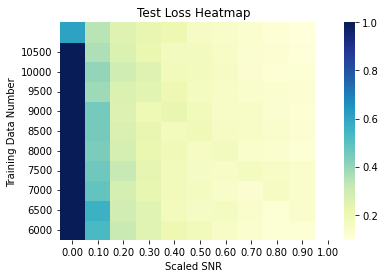

In [26]:
A1 =  np.arange(6000, 11000, 500)
A2 =  np.arange(0, 1.1, 0.1)
xlabels = ['{:3.2f}'.format(x) for x in A2]
# ylabels = ['{:3.1f}'.format(y) for y in A1]
# xlabels = A2
ylabels = A1

ax = sns.heatmap(Data_test, xticklabels = xlabels, yticklabels = ylabels, cmap = "YlGnBu", vmax = 1)
ax.invert_yaxis()
ax.set_title("Test Loss Heatmap")
ax.set_xlabel('Scaled SNR')
ax.set_ylabel('Training Data Number')


In [17]:
Data_test = Data_test.reshape((10,10))

In [ ]:
A = np.random.randn(10000,28,28)
B = np.zeros([10000,18,18])
A[0:10000, 5:23, 5:23] = B
mnist_test= np.array(A.reshape((10000, 784)) + sigma*mnist.test.images, dtype="float32")
plt.imshow(np.reshape(mnist_test[0], [28, 28]), cmap='gray')
plt.show()

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpwofn_xs5/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/tmpwofn_xs5/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


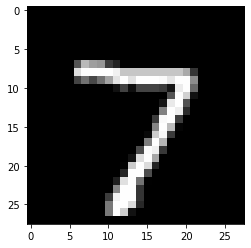

Model prediction: 7


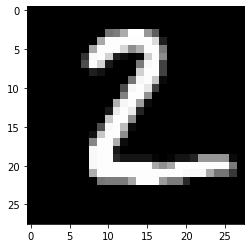

Model prediction: 2


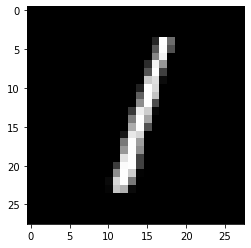

Model prediction: 1


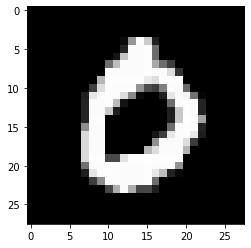

Model prediction: 0


In [ ]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])